In [50]:
# The results are saved to a text file, which should be renamed when you have run the entire notebook and want to do so again
testFile = "fewshotSoftLargeV2.txt"
# Next parameter is the amount of runs you want the method to do. As LLMs give different results each time, you should run it multiple times to 
# get more robust results. Setting it to n means n-1 runs
methodRuns = 11
# The last parameter to set is the threshold for the aggregating of the labels of the annotators
# A threshold of n means n different annotators choose this label for this example of text
annotatorThreshold = 2

In [2]:
import ollama
import csv
import pandas as pd
import numpy

# read the unannotated data file to a dataframe
unannotatedDataFrame = pd.read_csv('notAnnotatedData.csv', sep=';', header=0)
# create a string with all the labels
# approval has an ", as the predictions for disapproval otherwise also get counted for approval
labelsToAnnotate: str = "admiration;amusement;anger;annoyance;\"approval;caring;confusion;curiosity;desire;disappointment;disapproval;disgust;embarrassment;excitement;fear;gratitude;grief;joy;love;nervousness;optimism;pride;realization;relief;remorse;sadness;suprise;neutral"

# read the annotated files to dataframes
# 5 different annotators annotated the data, this has to be aggregated
annotated1 = pd.read_csv('annotatedData/Emotion-1.csv', sep=';', header=0)
annotated2 = pd.read_csv('annotatedData/Emotion-2.csv', sep=';', header=0)
annotated3 = pd.read_csv('annotatedData/Emotion-3.csv', sep=';', header=0)
annotated4 = pd.read_csv('annotatedData/Emotion-4.csv', sep=',', header=0)
annotated5 = pd.read_csv('annotatedData/Emotion-5.csv', sep=',', header=0)
# drop the not needed columns. Add does not work properly otherwise.
dropList = ["id", "question_id", "participant_id", "frisian", "dutch", "english"]
annotated1Clean = annotated1.drop(dropList, axis=1)
annotated2Clean = annotated2.drop(dropList, axis=1)
annotated3Clean = annotated3.drop(dropList, axis=1)
annotated4Clean = annotated4.drop(dropList, axis=1)
annotated5Clean = annotated5.drop(dropList, axis=1)

# combine the data frames
annotatedDataFrame12 = annotated1Clean.add(annotated2Clean, fill_value=0)
annotatedDataFrame34 = annotated3Clean.add(annotated4Clean, fill_value=0)
annotatedDataFrame345 = annotatedDataFrame34.add(annotated5Clean, fill_value=0)
annotatedDataFrame = annotatedDataFrame345.add(annotatedDataFrame12, fill_value=0)
# replace the NaN with 0, this is needed in order to calculate the F1 score, precision and recall later
annotatedDataFrameNoNaN = annotatedDataFrame.fillna(0)
annotatedDataFrameNoNaN50 = annotatedDataFrameNoNaN.iloc[0:50]
annotatedDataFrameNoNaN50= annotatedDataFrameNoNaN50.drop([4, 6, 21])
# transform the annotated data to a numpy array to do the evaluations with
numAnnotatedSummed = pd.DataFrame.to_numpy(annotatedDataFrameNoNaN50)
# Then a threshold is set on which labels are considered "true"
numAnnotated = numAnnotatedSummed/5


# row 0 till 49 are annotated
numpy.set_printoptions(threshold=30000)
print(numAnnotated)


[[0.  0.2 0.  0.  0.4 0.4 0.2 0.2 0.2 0.  0.  0.  0.  0.4 0.  0.2 0.  0.
  0.  0.4 0.6 0.  0.4 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.2 0.4 0.  0.4 0.6 0.  0.2 0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.6 0.4 0.2 0.  0.  0.  0.  0.  0. ]
 [0.2 0.  0.  0.  0.2 0.  0.  0.  0.4 0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.6 0.  0.2 0.  0.  0.  0.  0.4]
 [0.  0.  0.  0.  0.4 0.2 0.  0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.4 0.  0.2 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.2 0.2 0.  0.  0.2 0.4 0.2 0.  0.  0.  0.2 0.  0.  0.  0.
  0.  0.  0.4 0.  0.4 0.  0.  0.2 0.2 0.2]
 [0.  0.  0.4 0.2 0.  0.2 0.  0.2 0.  0.6 0.8 0.  0.  0.  0.  0.  0.  0.
  0.  0.2 0.4 0.  0.  0.  0.  0.  0.  0. ]
 [0.2 0.  0.  0.  0.6 0.6 0.  0.  0.6 0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.4 0.8 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.2 0.4 0.8 0.  0.  0.4 0.6 0.4 0.  0.  0.2 0.  0.  0.  0.
  0.  0.2 0.8 0.6 0.  0.  0.  0.2 0.  0. ]
 [0.  0.  0.  0.  0.4 0.  0.  0.  0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.

In [4]:
from tqdm import tqdm
tqdm.pandas()

def fewShot(data) -> str:
    "fewShot method for detecting emotions. Four examples are given to the LLM"

    response = ollama.chat(model='llama3', format='json',messages=[
    {
        'role': 'user',
        'content': """  Your task is to identify one to three key emotions in the text using the given labels. 
                        If no emotion is detected, use the label neutral.
                        Answer with the identified emotions and their corresponding probabilities in JSON format. Please provide your answer in the format: [emotion1: score], [emotion2: score], ...
                    """
    },
    {
        'role': 'user',
        'content': """  Text: I would like to see a large field of solar panels, worn by the inhabitants themselves, paid for by the inhabitants themselves, the moment a resident leaves for the area he should be able to sell his part back, new residents should also be able to buy a part. In this way, you as a municipality become self-sufficient while it is affordable for the vast majority of residents. Residents who would not be able to participate financially, must be able to use the solar energy, as they currently purchase electricity from their supplier.
                        \n Labels: """ + labelsToAnnotate 
    },
    {
        'role': 'assistant',
        'content': "[approval: 0.4], [caring: 0.8], [desire: 0.6], [excitement: 0.4], [optimism: 1.0]"
    },
    {
        'role': 'user',
        'content': """  Text: Given the impact of the measures, right behind the front door, it seems better to put the control in the hands of municipalities and residents. The market can go out.
                        \n Labels: """ + labelsToAnnotate 
    },
    {
        'role': 'assistant',
        'content': "[approval: 0.6], [caring: 0.2], [desire: 0.2], [fear: 0.2], [nervousness: 0.4], [optimism: 0.2], [pride: 0.2], [realization: 0.2]"
    },
    {
        'role': 'user',
        'content': """  Text: Here I have given 10 points. A fairly large wind farm is already coming near me, between Zurich and Witmarsum.  I think that's enough for SÃºdwest-FryslÃ¢n.  The idea of making SÃºdwest-FryslÃ¢n the supplier of the Netherlands seems to me to be a bad idea.  We have wind here, so let's limit ourselves to windmills. Then other parts of the country can invest in large-scale solar parks with less wind. Please share the burden.
                        \n Labels: """ + labelsToAnnotate 
    },
    {
        'role': 'assistant',
        'content': "[anger: 0.2], [annoyance: 1.0], [caring: 0.2], [disappointment: 0.2], [disapproval: 1.0]"
    },
    {
        'role': 'user',
        'content': "Text: " + data.english + "\n Labels: " + labelsToAnnotate
    },
    ])
    # response is a mapping of model, created at, message, done, total duration, load duration, prompt eval durationm eval count and eval duration
    # we only want to return the content of the message to be used 
    return pd.Series(response['message']['content'])

# we exclude row 4, 6, and 21 as those are used for giving examples to the LLM.
# these examples got clear labels from the annotators and provide a good overall understanding of the different emotions
test = unannotatedDataFrame.iloc[0:50]
smallTest = test.drop([4, 6, 21])

# apply runs the method on each row of the provided dataframe. Data.english is used to only provide the LLM with the english text
# progress_apply is used to see the progress of calling the method per row, as the LLM takes some time to run it is nice to see the progress

# to create more robust results, the method is run 10 times and the resulting labels are aggregated
# if you want to run the method less times, change the following variable:
# This can be set at the top of the document
# methodRuns = 11
runs = {}
# f = open("fewSoft.txt", "a")



# for n in range (1, methodRuns):
#     runs["response{0}".format(n)] = smallTest.progress_apply(fewShot, axis=1)
#     runs["response" + str(n)].columns = ["labels"]
#     f.write("response" + str(n) + "\n")
#     f.write(pd.DataFrame.to_string(runs["response" + str(n)]))
#     display( runs["response" + str(n)])

# f.close()
# print(runs["response1"])

In [5]:
runs["response5"] = smallTest.progress_apply(fewShot, axis=1)
runs["response5"].columns = ["labels"]
print(runs["response5"])
f = open("fewSoftV2.txt", "a")
f.write("result5 \n")
f.write(pd.DataFrame.to_string(runs["response5"]))
f.close()

100%|██████████| 47/47 [08:04<00:00, 10.32s/it]

                                               labels
0                                  { "neutral": 0.8 }
1   { "caring": 0.8, "confusion": 0.6, "curiosity"...
2                                 { "approval": 0.8 }
3                                 { "approval": 0.8 }
5                                  { "neutral": 1.0 }
7   { "anger": 0.8, "annoyance": 1.0, "disapproval...
8   { "approval: 0.6"  : 0.6, "caring: 0.8" : 0.2,...
9   { "approval": 0.8, "caring": 0.4, "desire": 0....
10                                { "approval": 0.8 }
11                             { "disapproval": 1.0 }
12                 { "approval": 0.8, "caring": 0.4 }
13                 { "approval": 0.6, "caring": 0.2 }
14                 { "approval": 0.8, "caring": 0.2 }
15   { "approval: 0.6" : null, "caring: 0.2" : null }
16                                 { "neutral": 1.0 }
17                 { "approval": 0.8, "caring": 0.4 }
18  { "anger": 0.8, "annoyance": 1.0, "disapproval...
19  { "approval": 0.4, "cari

In [45]:
fewSoft = 'fewSoftRuns/run'
current = fewSoft
for n in range(1, 11):
    csvPath = current + str(n) + '.csv'
    res = pd.read_csv(csvPath, sep='{', header=None)
    res.columns = ["rows", "labels"]
    # res[["labels", "num"]] = res["text"].str.split("}", expand=True)
    runs["response" + str(n)] = res[["labels"]].copy()

# display(runs["response1"])

In [48]:
# From the response we create a dataframe in the same format as our annotated labels
# First we need a list of labels
labelsList = labelsToAnnotate.split(";")

# A method that gets the score from the labels given by the LLM
def getScore(rowLabel, checkLabel):
   # print(rowLabel)
   for l in rowLabel:
      if checkLabel in l:
         # l is both the label and the score
         splitted = l.split(":")
         # splitting on : gives the score
         score = splitted[1]
         # sometimes the score contains some other symbols, so it needs to be splitted again
         if "\\" in score:
            cleanScore = float(score.split("\\")[0])
            # print(cleanScore)
         elif "\"" in score:
            # print(score)
            cleanScore = float(score.split("\"")[0])
            # print(cleanScore)
         elif "\'" in score:
            cleanScore = float(score.split("\'")[0])
            # print(cleanScore)
         elif "]" in score:
            cleanScore = float(score.split("]")[0])
            # print(cleanScore)
         elif "}" in score:
            cleanScore = float(score.split("}")[0])
            # print(cleanScore)
         else:
            cleanScore = float(score)
         return cleanScore
   else:
      return 0

# Then for each method run
for n in range (1, 11):
   # List now contain a list of each emotion with a prediction
   runs["response" + str(n)]["list"] = runs["response" + str(n)]["labels"].str.split(",").tolist()
   # We go over each of these labels
   for label in labelsList:
      # And add a column with the correct name by d[][label]
      runs["response" + str(n)][label] = runs["response" + str(n)]["list"].apply(getScore, args=(label,))

# This prints the results of the first run
# print(runs["response1"])

In [51]:
# transform the result data to a numpy array to do evaluation on
frameResults = {}
numResults = {}

# For each method run
for n in range (1, methodRuns):
    # We drop the unneeded columns, which are the labels given by the LLM
    frameResults["response" + str(n)] = runs["response" + str(n)].drop(['labels', 'list'], axis=1)
    # then we turn the dataframe into a numpy array
    numResults["results" + str(n)] = pd.DataFrame.to_numpy(frameResults["response" + str(n)])
# This prints the cleaned up numpy array results of the first method run
print(repr(numResults["results1"]))

# now we create and write the results to a file
# !! rename the file when new results are created !!
f = open(testFile, "a")
for n in range (1, methodRuns):
    f.write("Results " + str(n) + "\n")
    f.write(pd.DataFrame.to_string(runs["response" + str(n)]) + "\n")
    f.write(numpy.array_str(numResults["results" + str(n)]) + "\n")

# Now we need to aggregate the results from the different method runs
# We start by adding all the numpy arrays together
sumResults =  numResults["results1"]
for n in range (2, methodRuns):
    sumResults = numpy.add(sumResults, numResults["results" + str(n)])
print(sumResults)
f.write("Aggregated results" + "\n")
f.write(repr(sumResults))
sumResultsNorm = sumResults/(methodRuns-1)
numpy.set_printoptions(suppress=True, formatter={'float_kind':'{:16.3f}'.format}, linewidth=130)
print(repr(sumResultsNorm))
f.write("Normalized results" + "\n")
f.write(repr(sumResultsNorm))
f.close()

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 0.4, 0.2, 0. , 0.4, 0.6, 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 1. ],
       [0. , 0. , 0. , 0. , 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0.8, 1. , 1. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0.

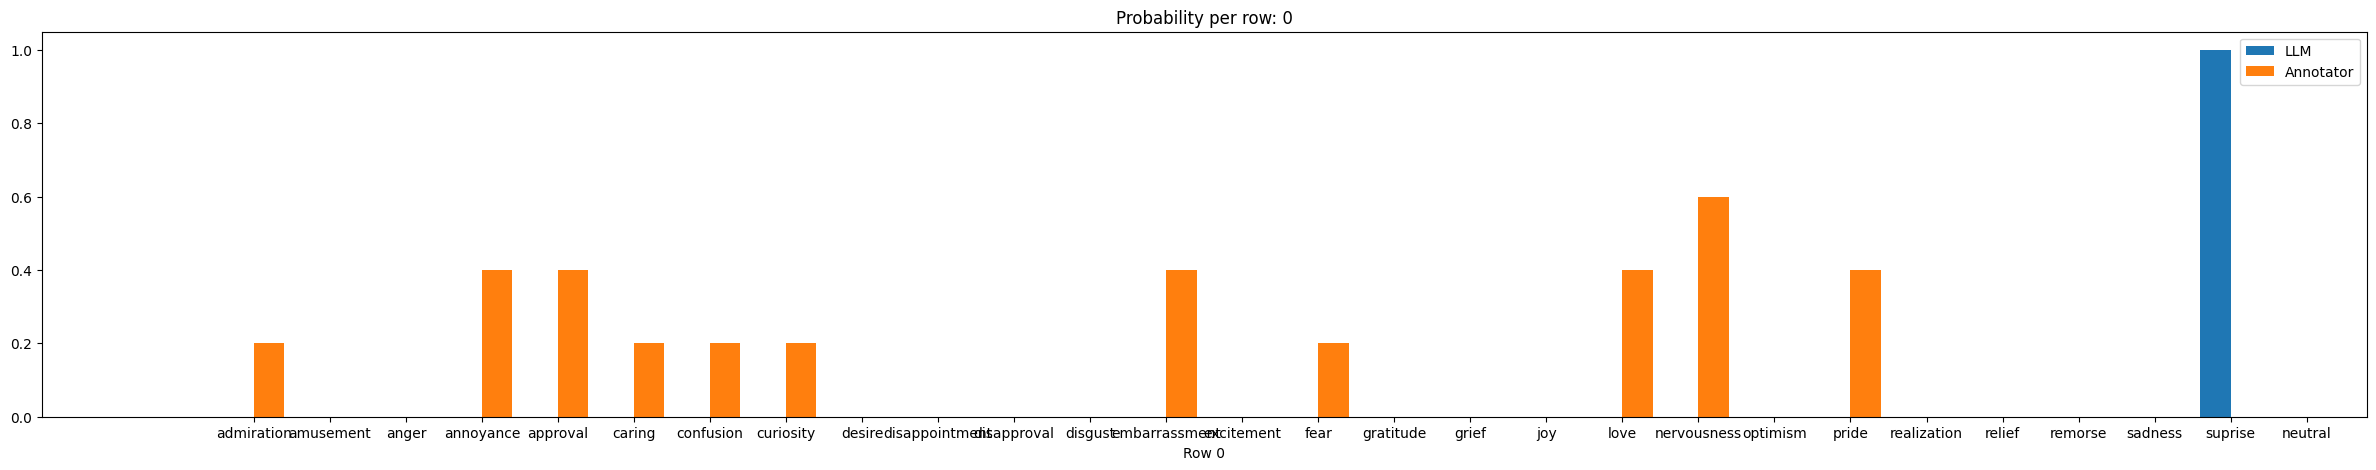

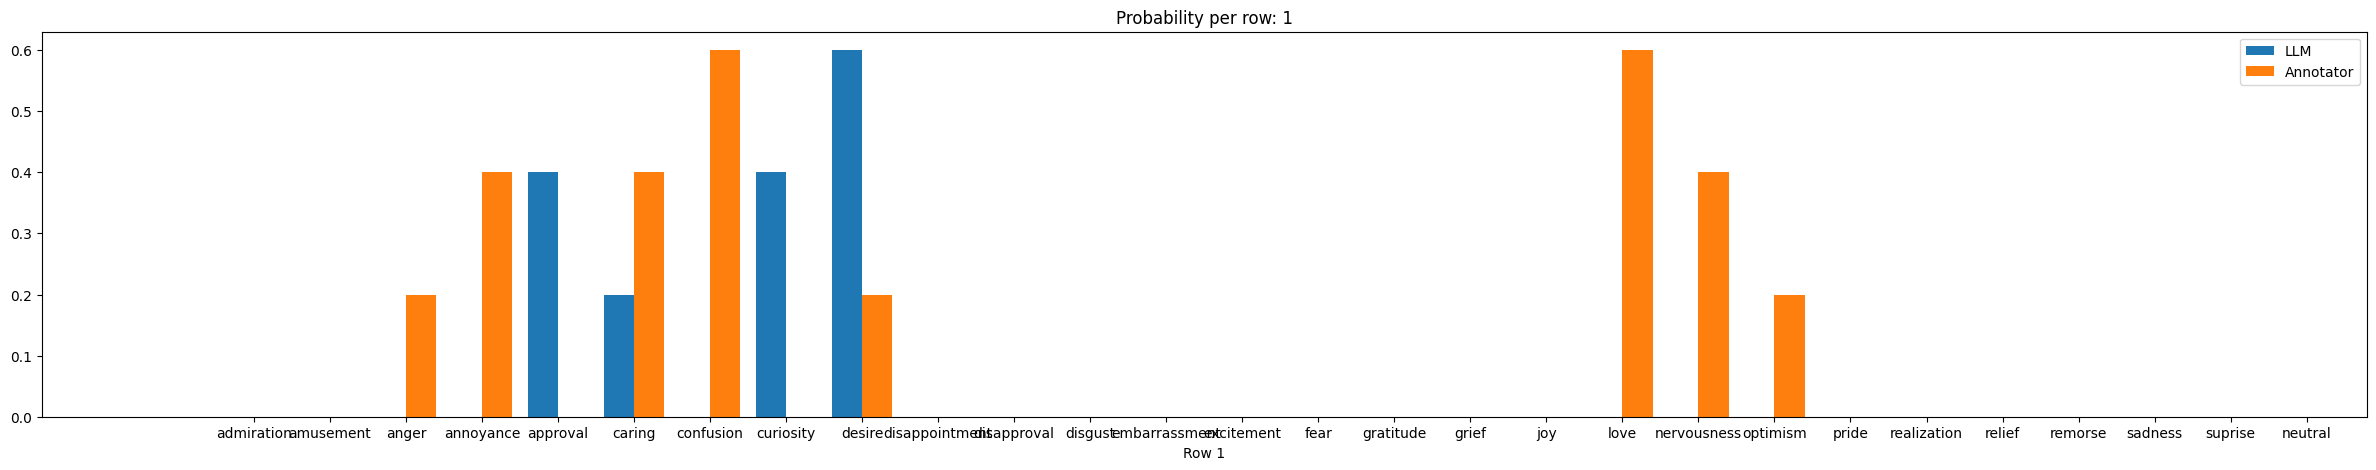

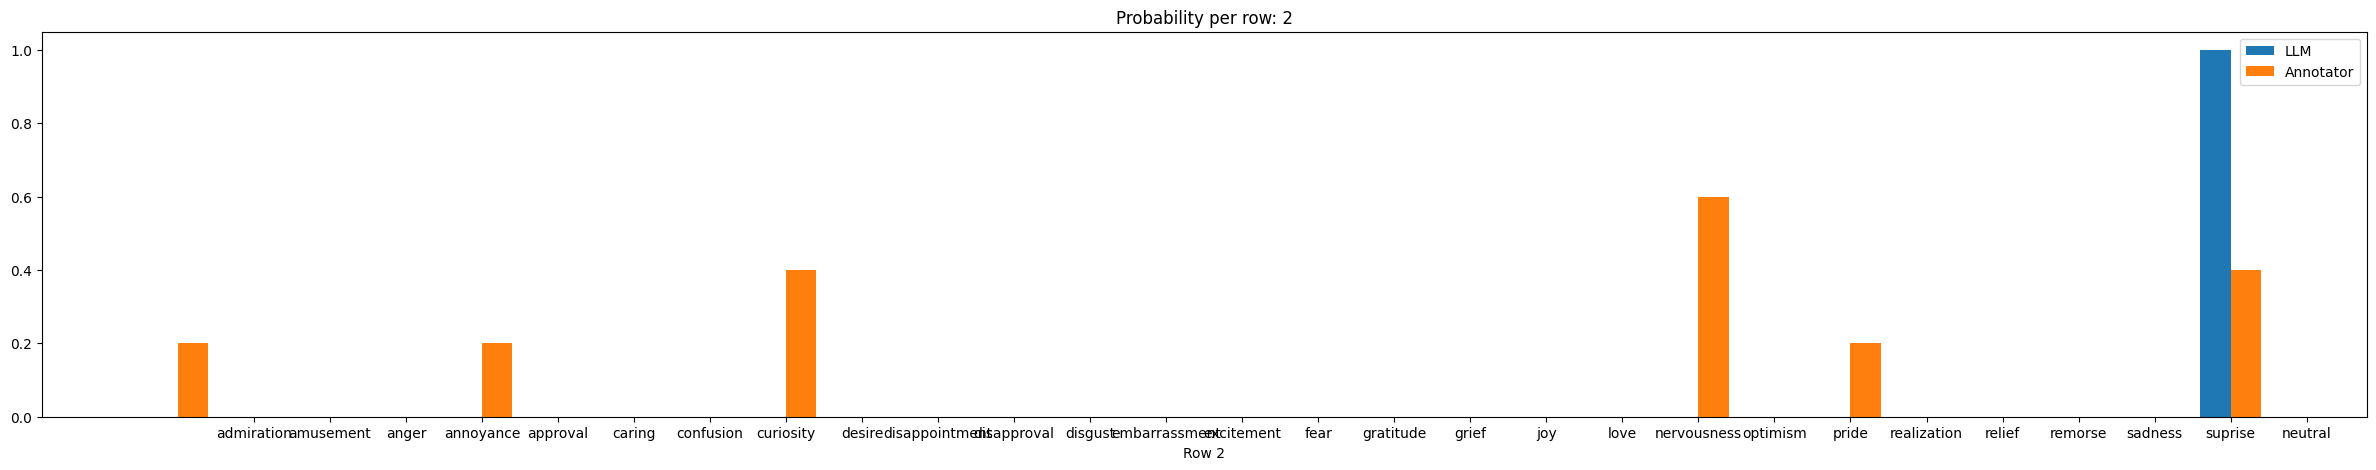

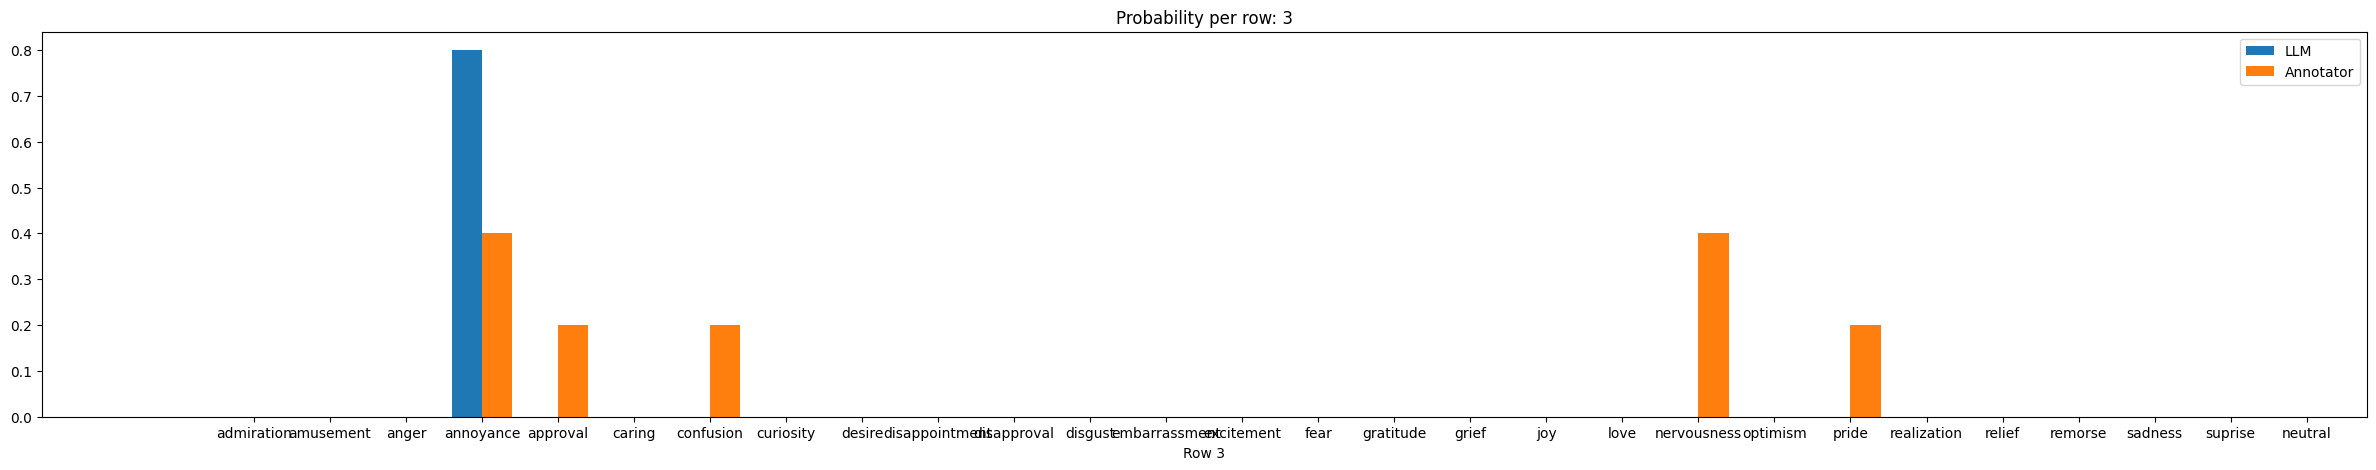

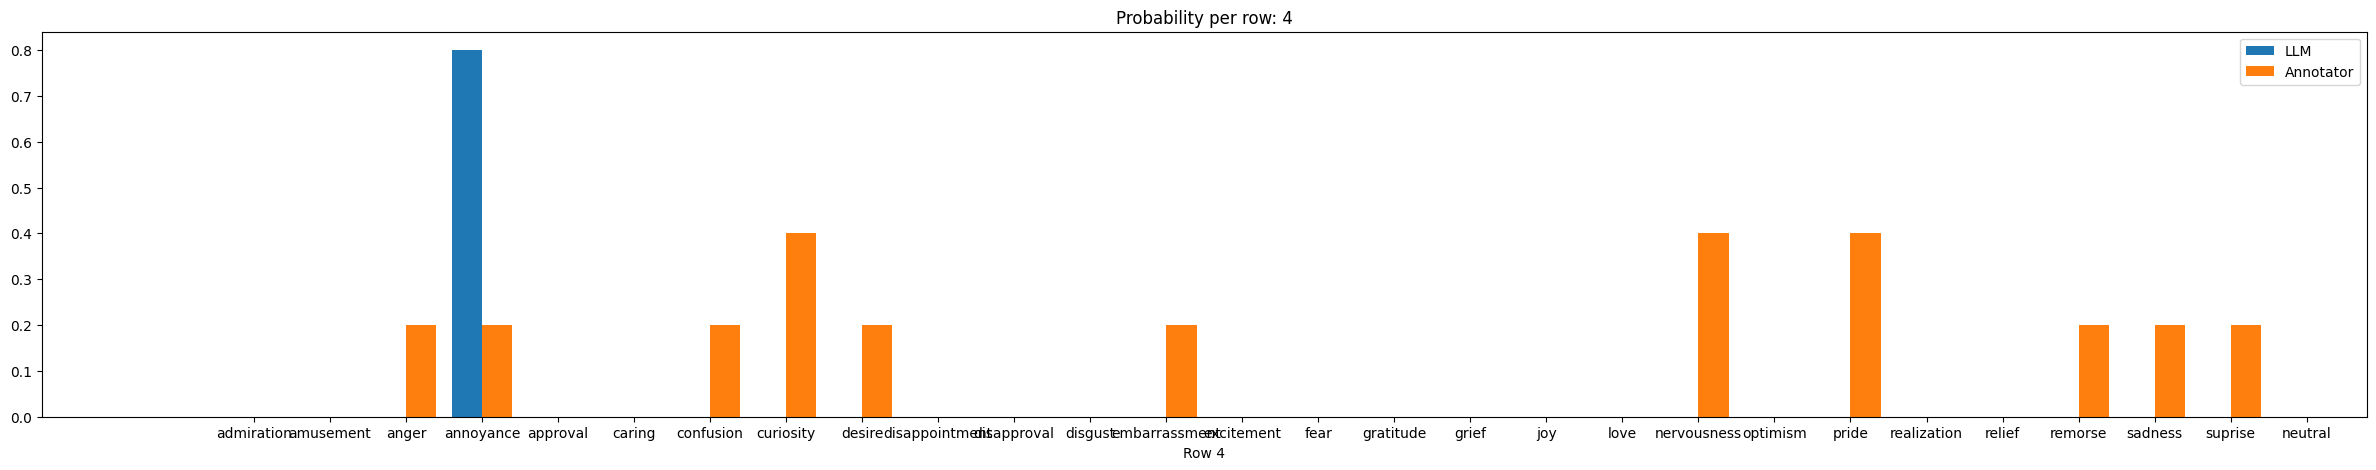

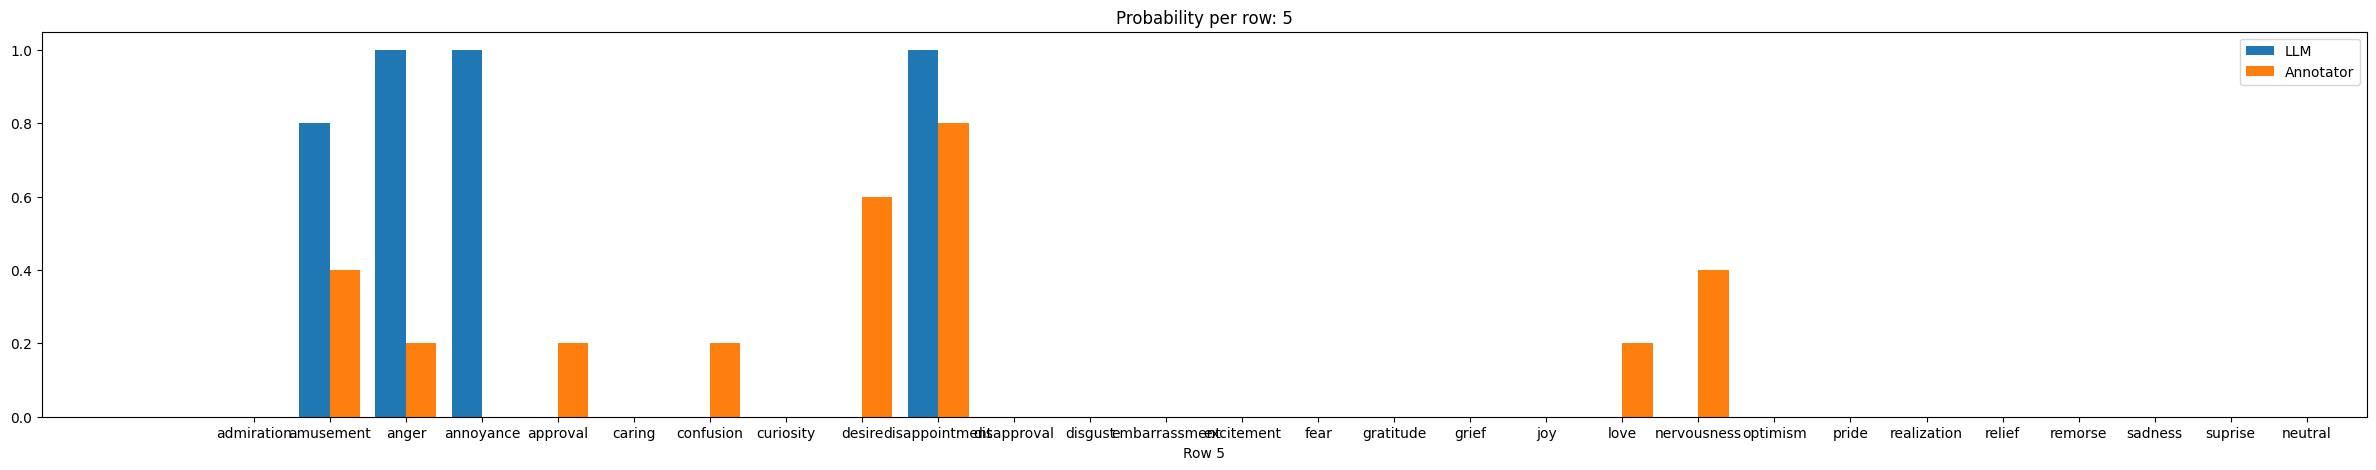

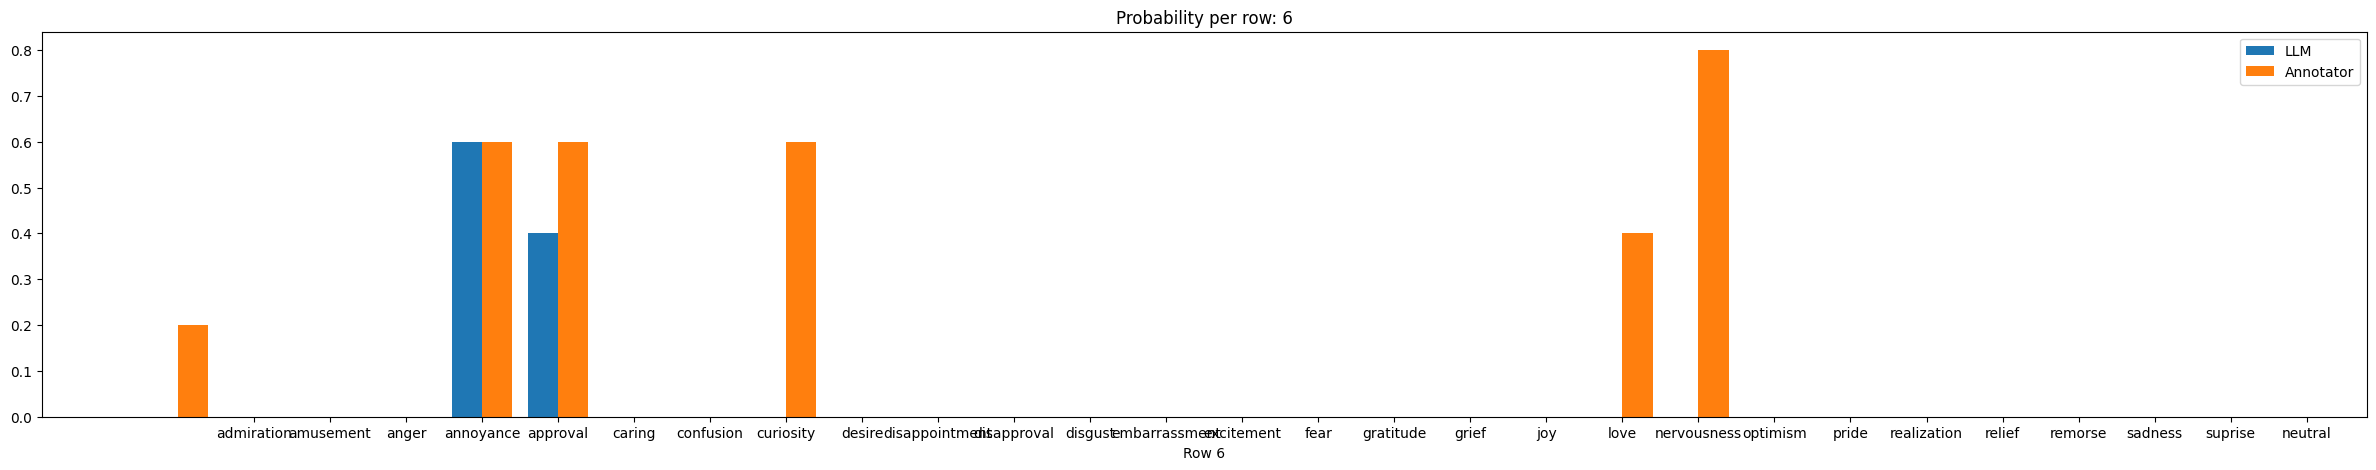

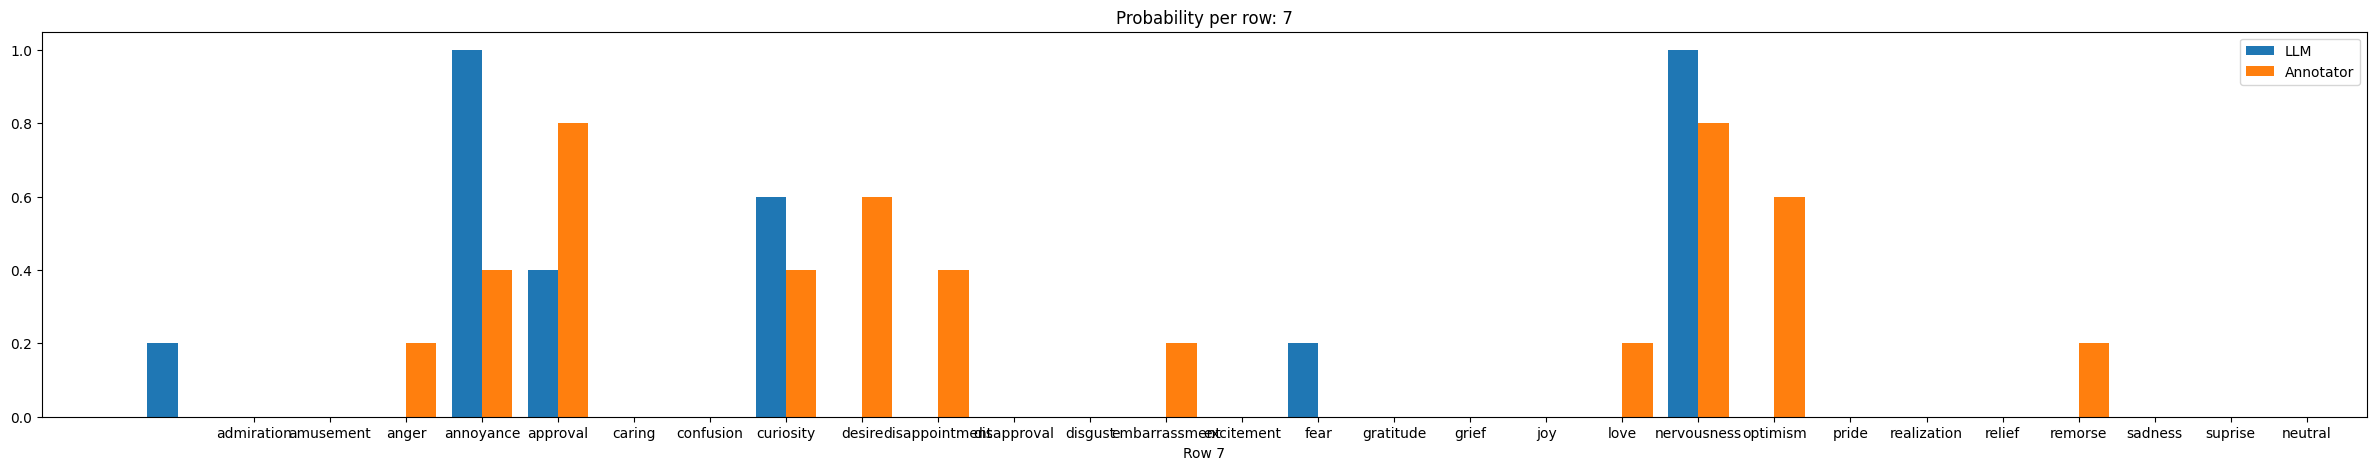

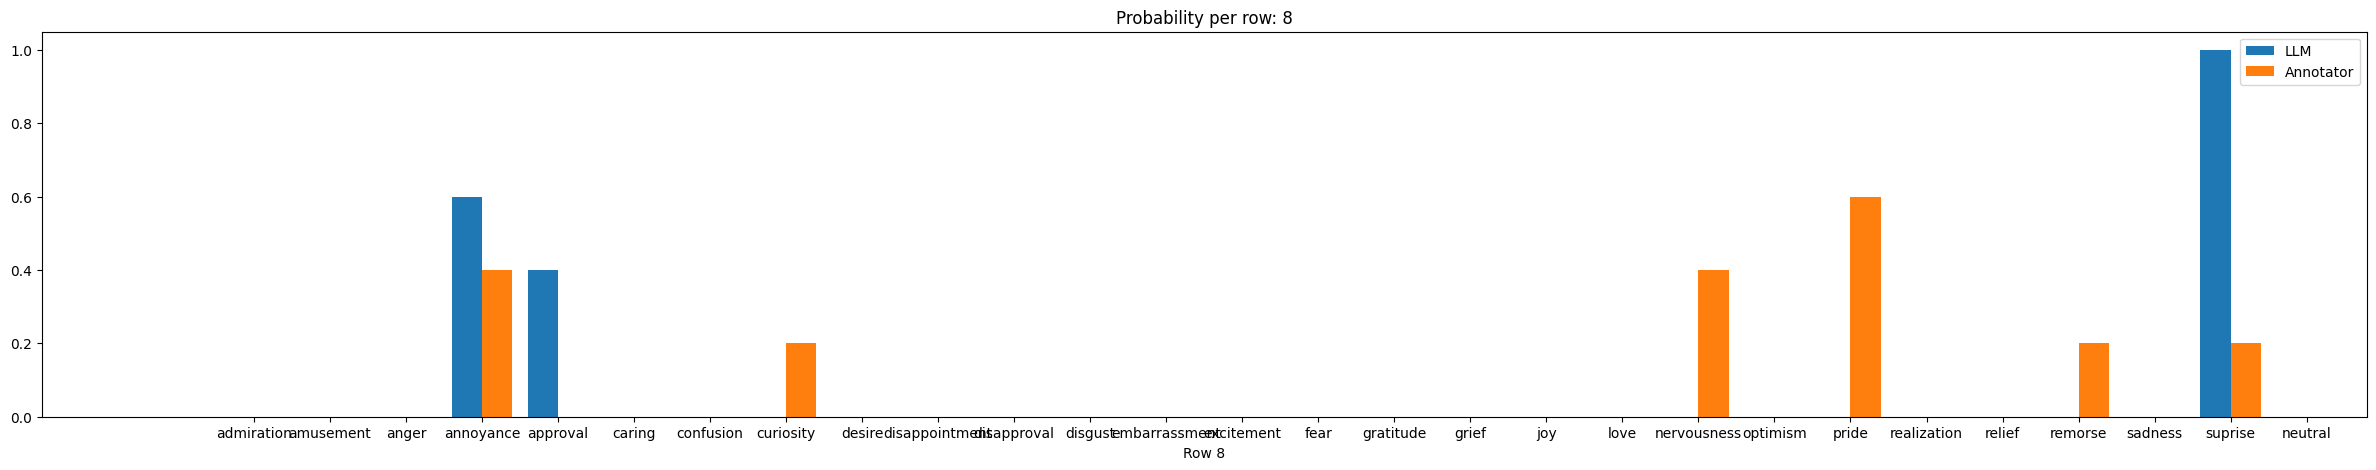

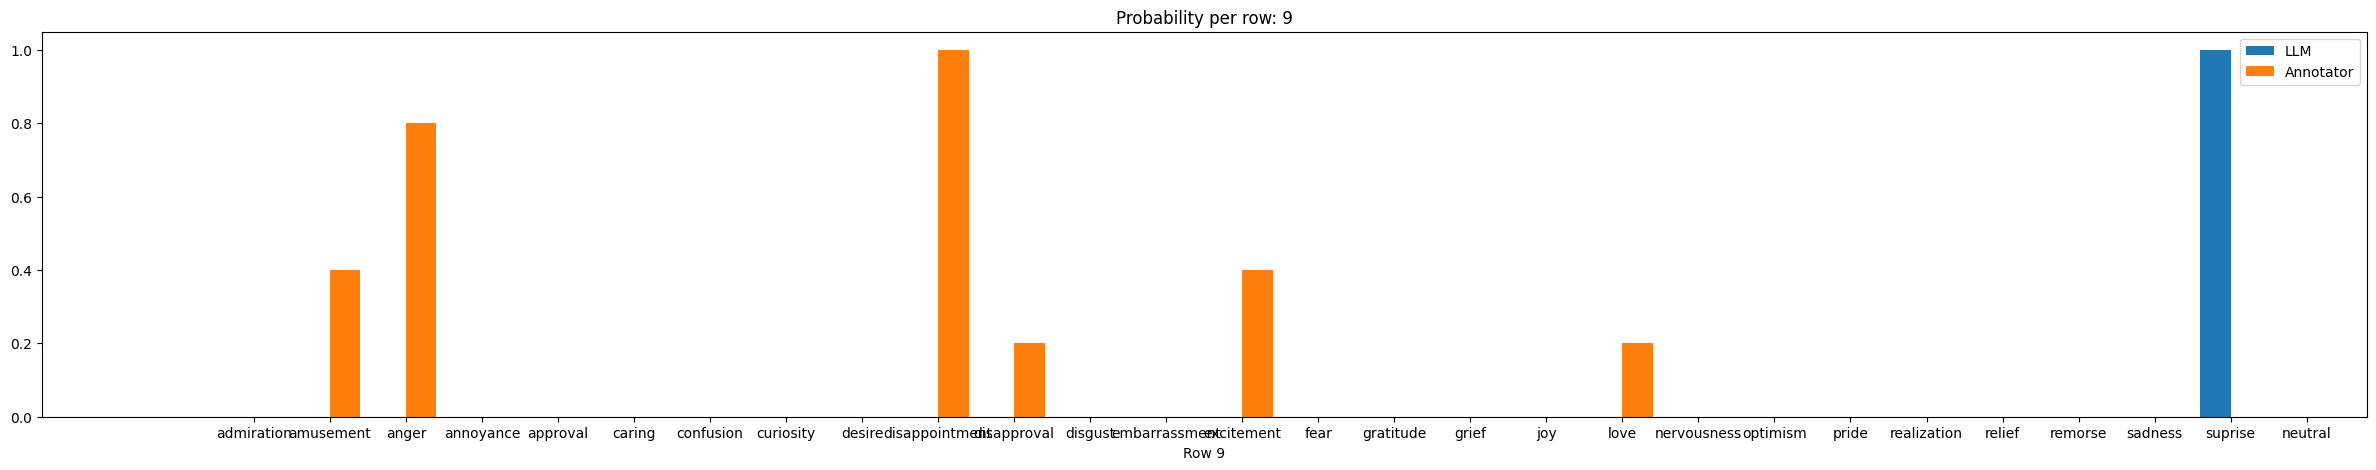

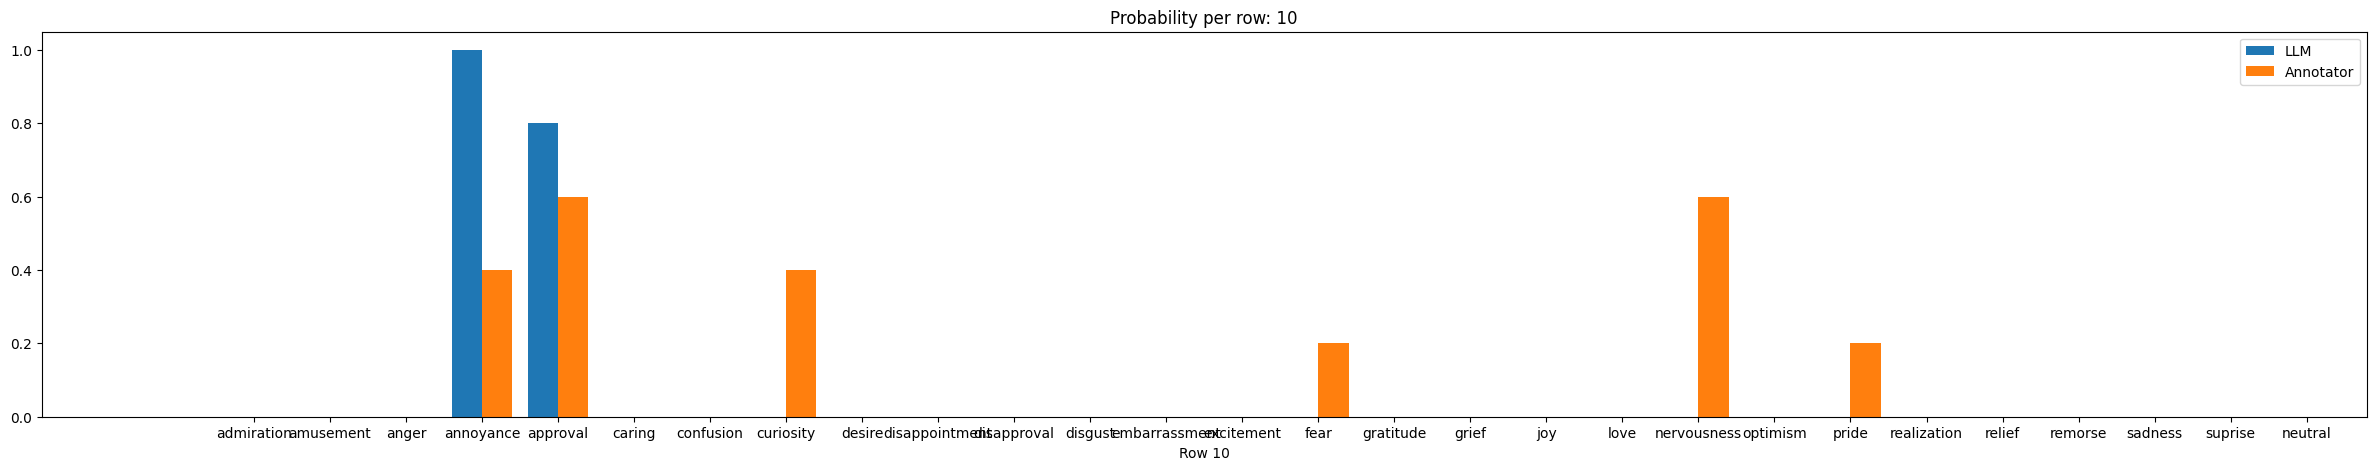

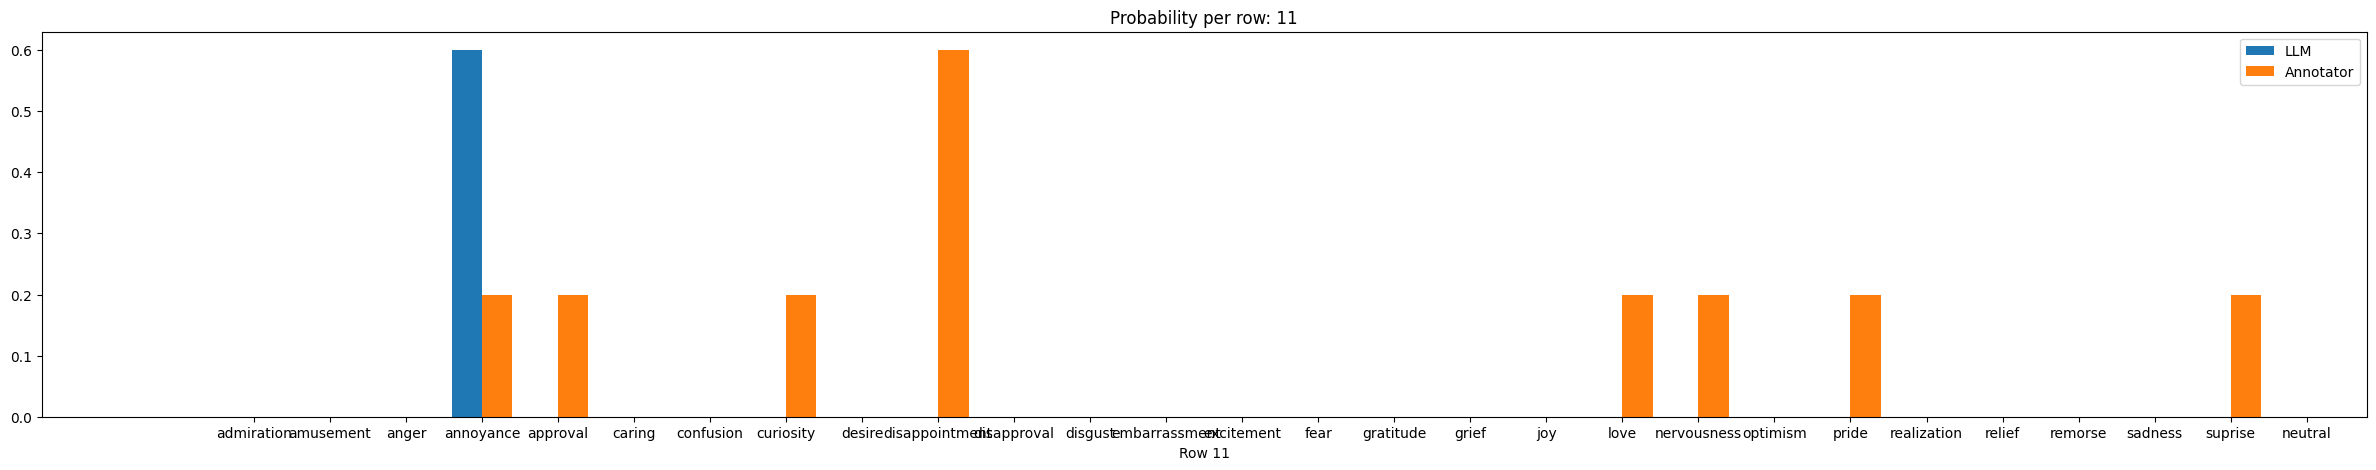

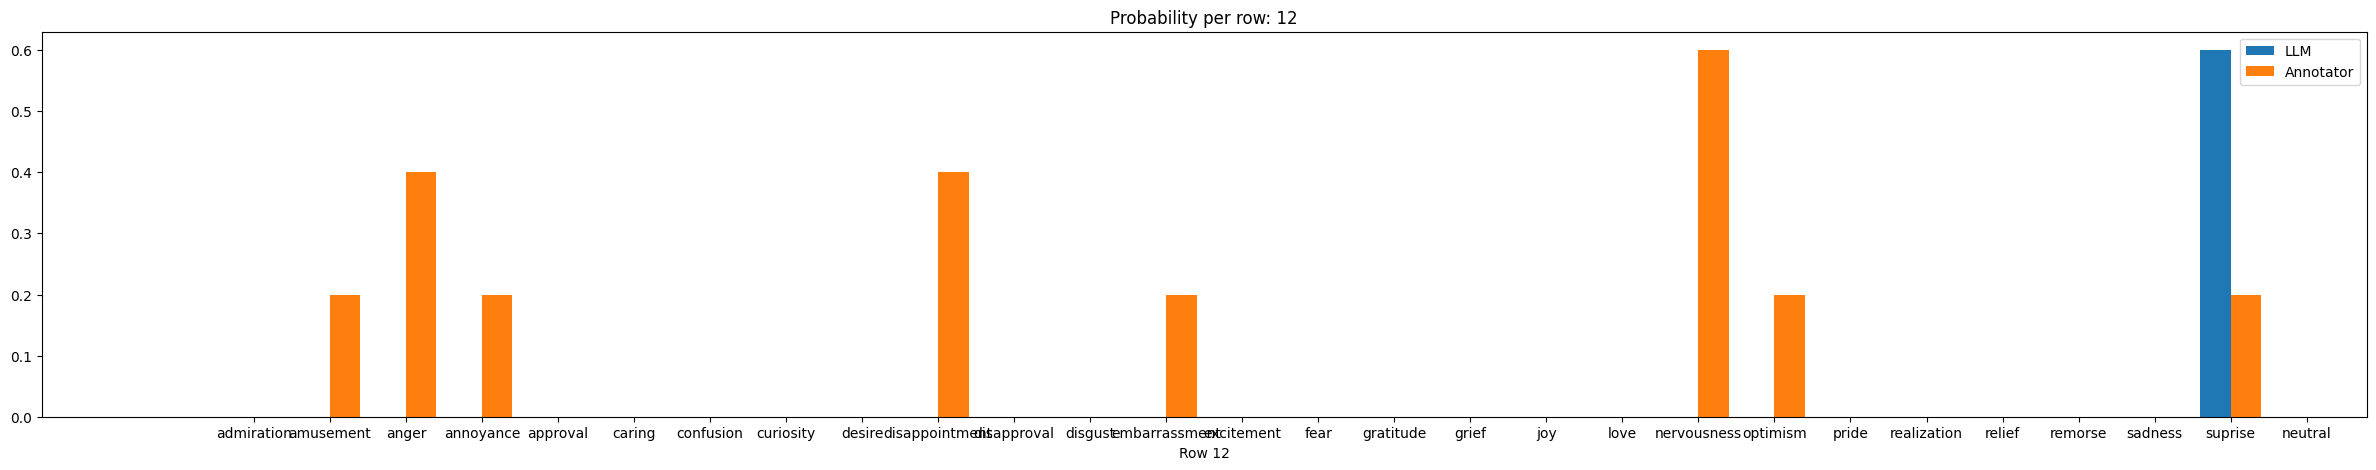

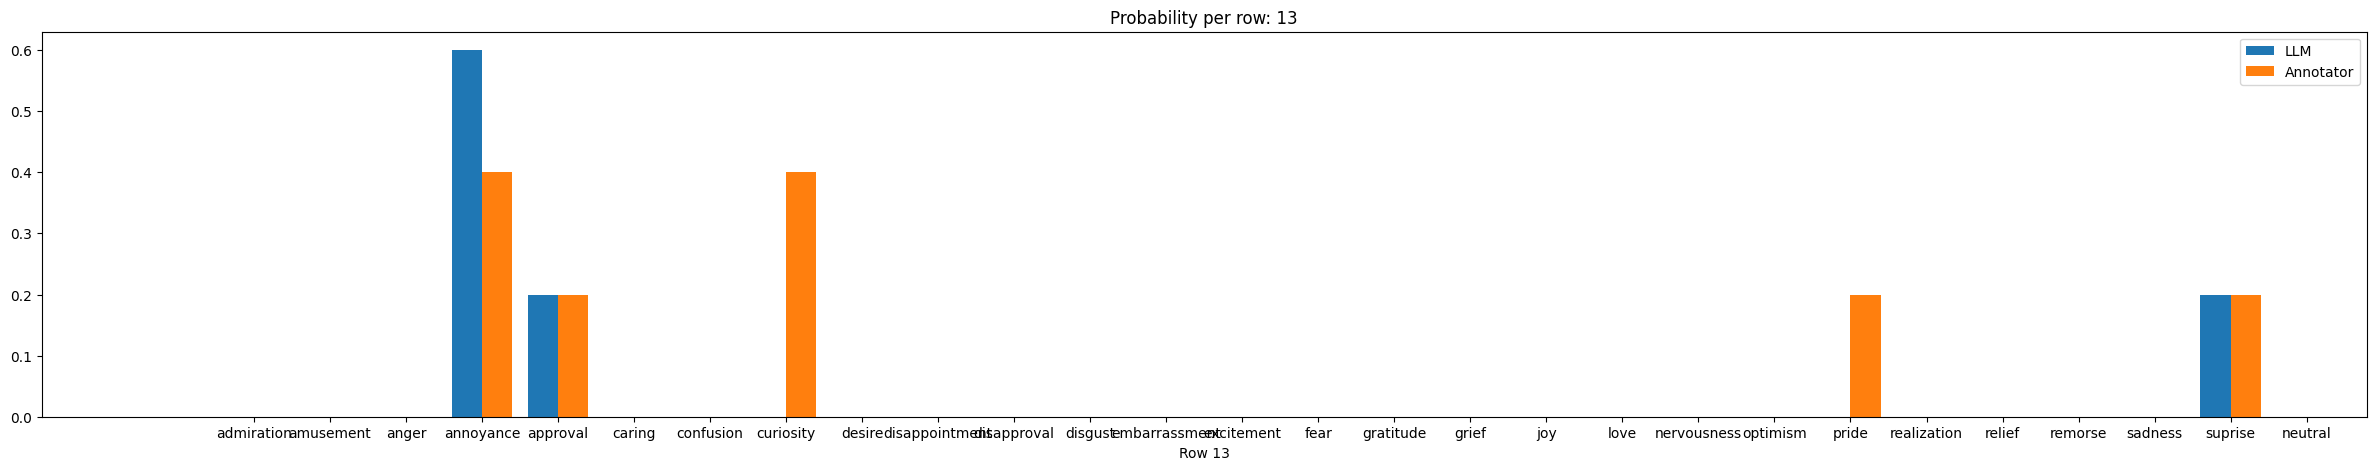

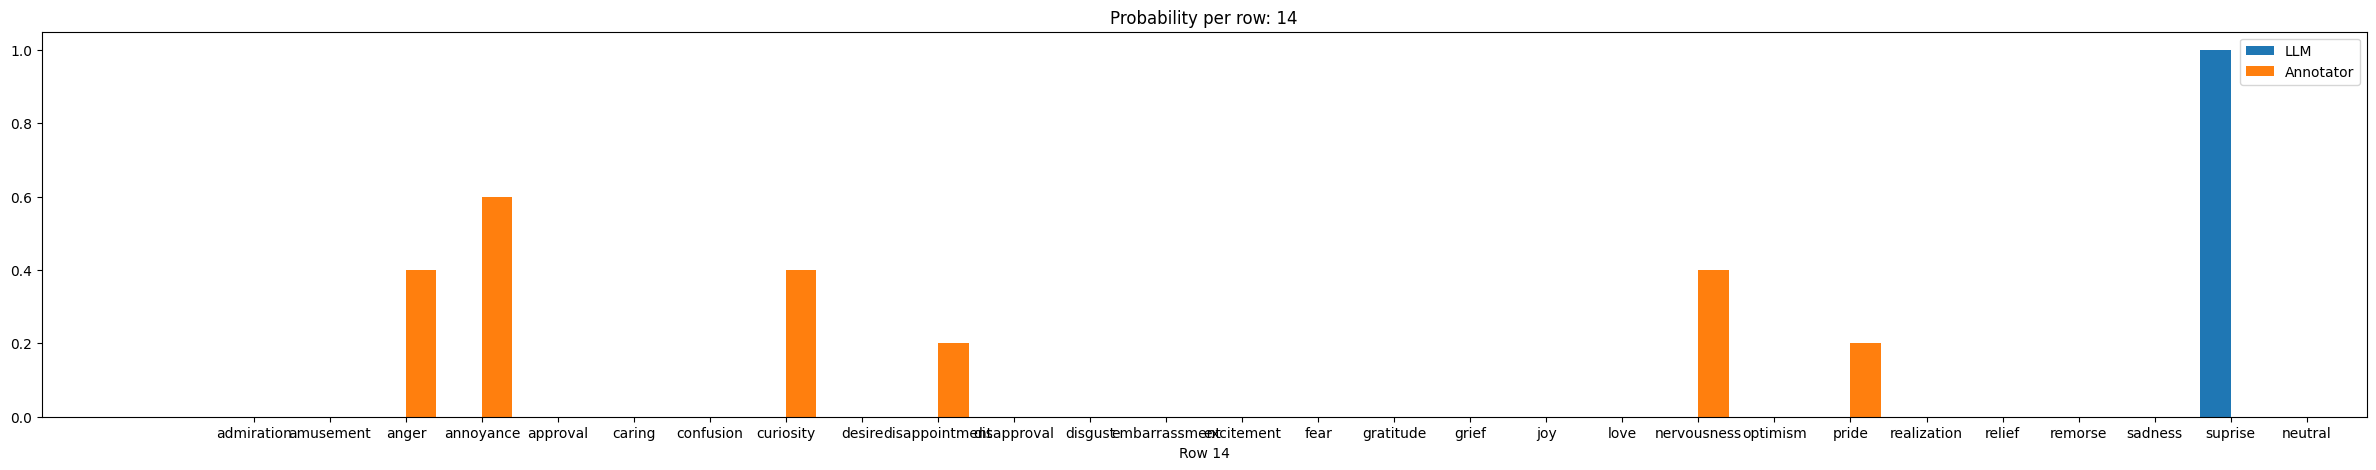

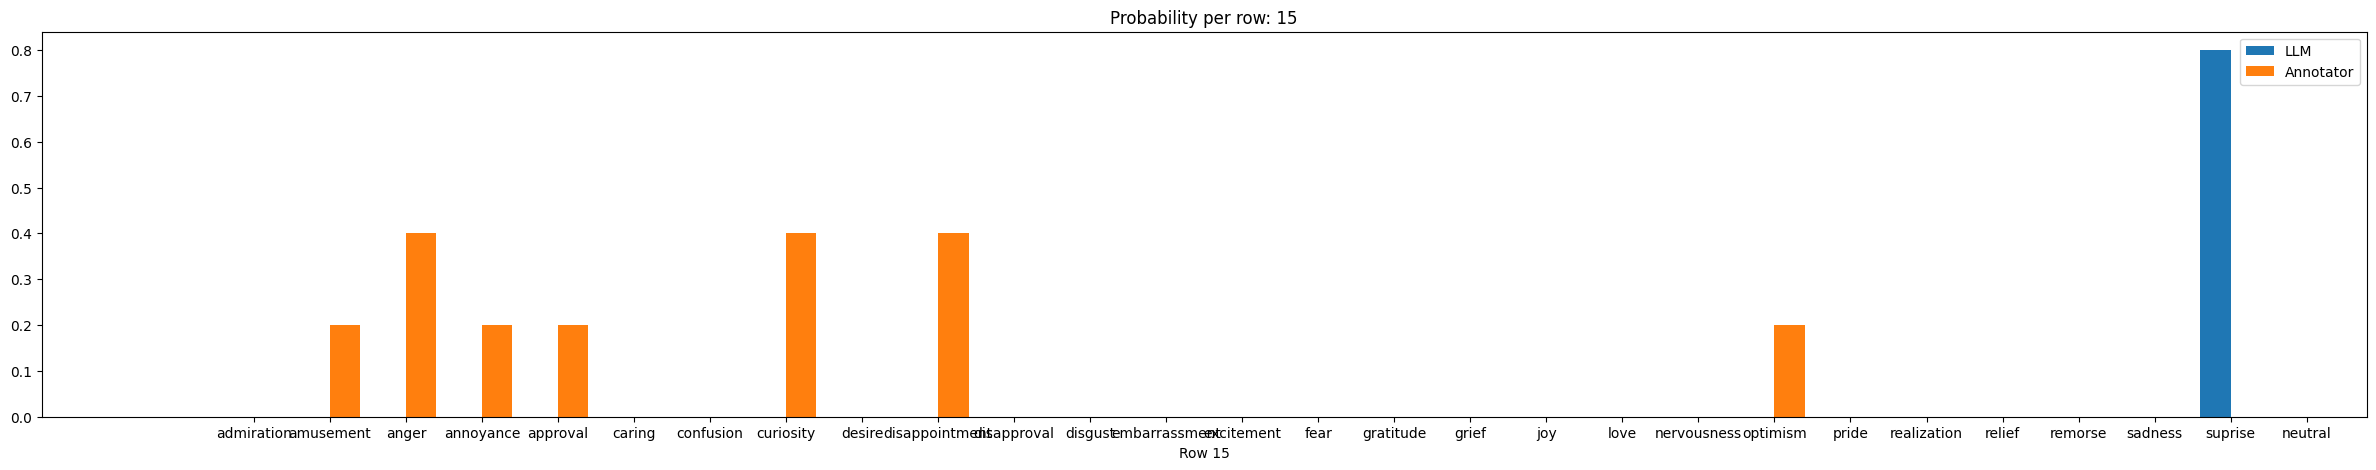

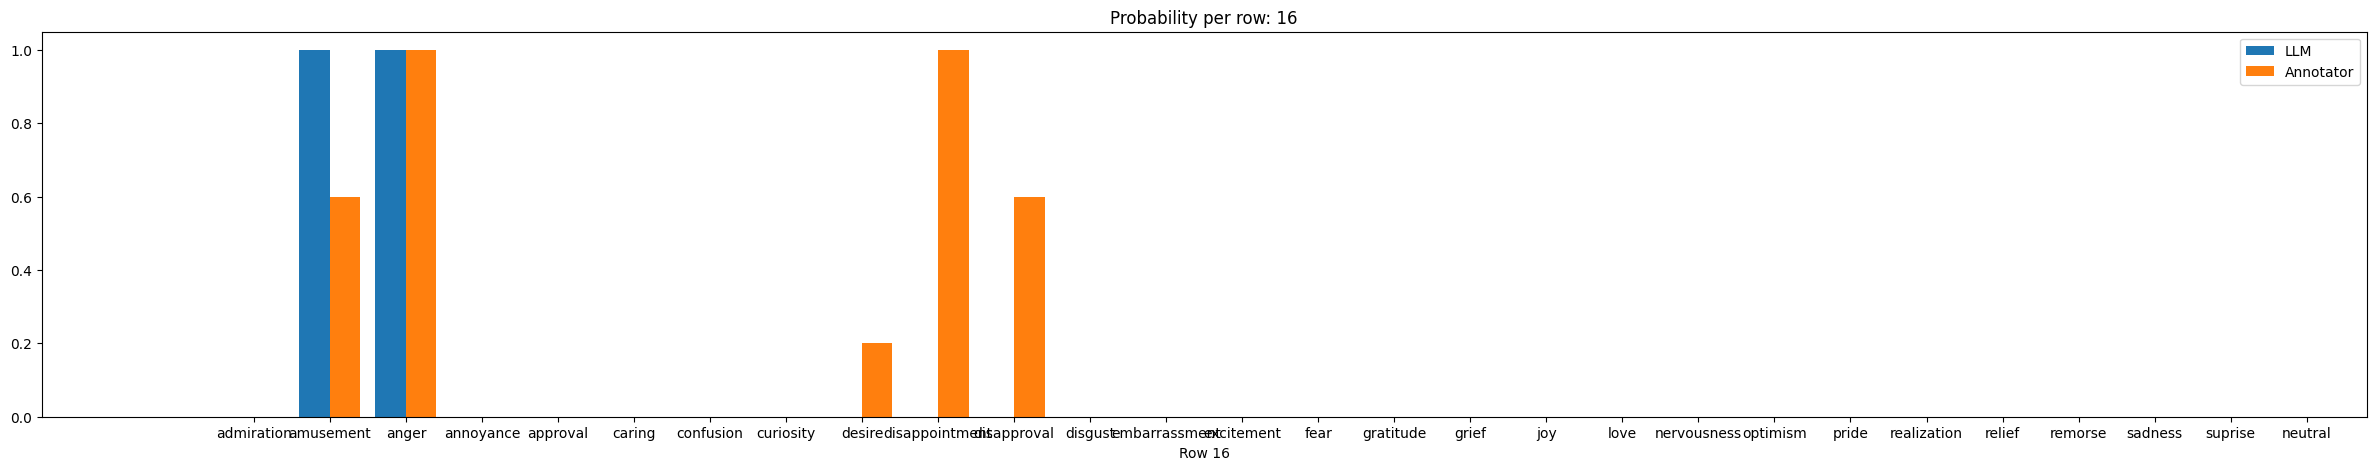

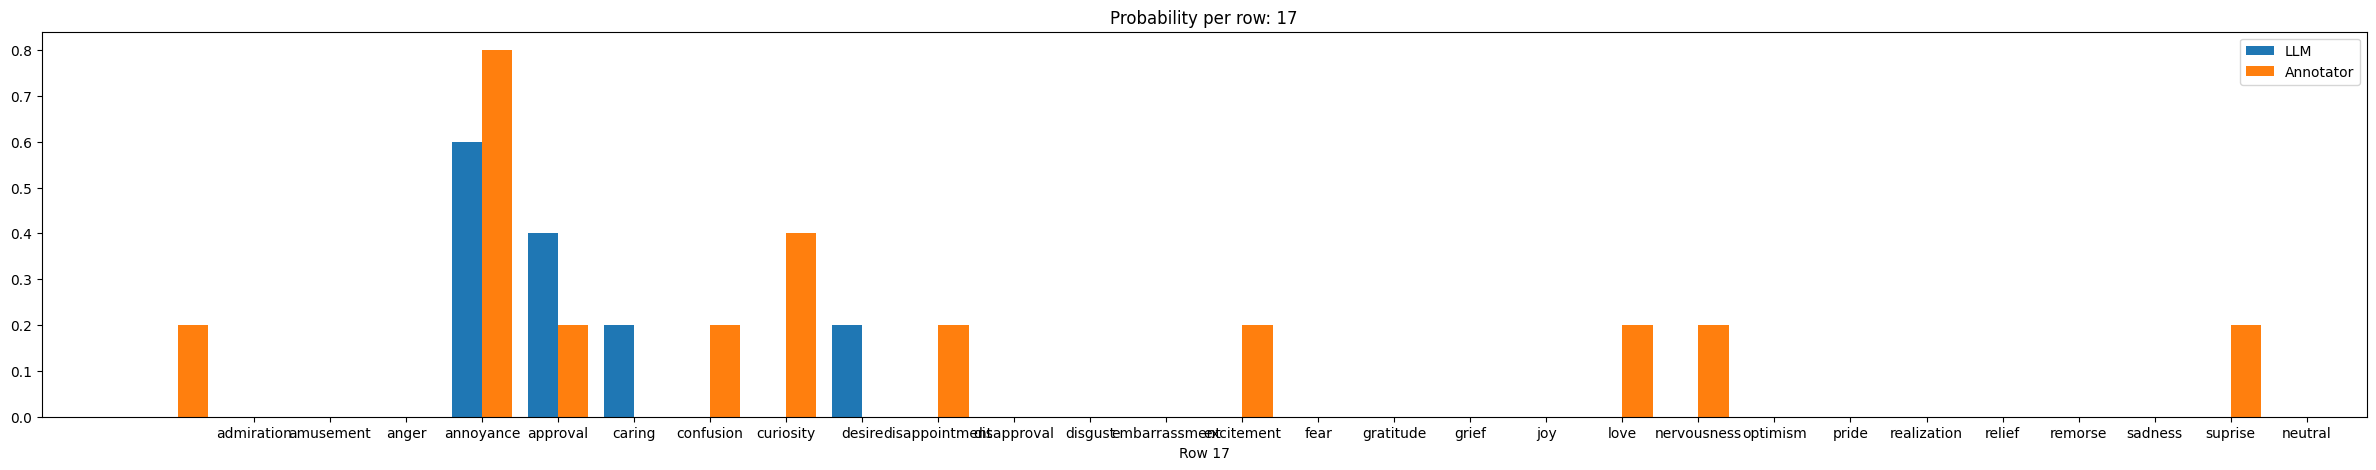

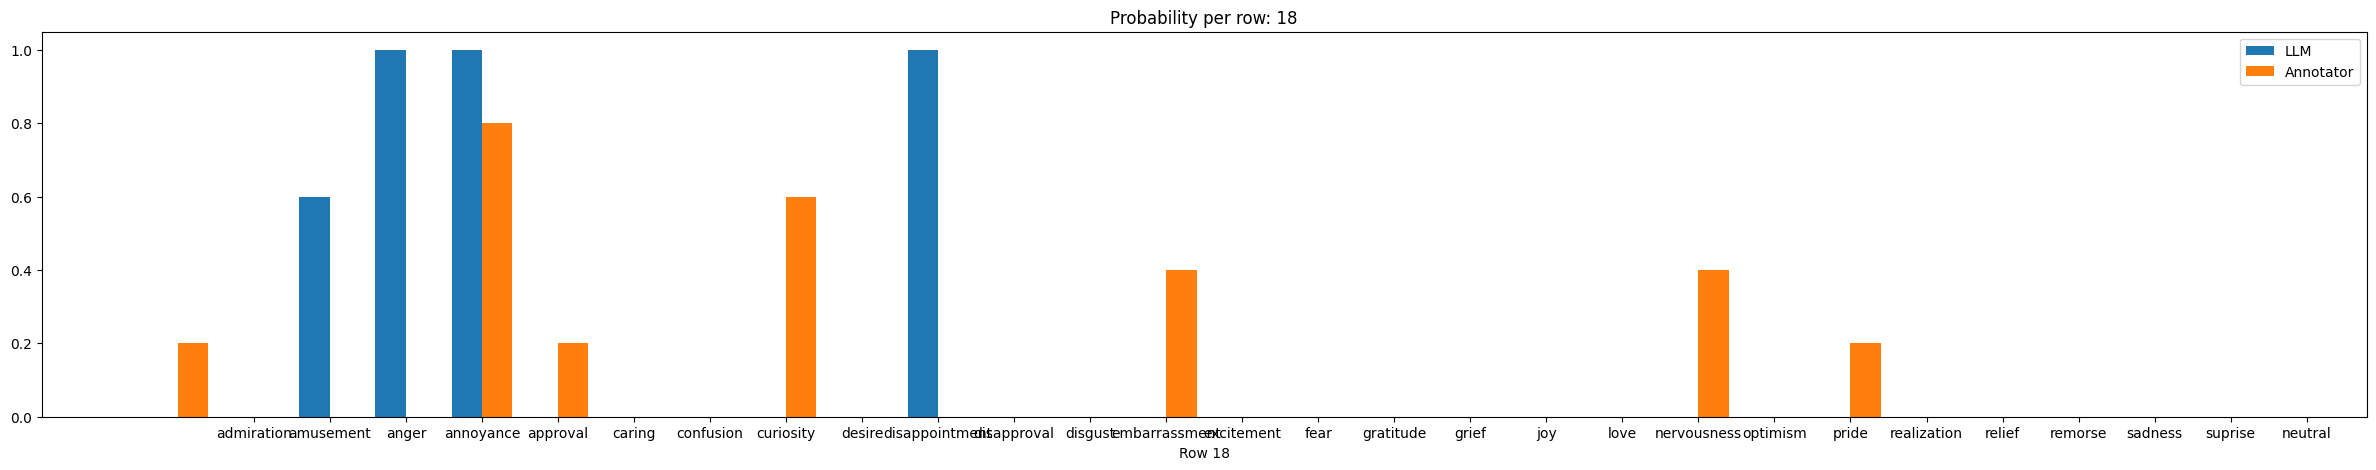

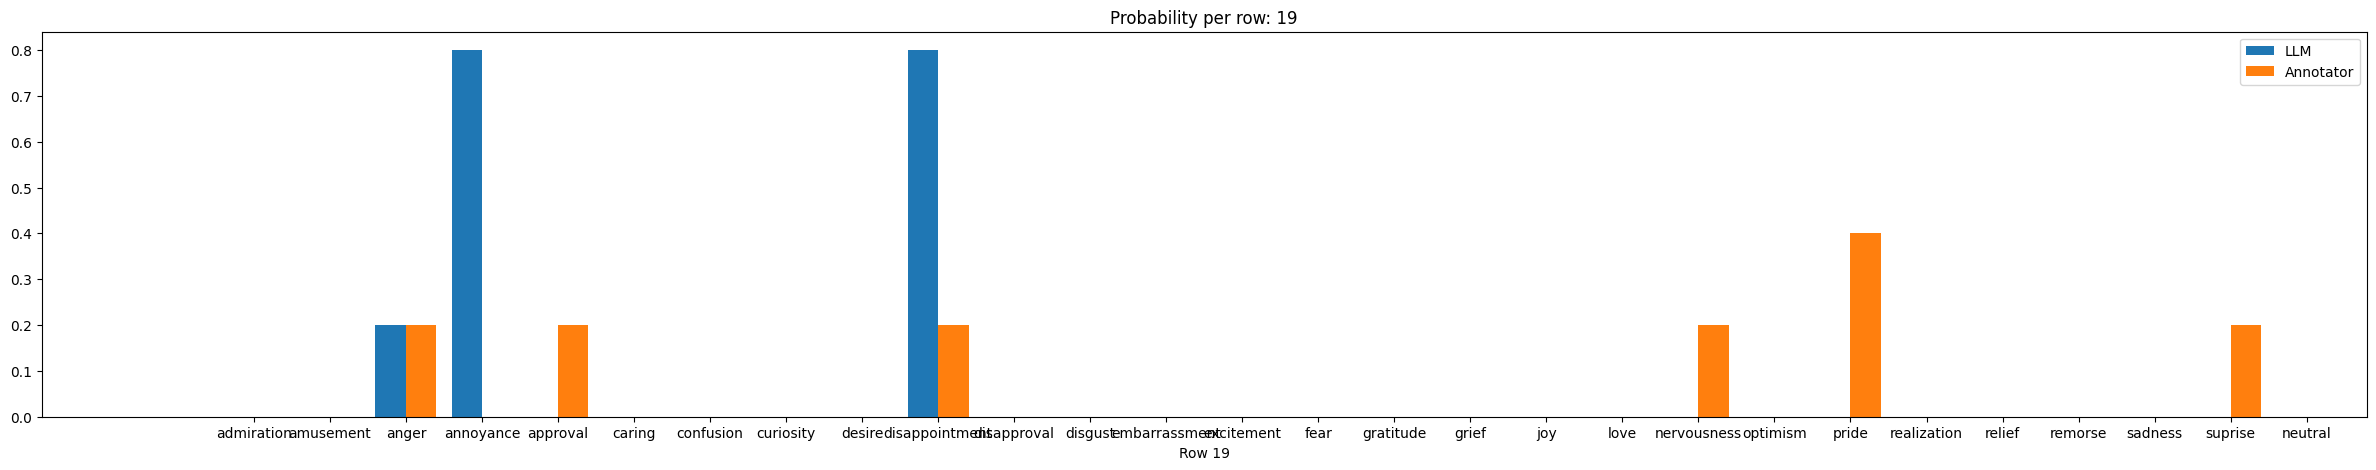

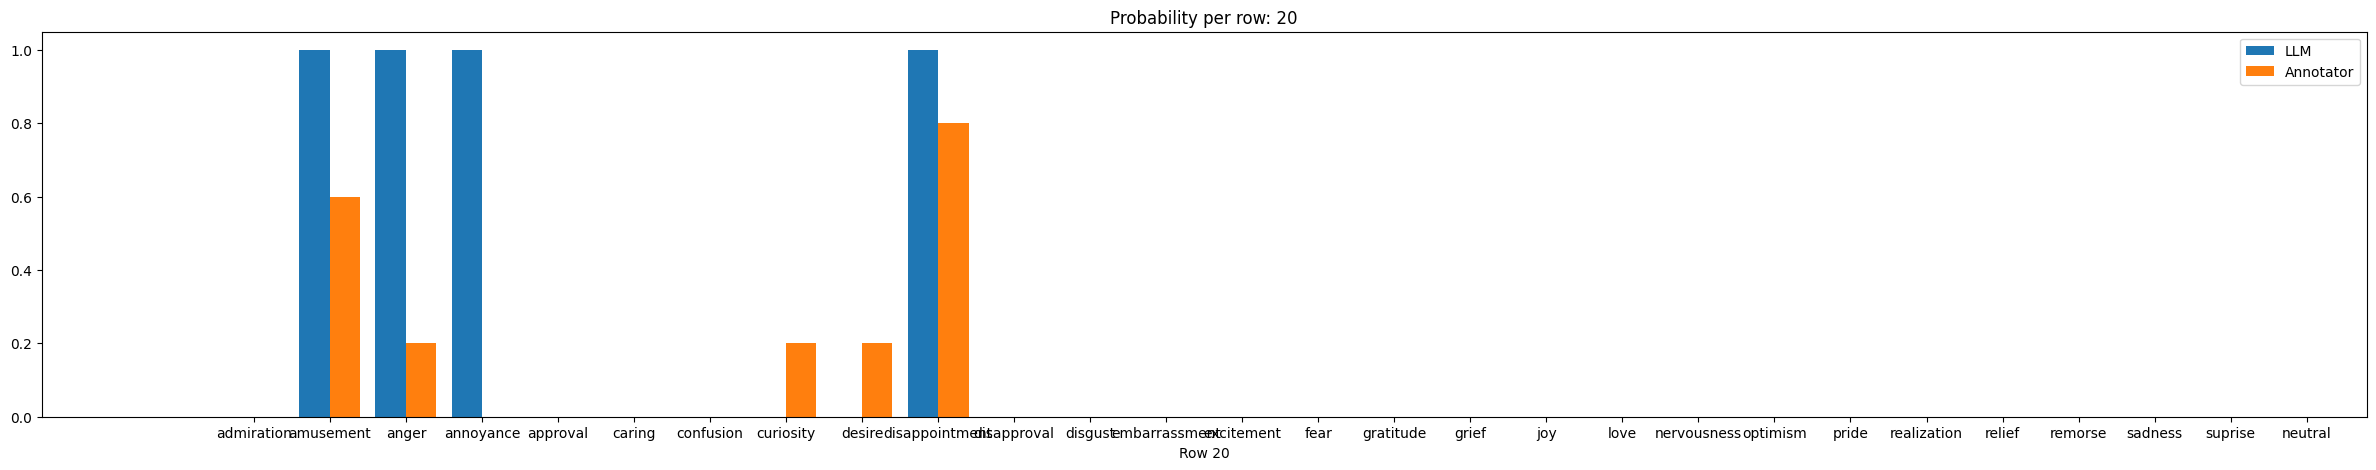

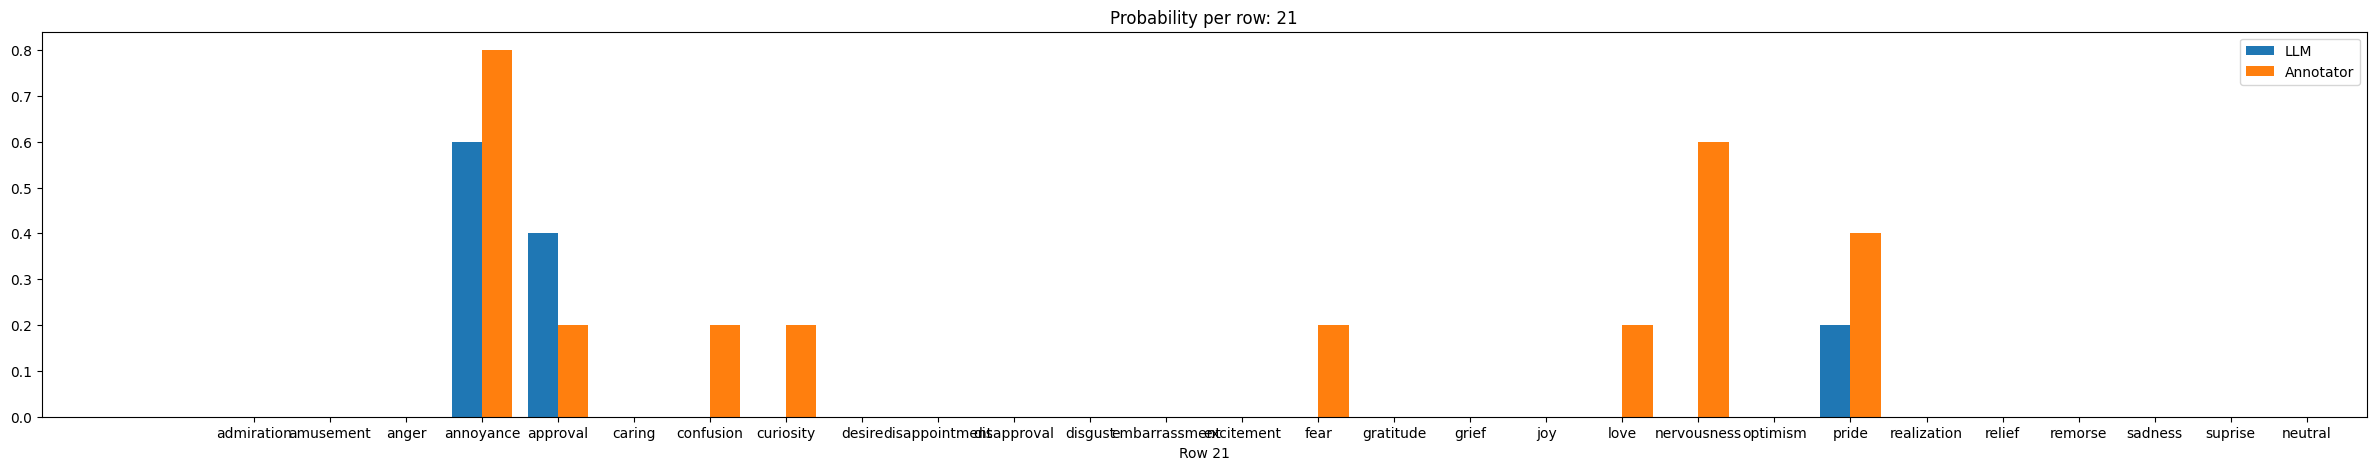

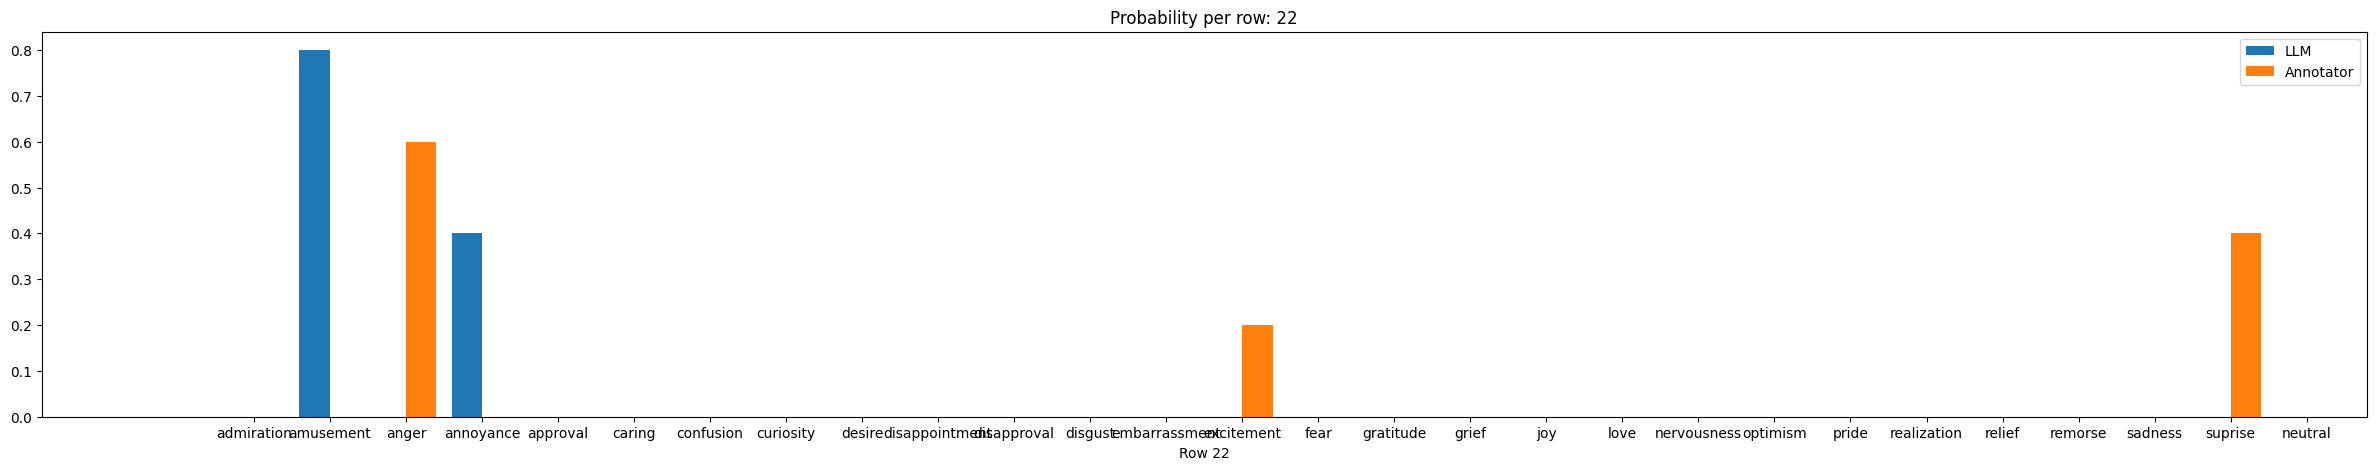

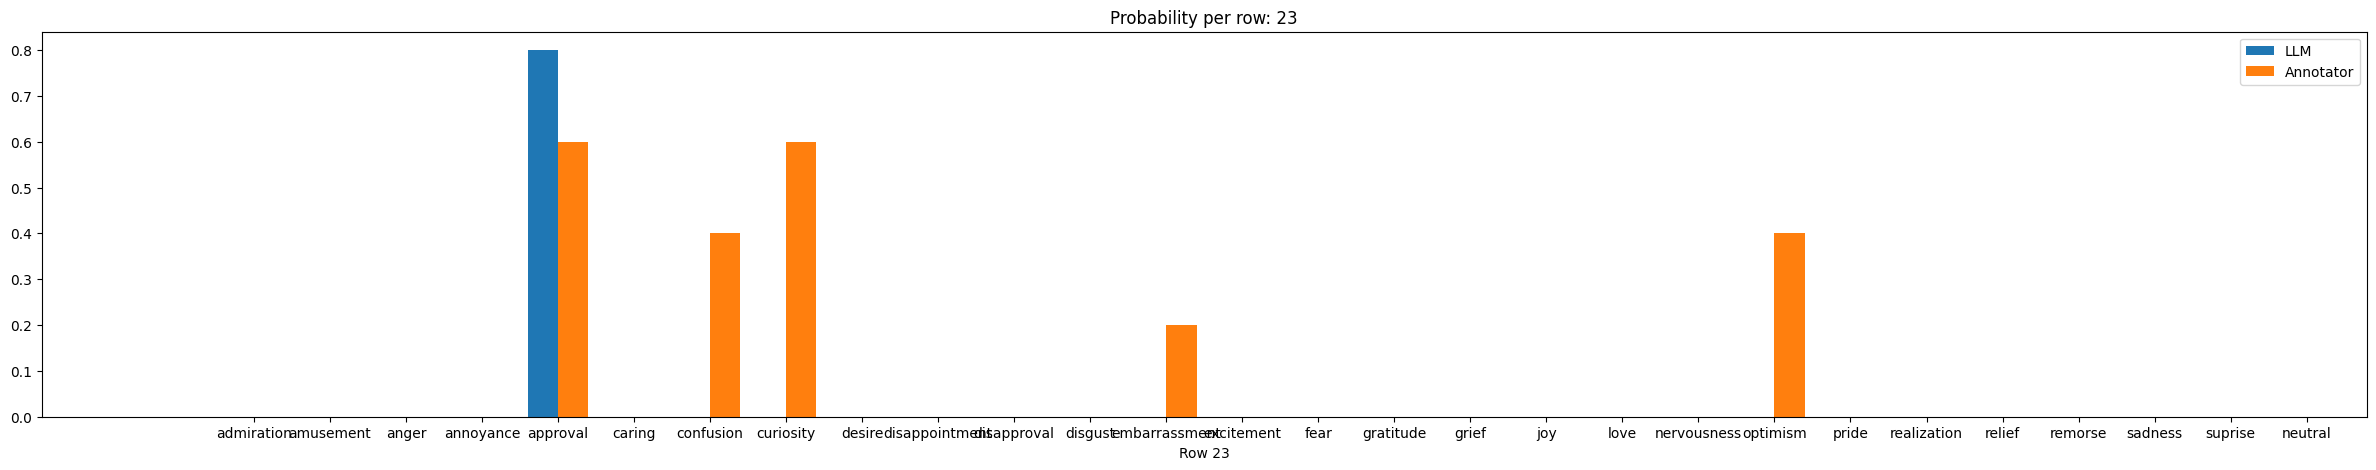

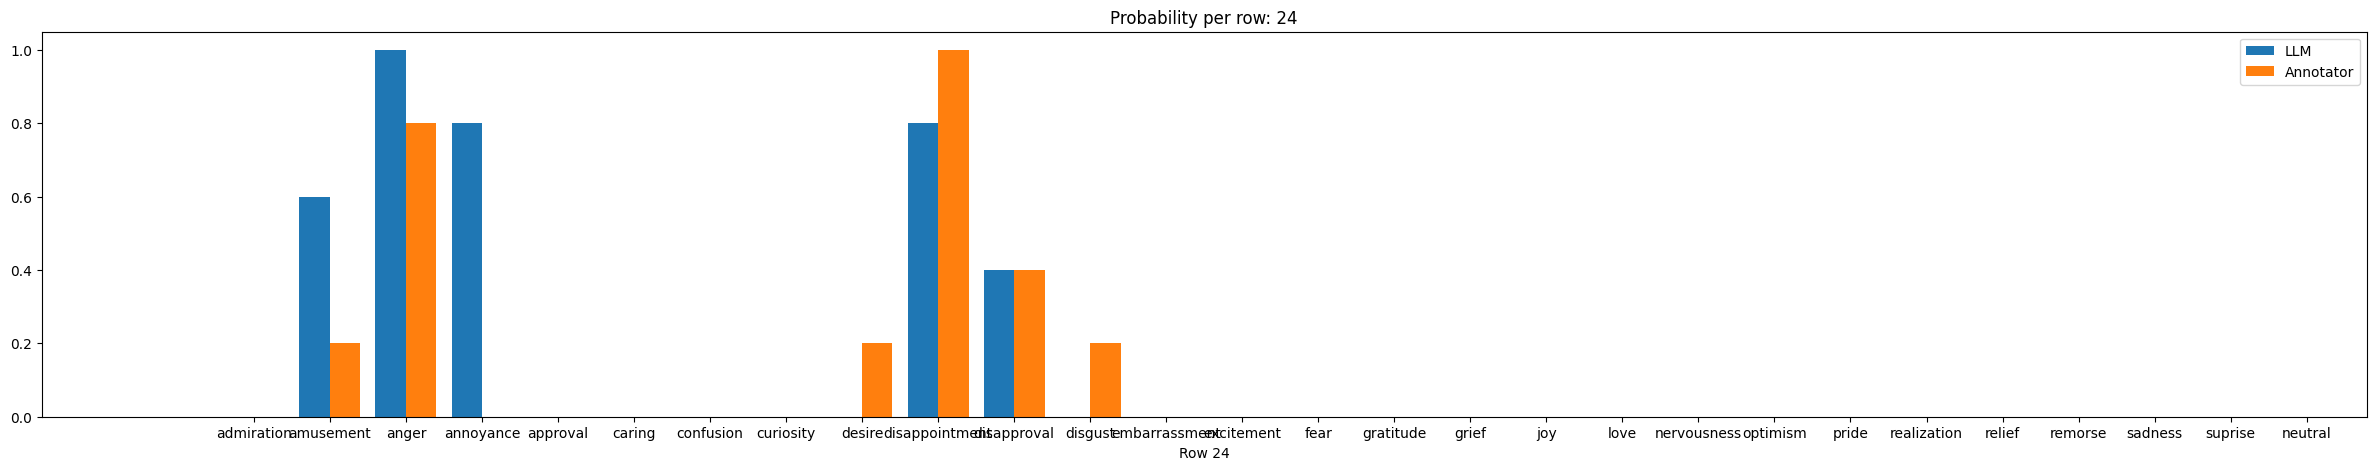

In [52]:
import matplotlib.pyplot as plt
x = []
for label in labelsList:
    x.append(label)

numLabels = []
for i in range(1, 29):
    numLabels.append(i)
X_axis = numpy.arange(len(x)) 

for rowNum in range(0, 25):
    yLLM = numResults["results1"][rowNum]
    zAnnotator = numAnnotated[rowNum]

    fig = plt.figure(figsize = (30, 5))
    plt.bar(X_axis -0.2, yLLM, width=0.4, label = "LLM")
    plt.bar(X_axis +0.2, zAnnotator, width=0.4, label = "Annotator")
    plt.xticks(numLabels, x)
    plt.xlabel("Row " + str(rowNum))
    plt.legend() 
    plt.title("Probability per row: " + str(rowNum))
    plt.show()

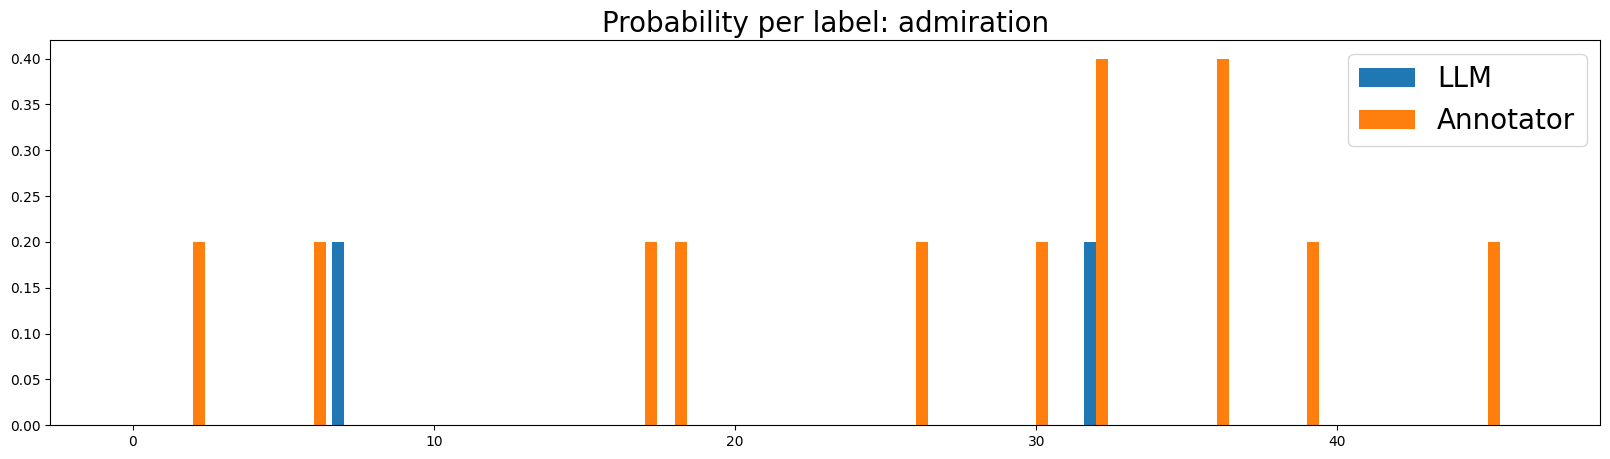

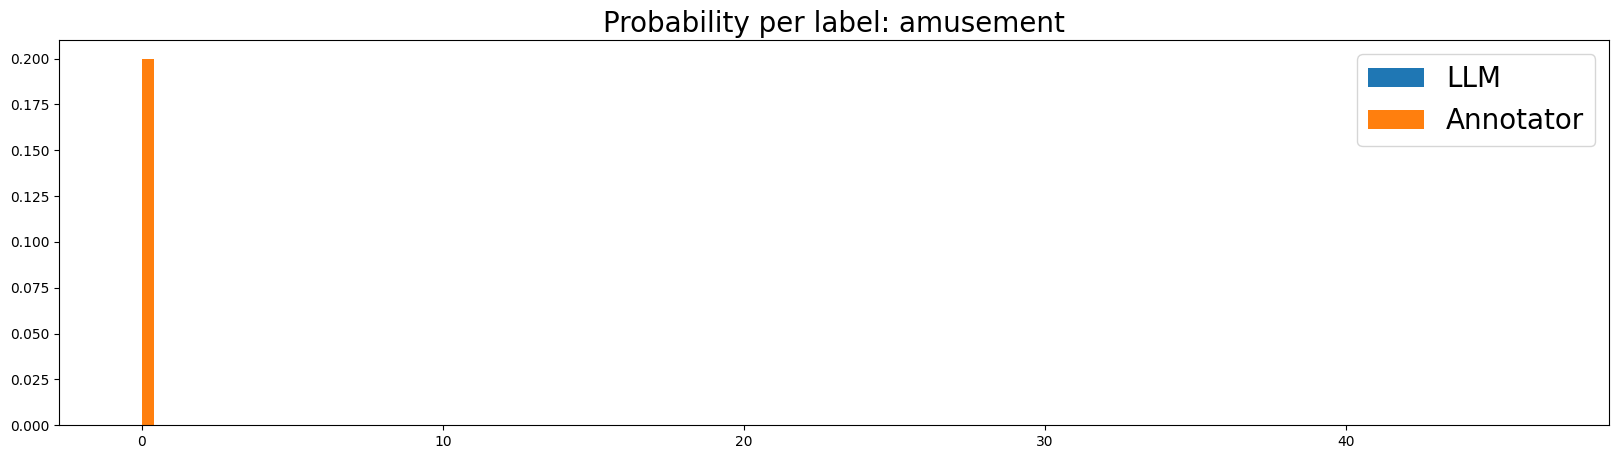

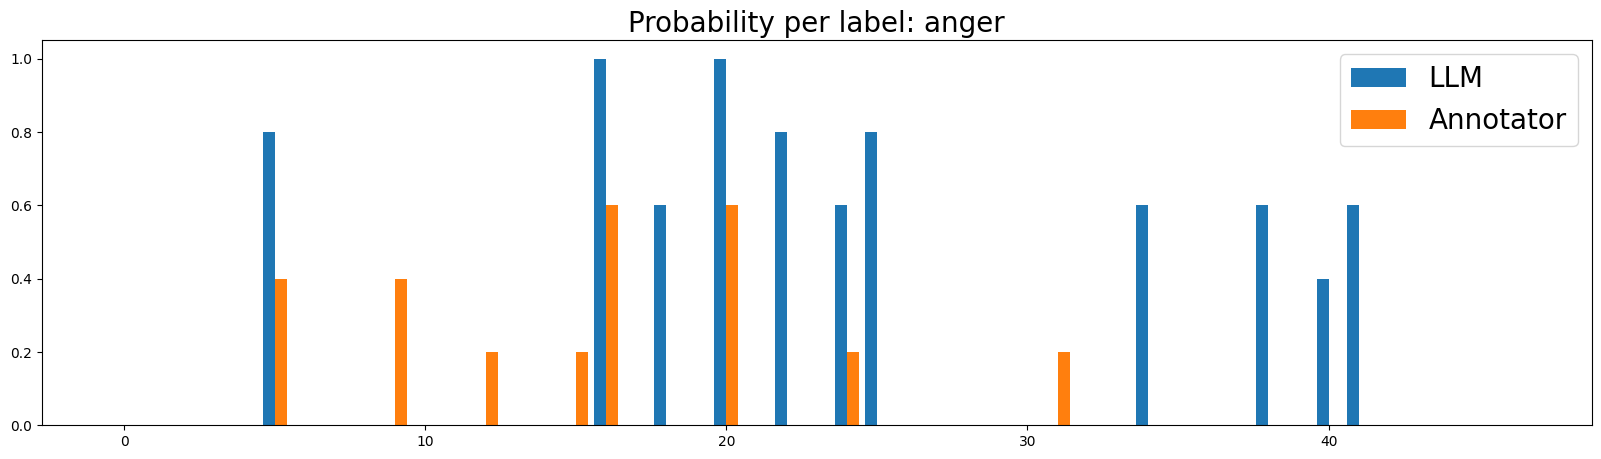

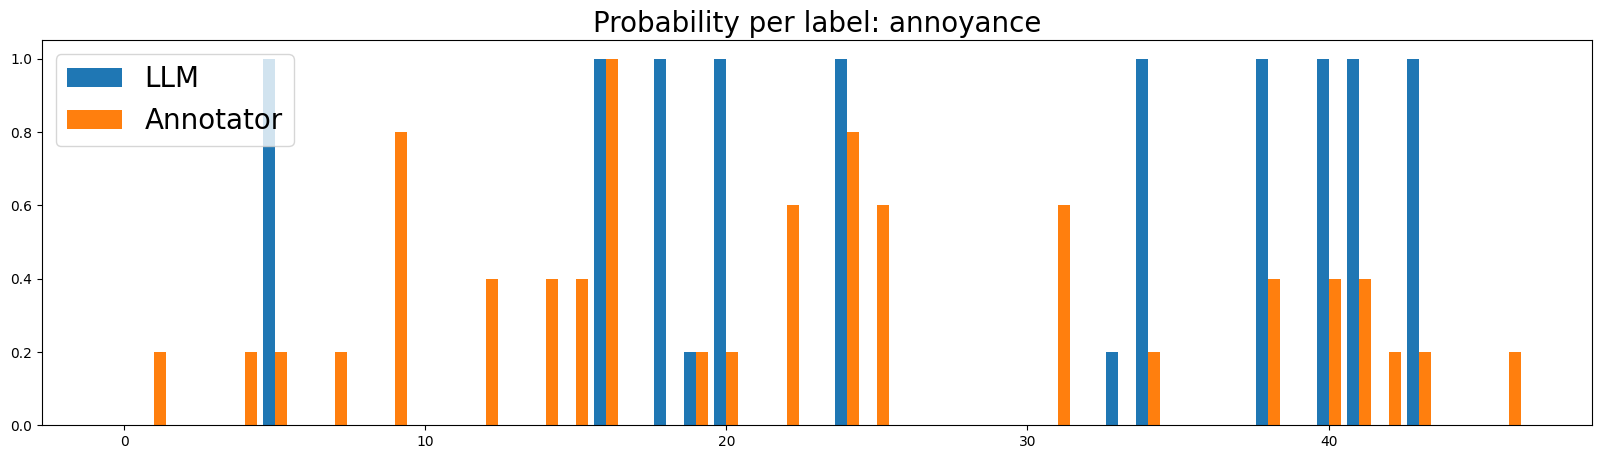

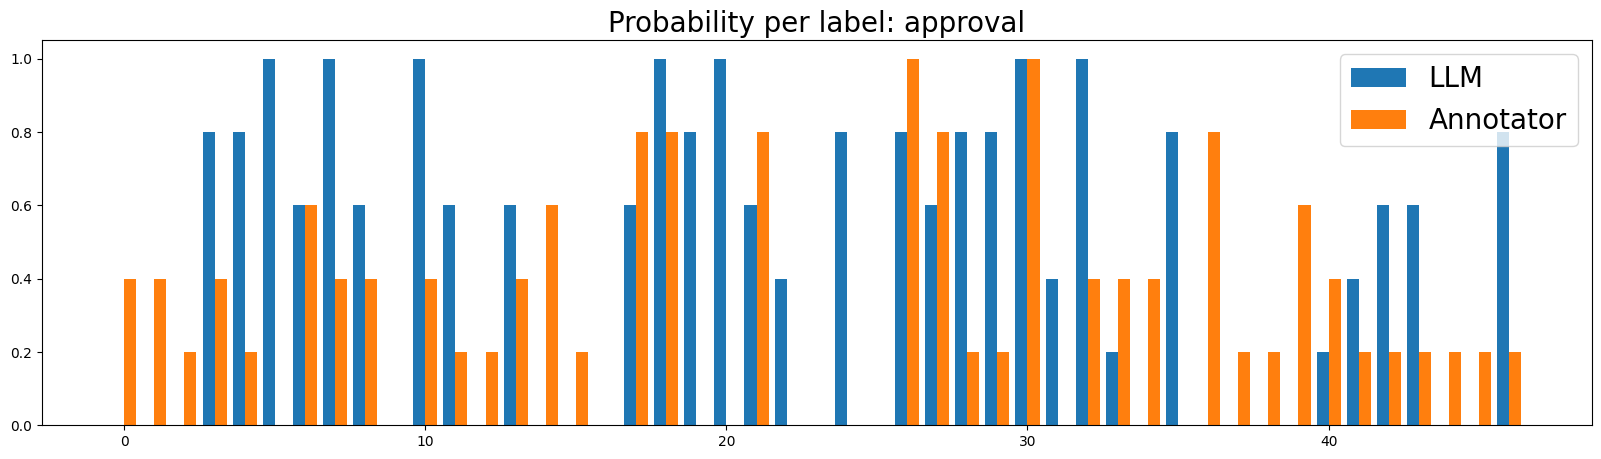

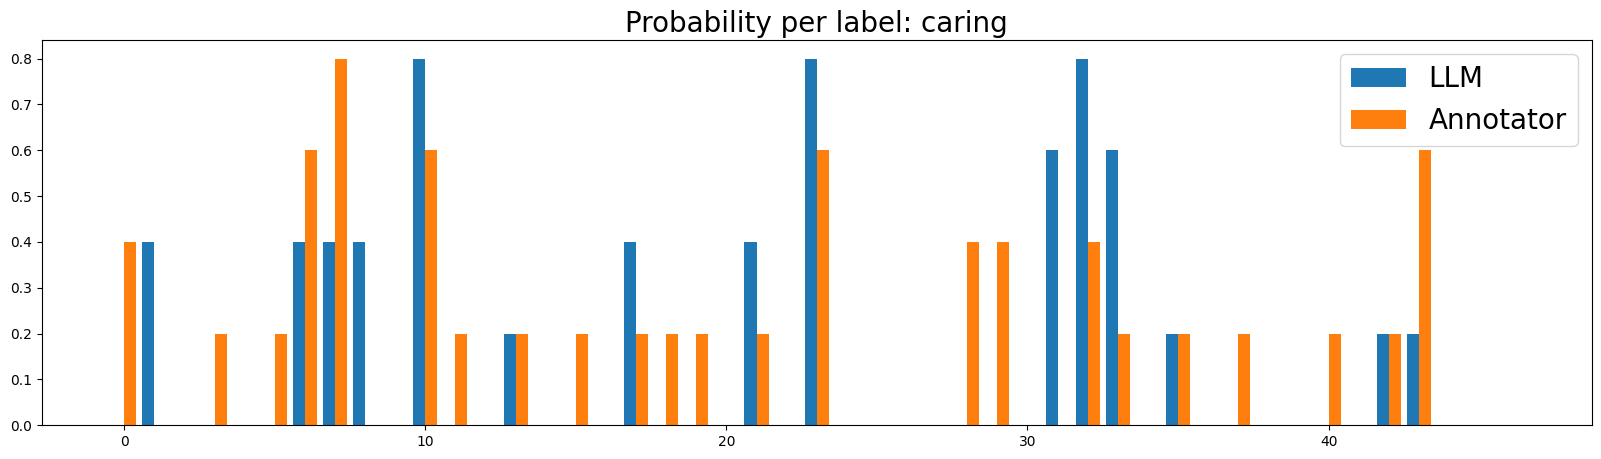

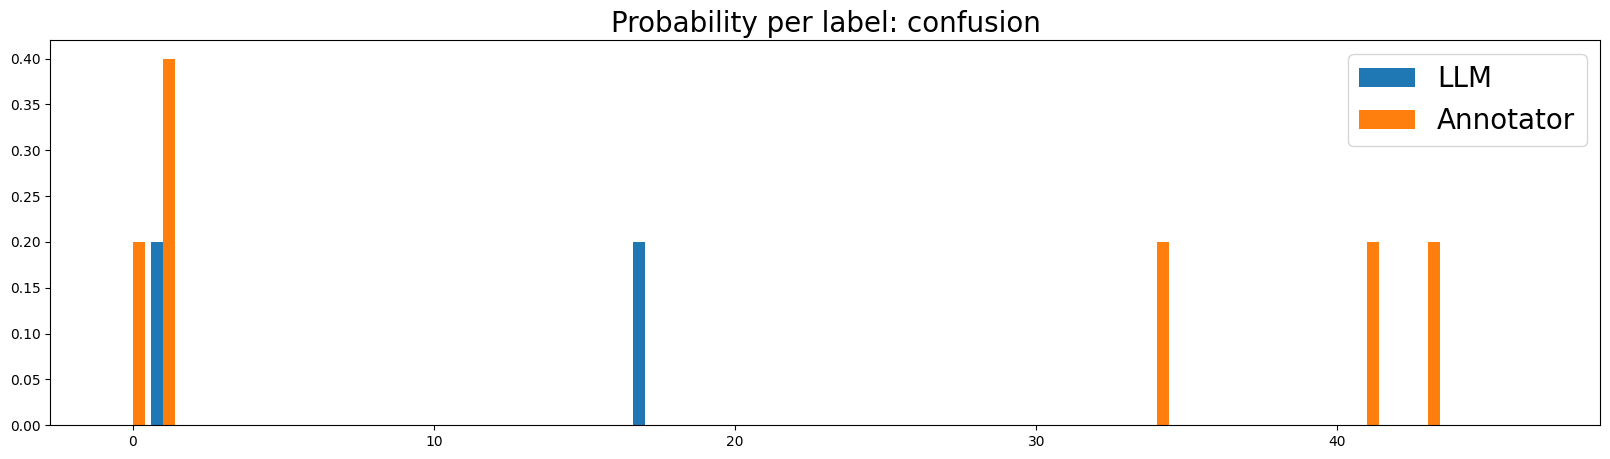

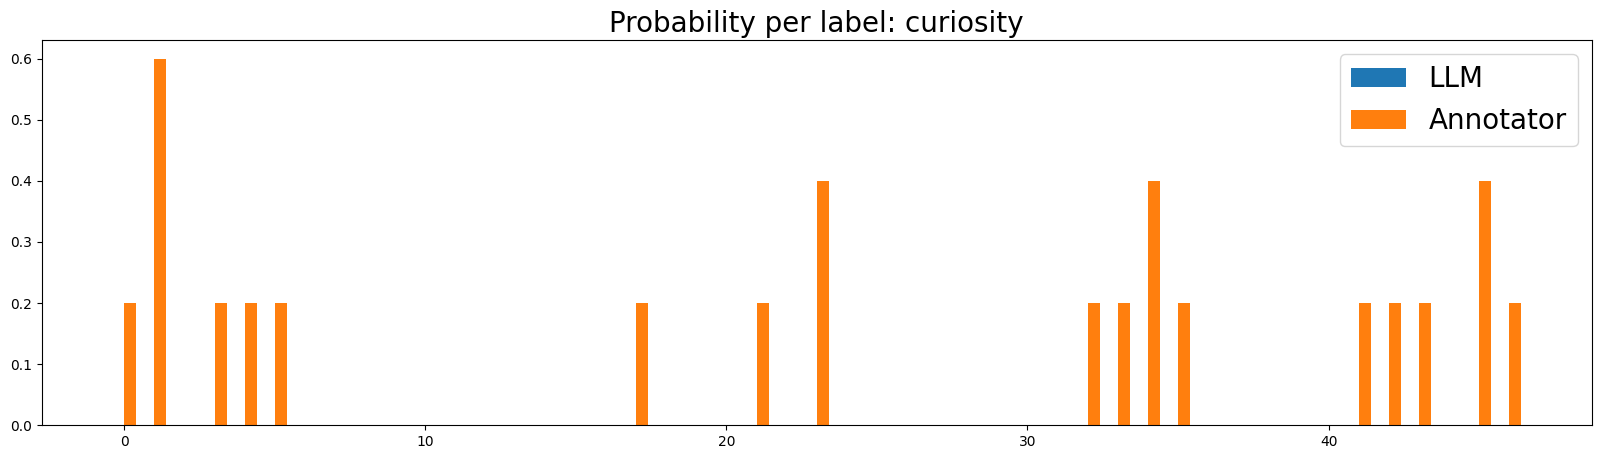

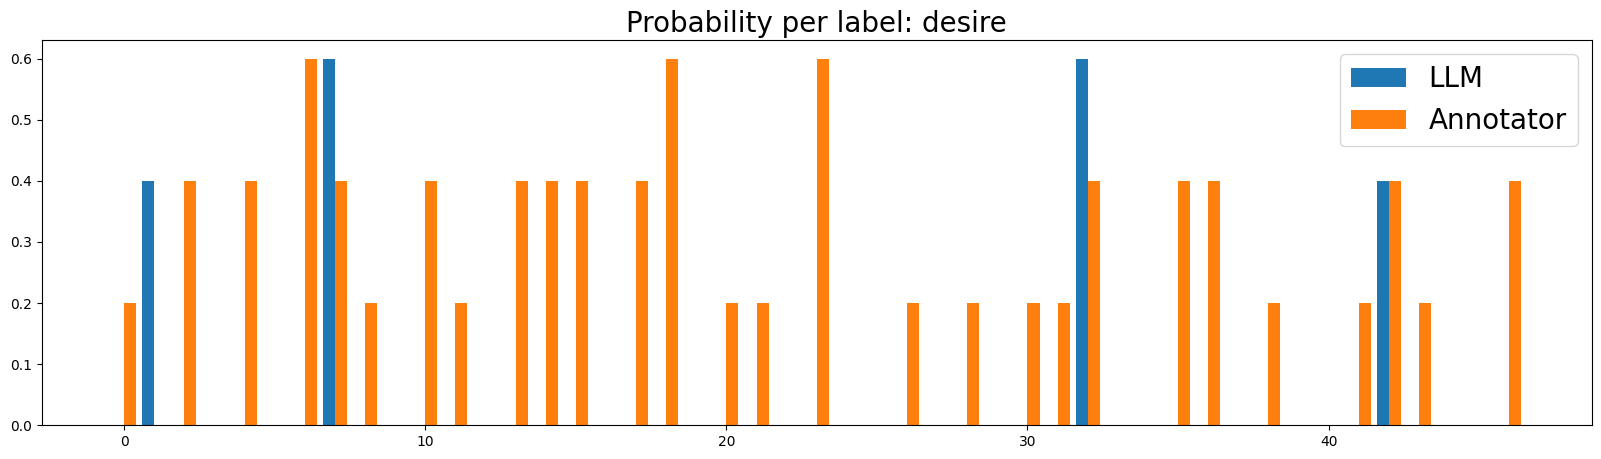

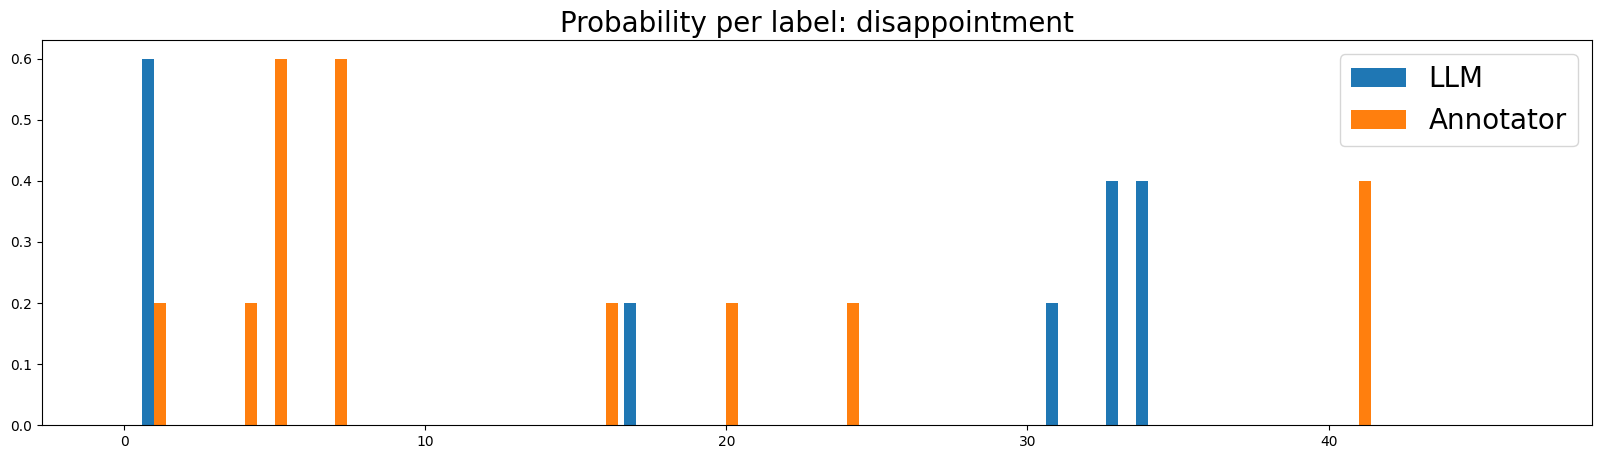

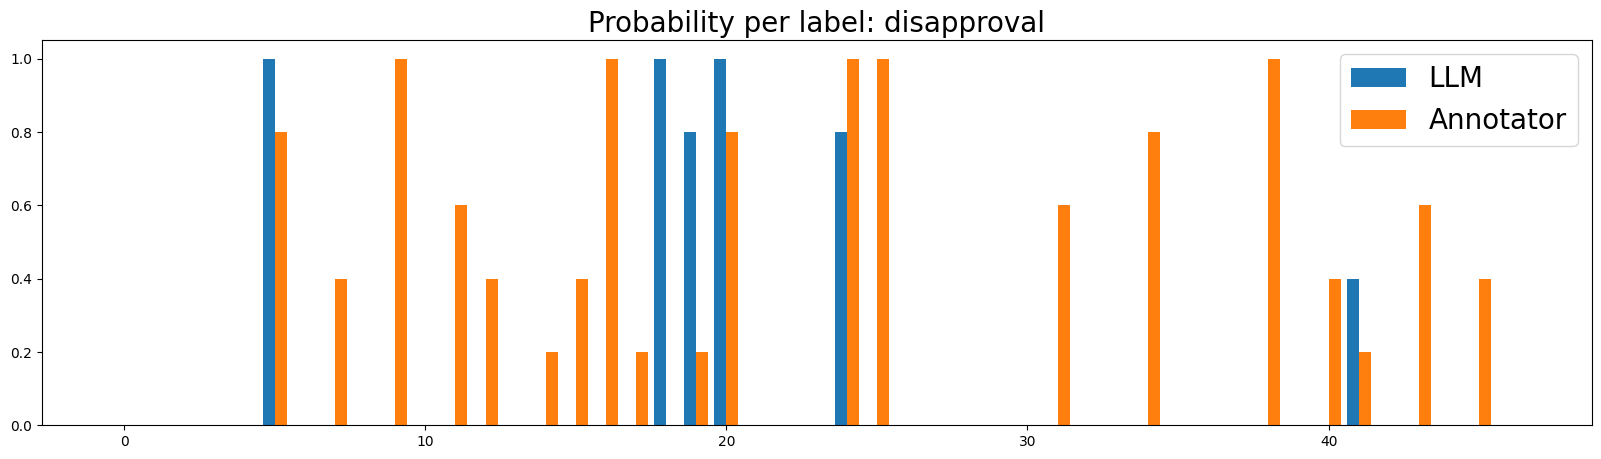

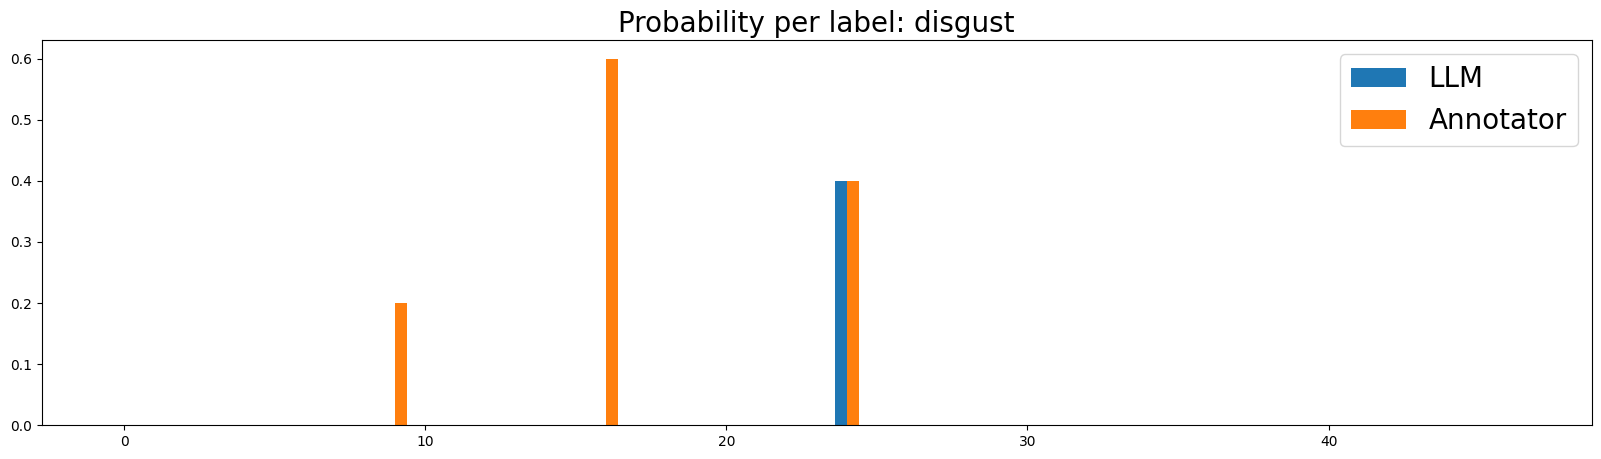

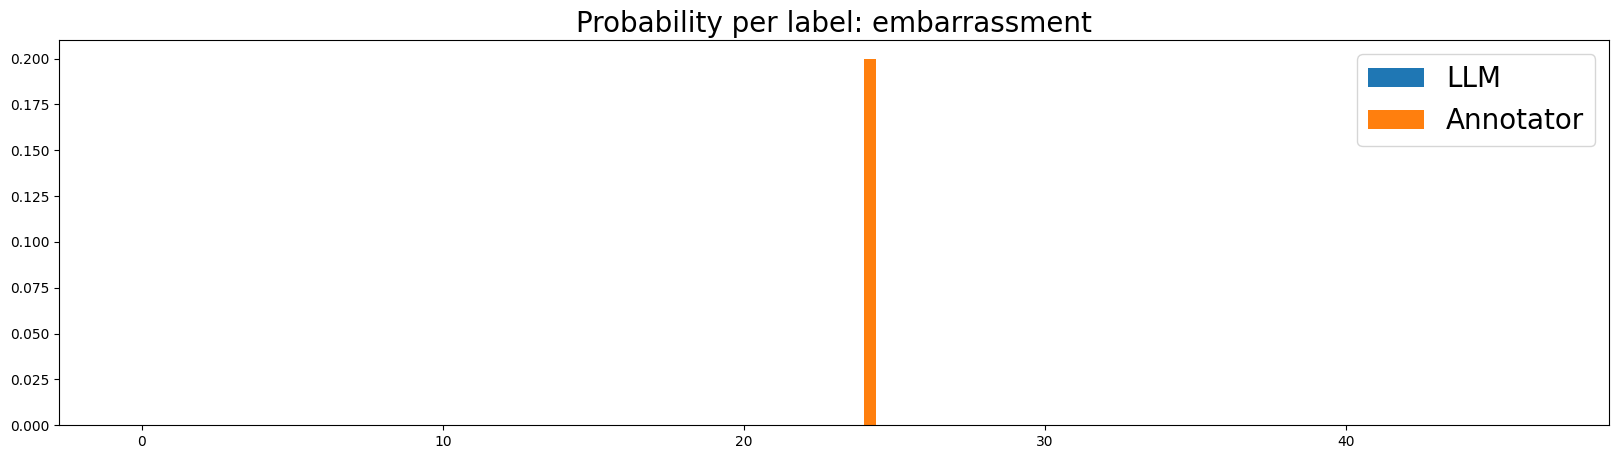

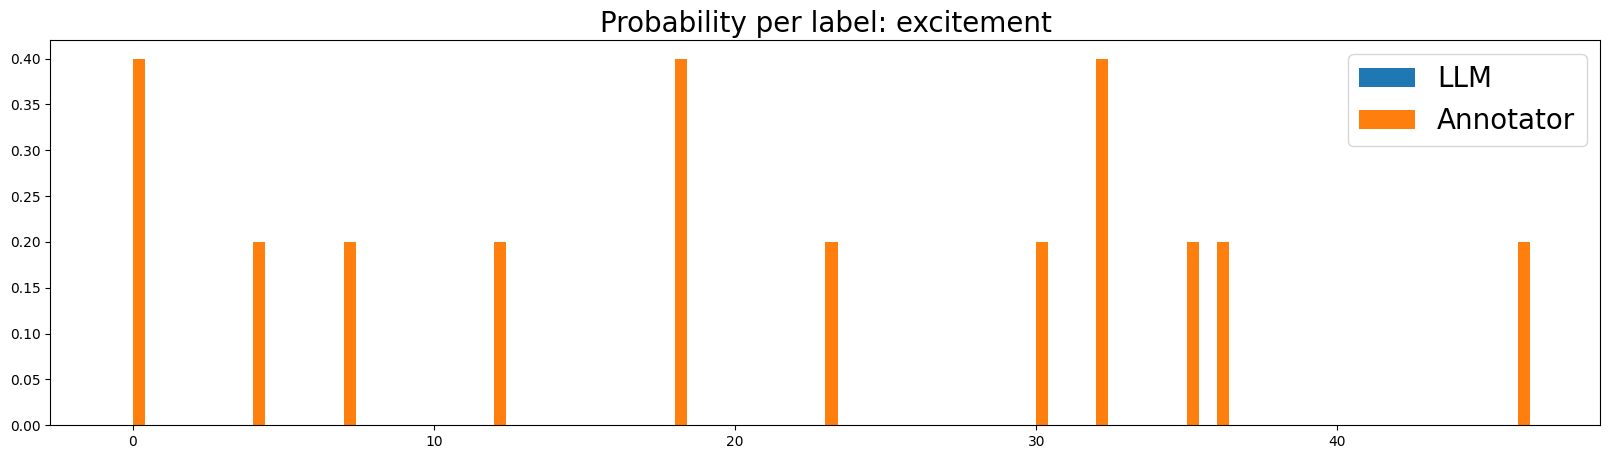

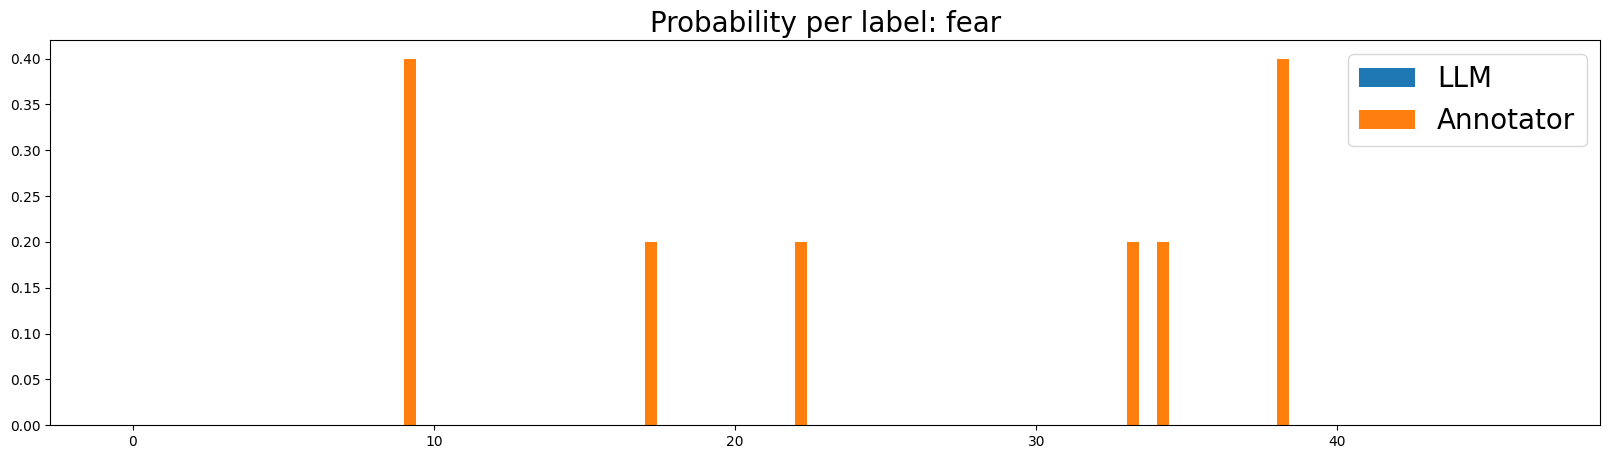

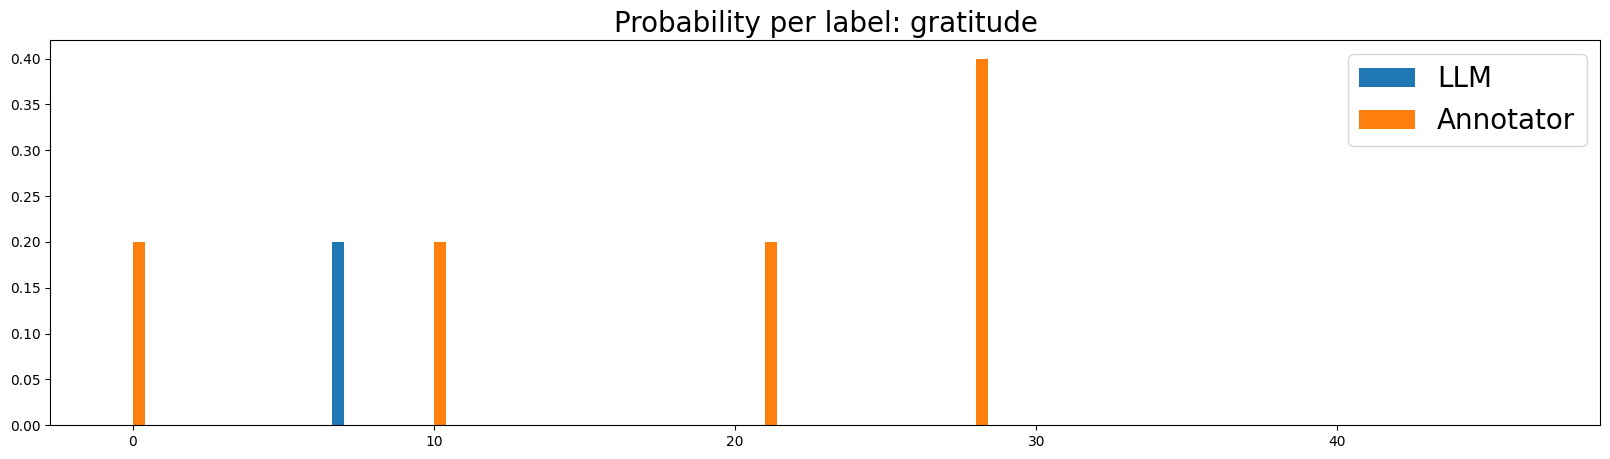

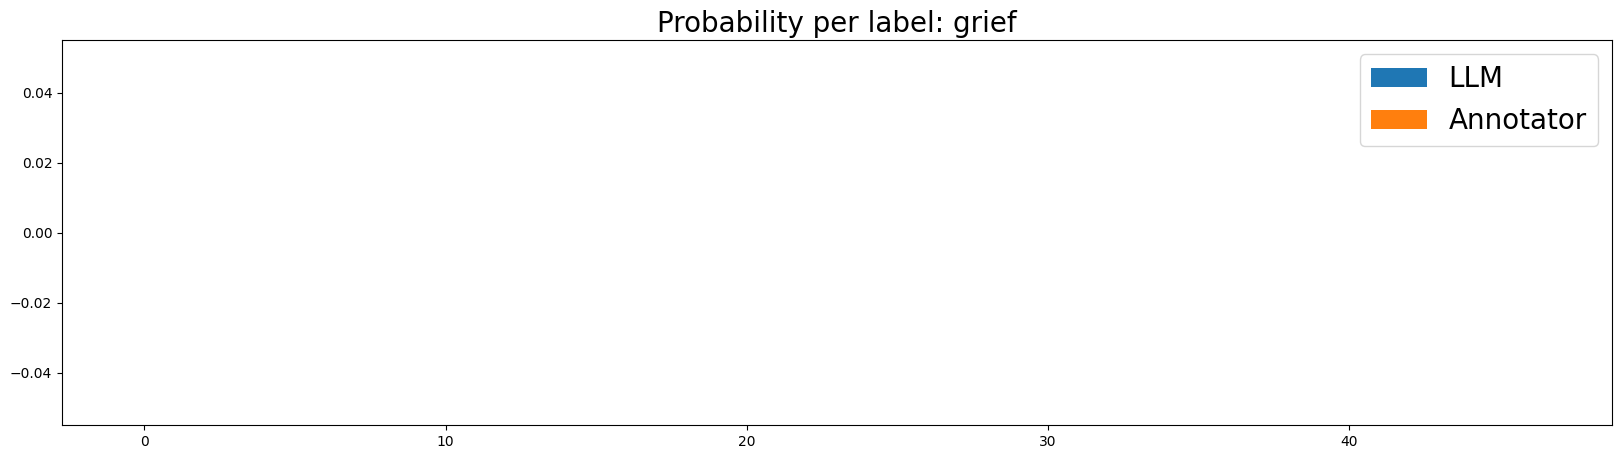

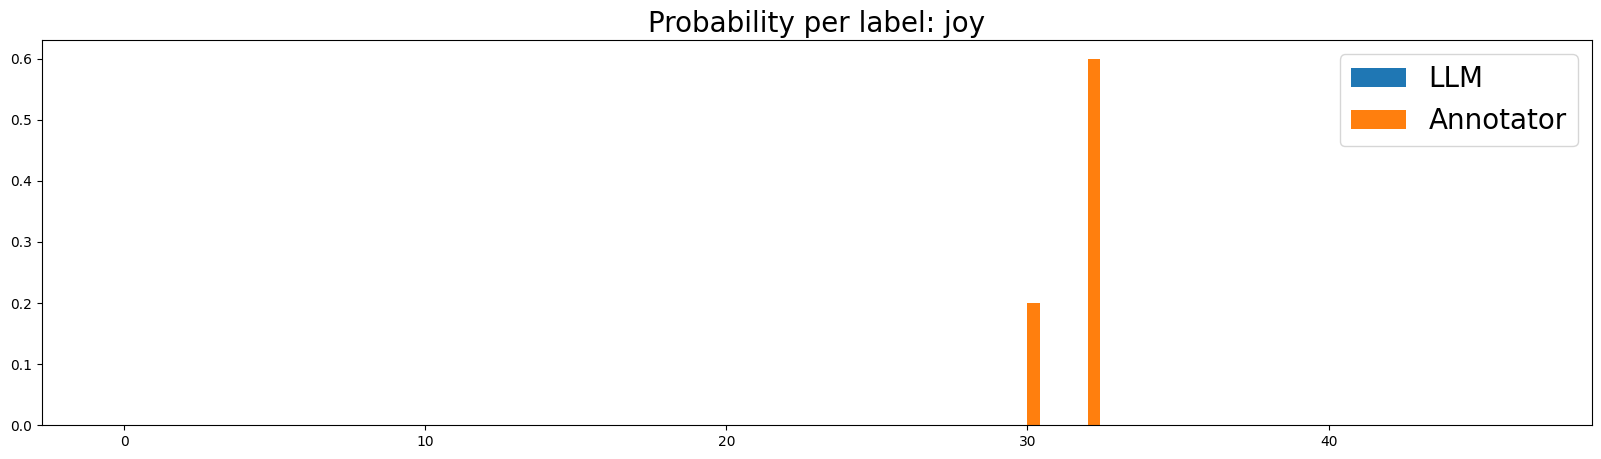

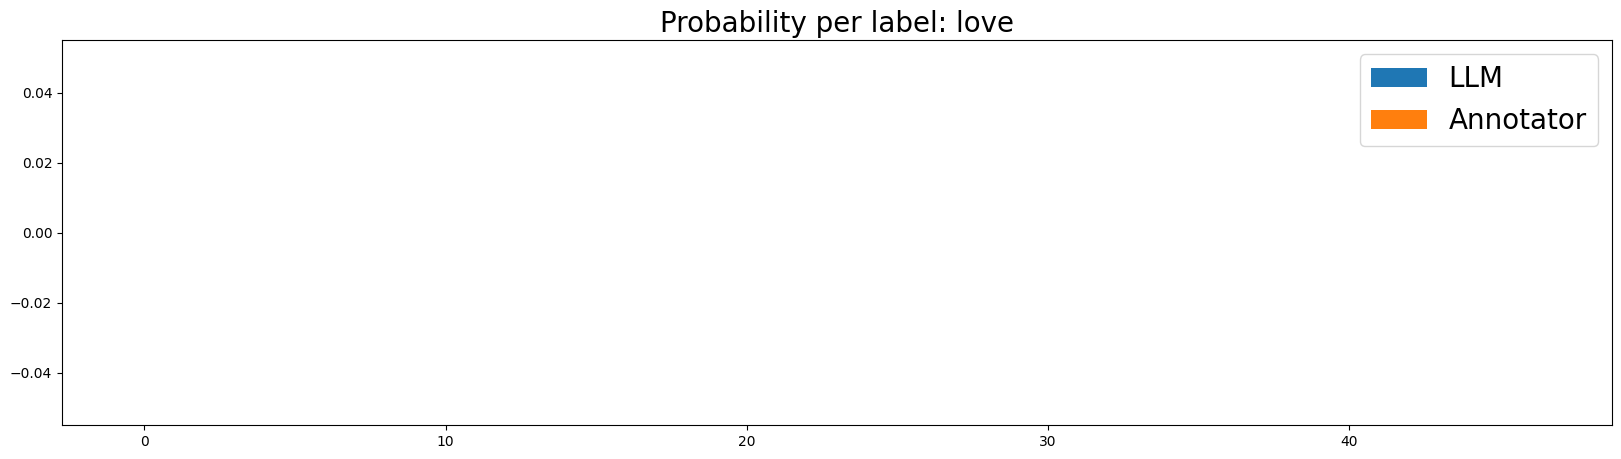

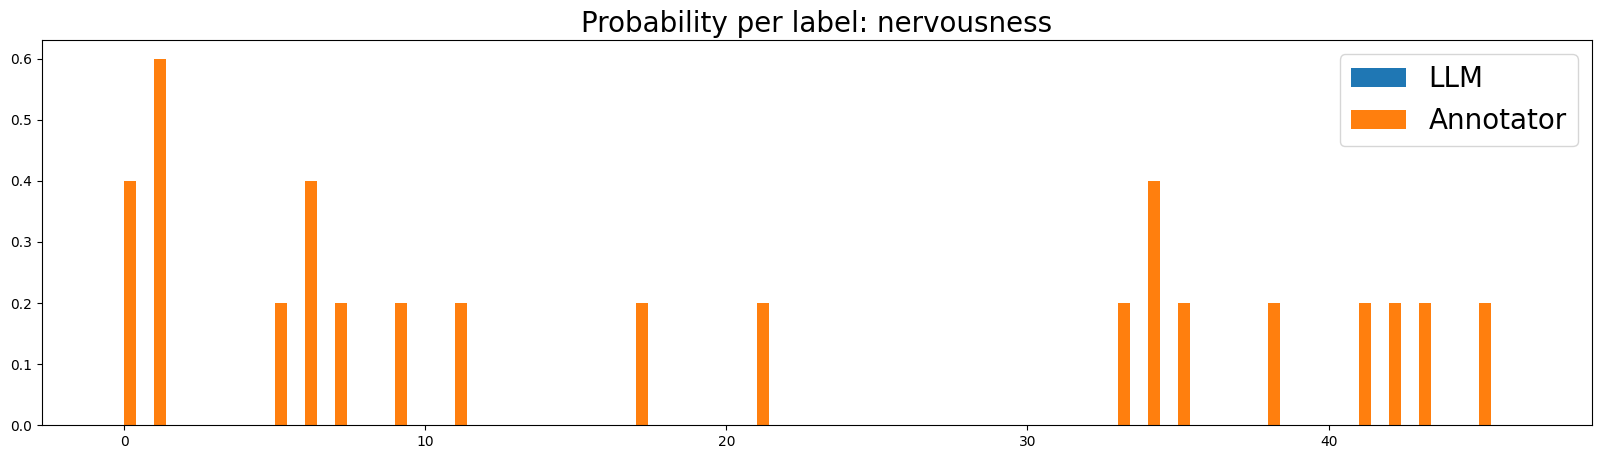

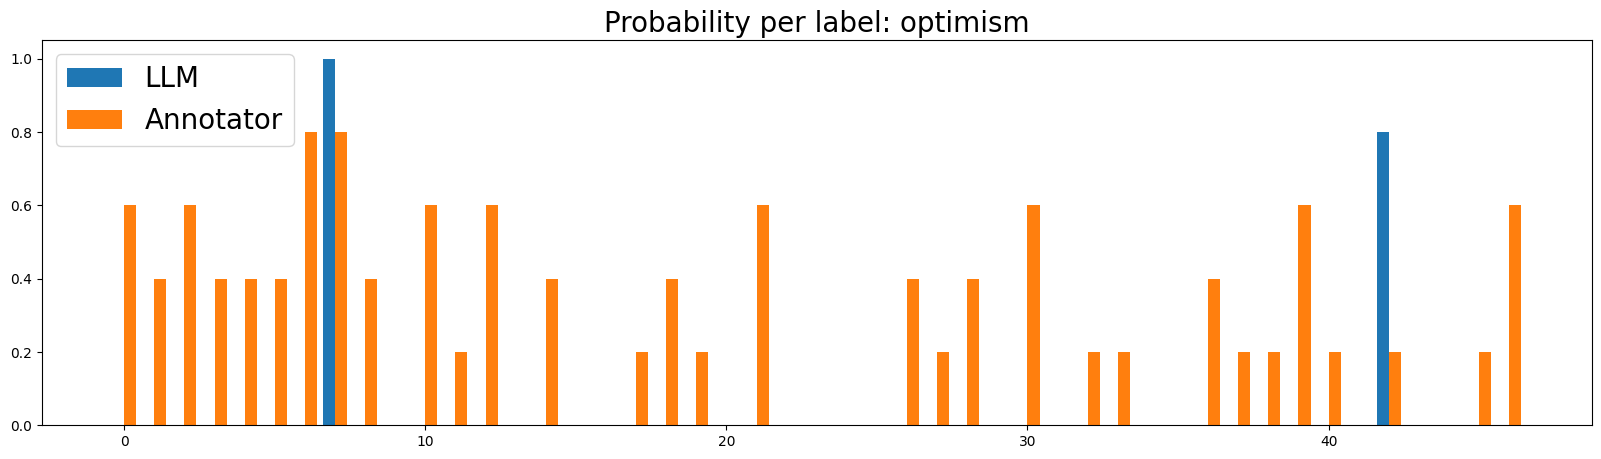

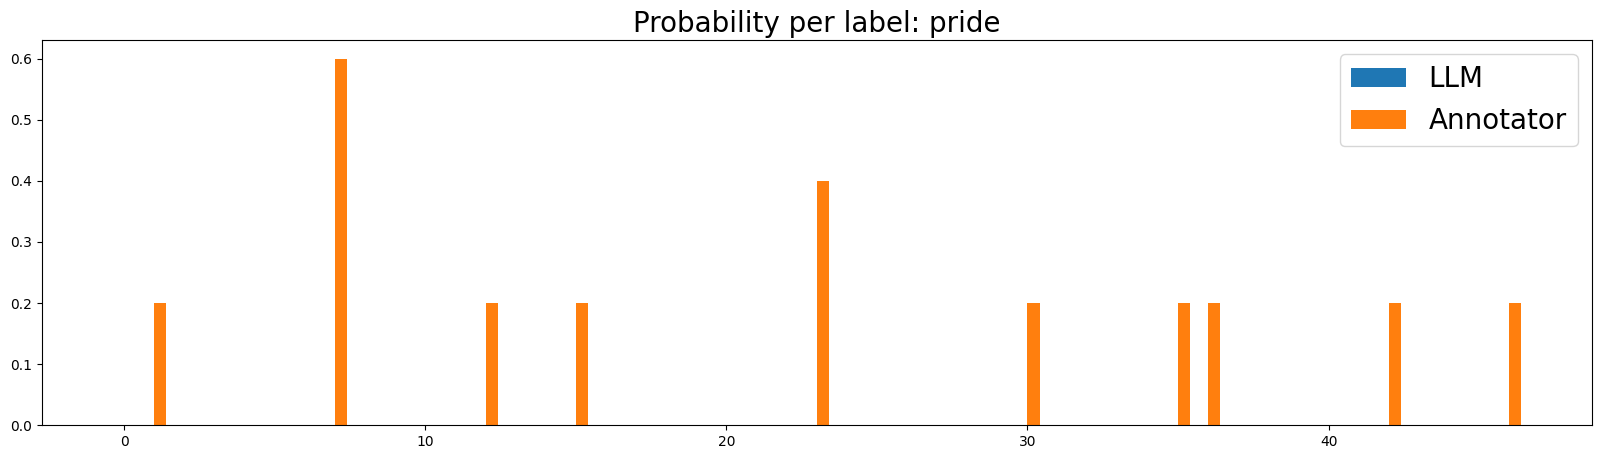

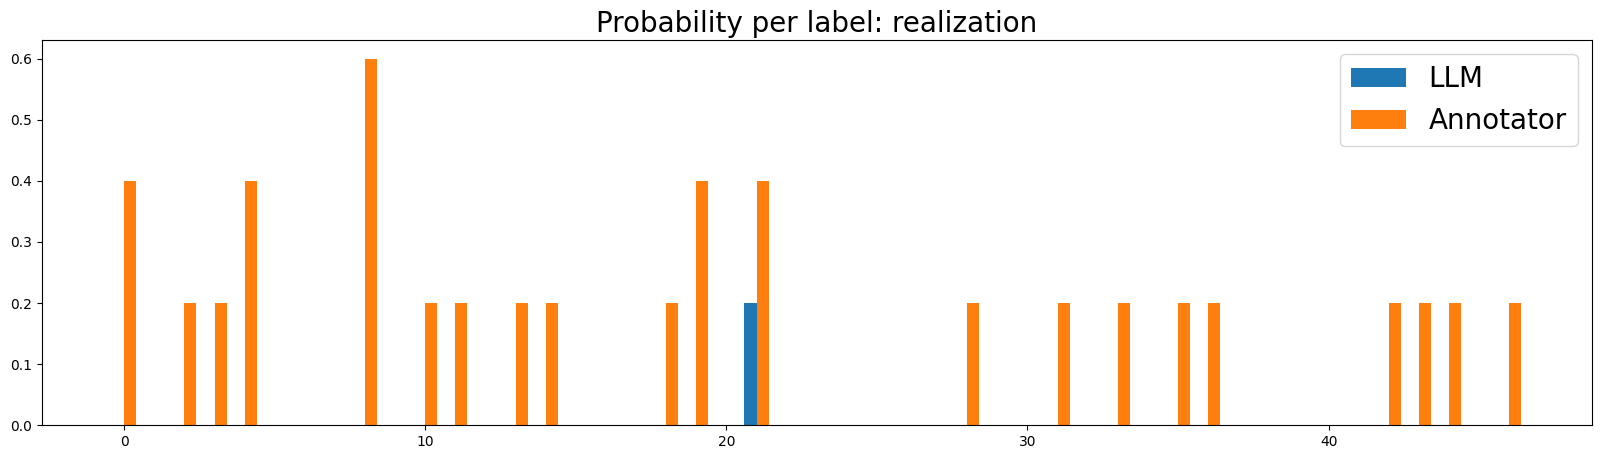

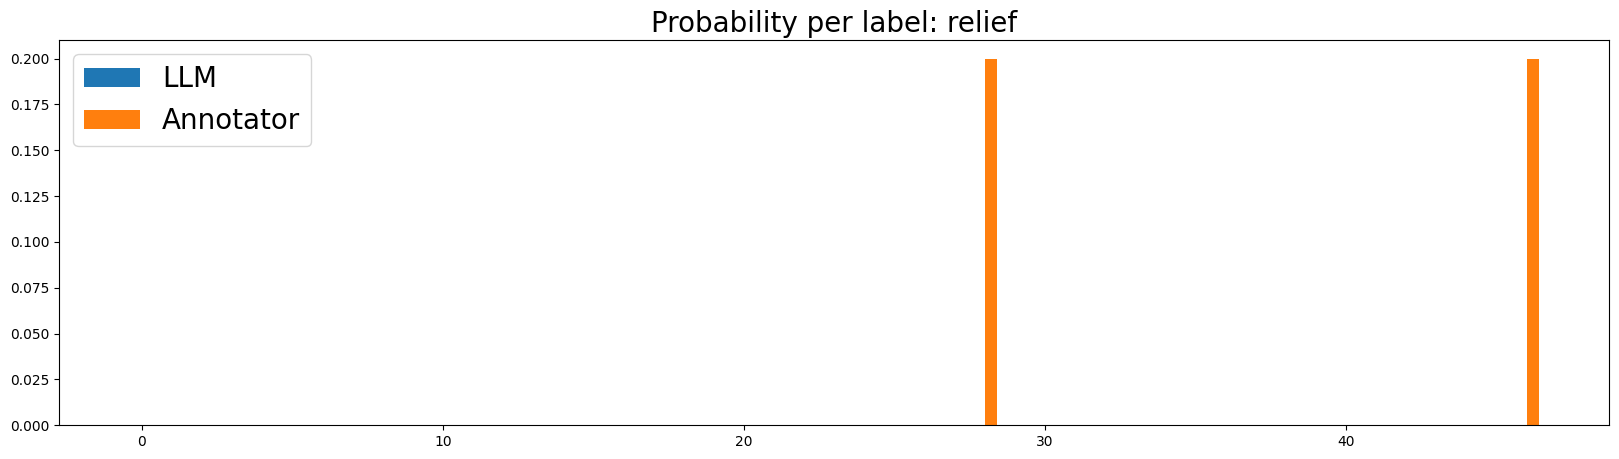

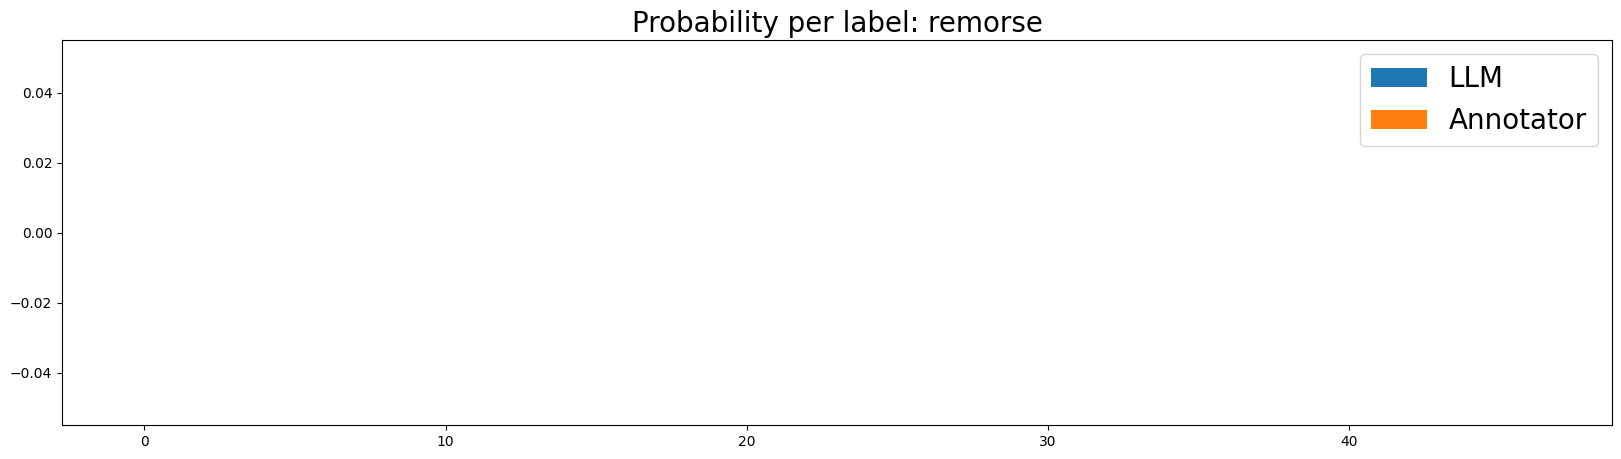

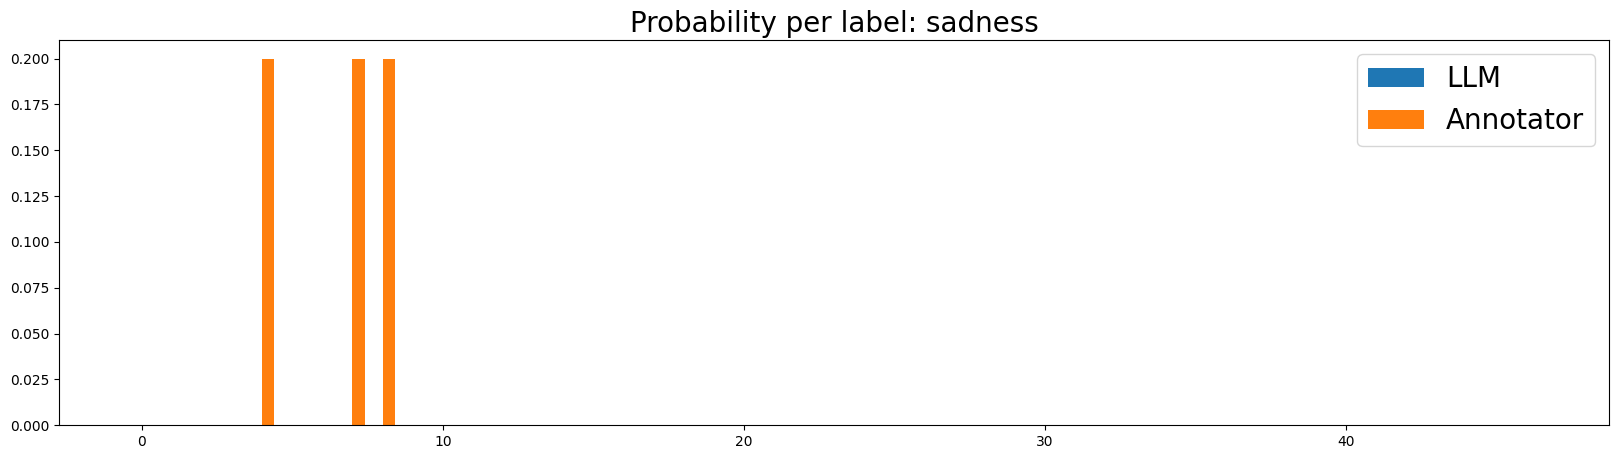

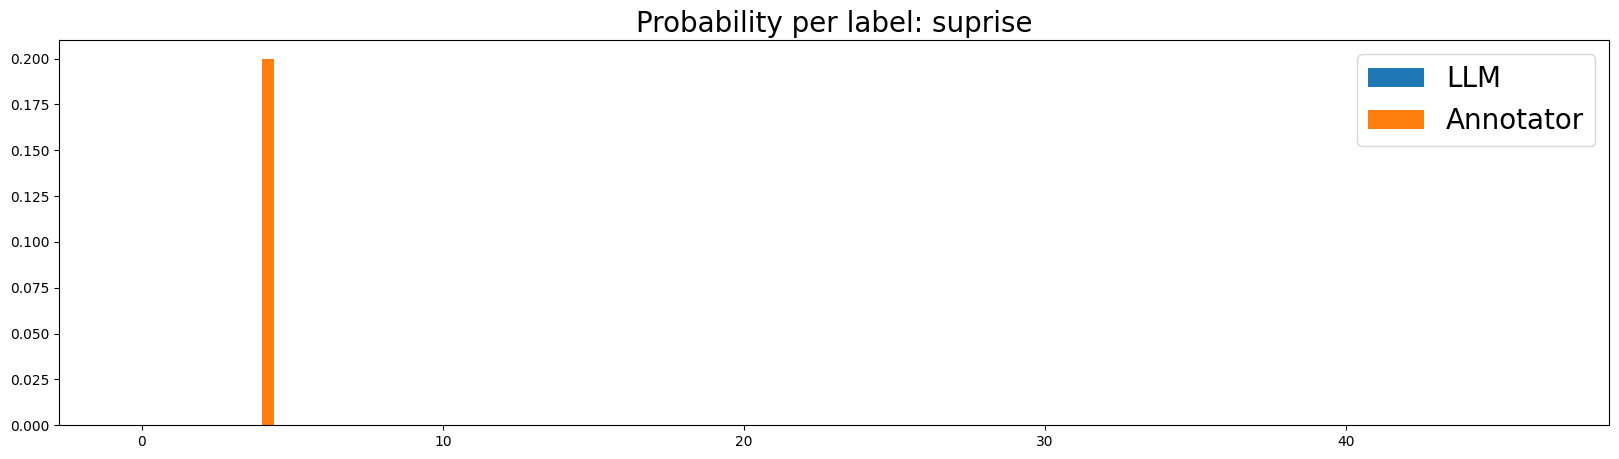

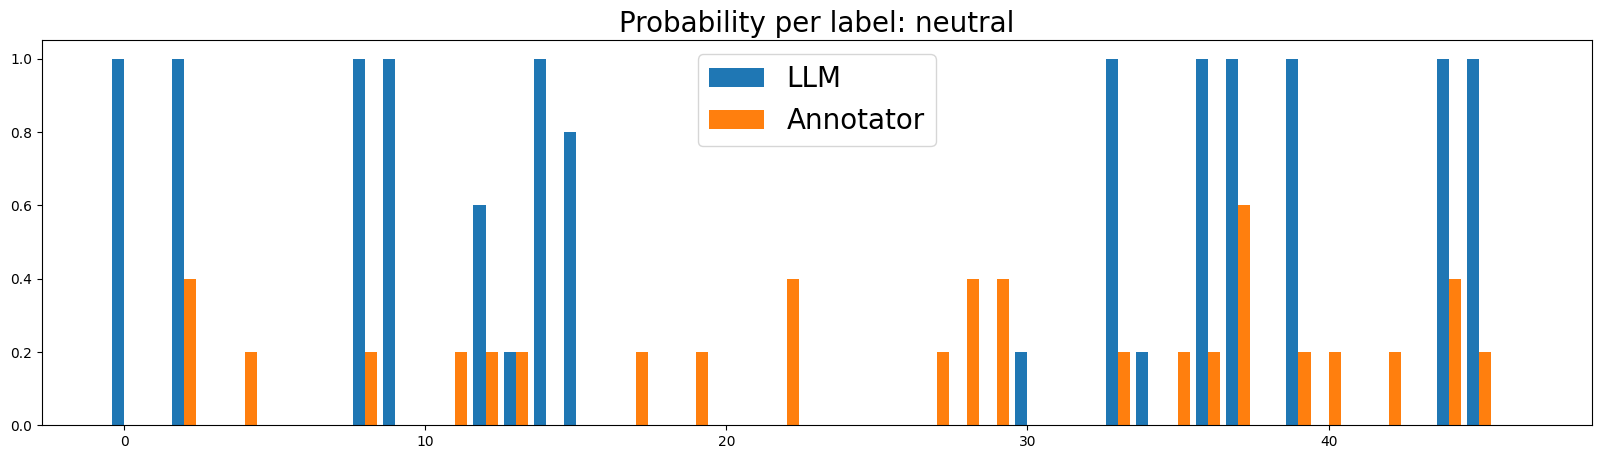

In [53]:
import matplotlib.pyplot as plt
for i in range(0, 28):
    x = []
    for n in range(0, 47):
        x.append("Row " + str(n))
    
    X_axis = numpy.arange(len(x)) 
    yLLM = numResults["results1"][:,i]
    zAnnotator = numAnnotated[:,i]
    fig = plt.figure(figsize = (20, 5))
    plt.bar(X_axis -0.2, yLLM, width=0.4, label = "LLM")
    plt.bar(X_axis +0.2, zAnnotator, width=0.4, label = "Annotator")
    axisLabel = labelsList[i]
    # plt.xlabel(axisLabel, fontsize=25)
    plt.legend(fontsize=20) 
    plt.title("Probability per label: " + labelsList[i], fontsize=20)
    plt.show()

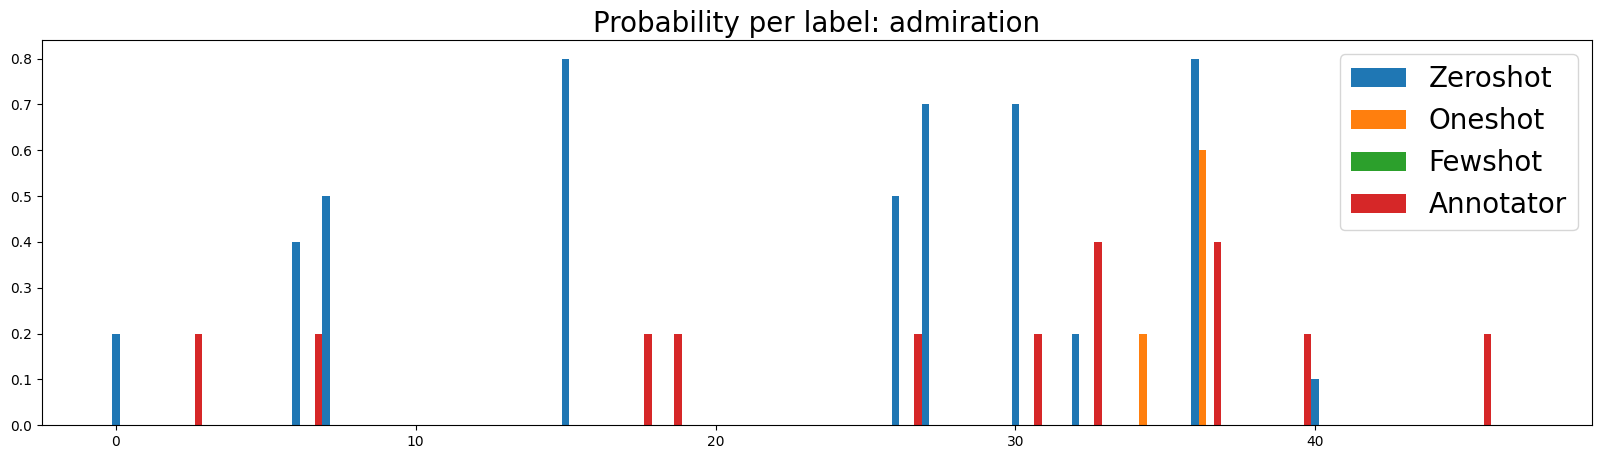

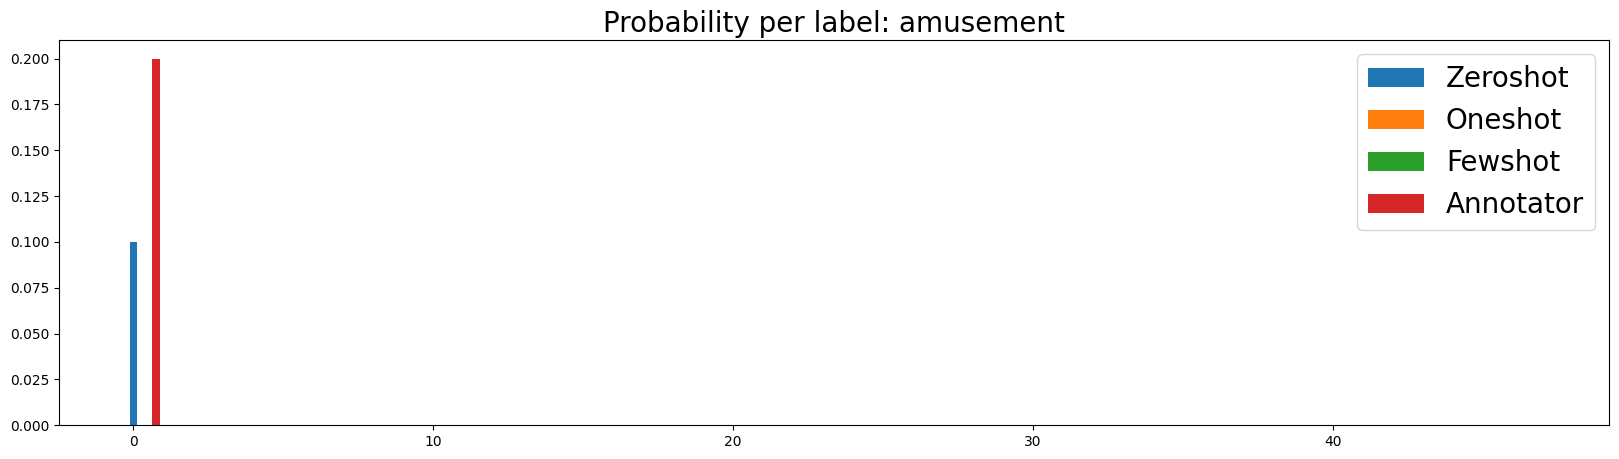

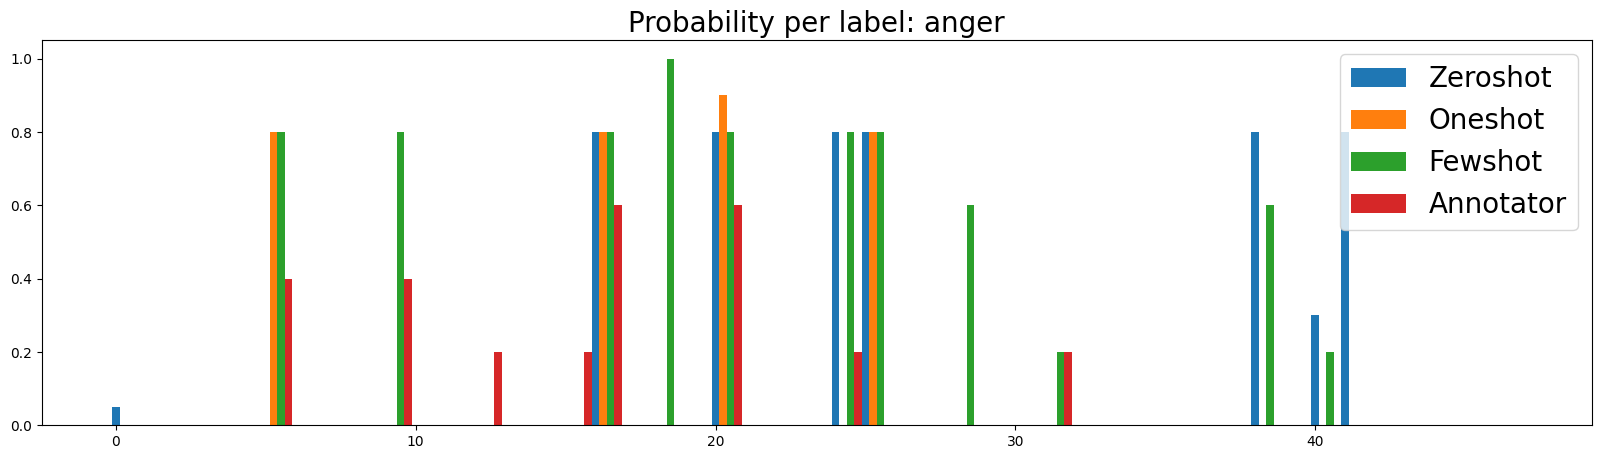

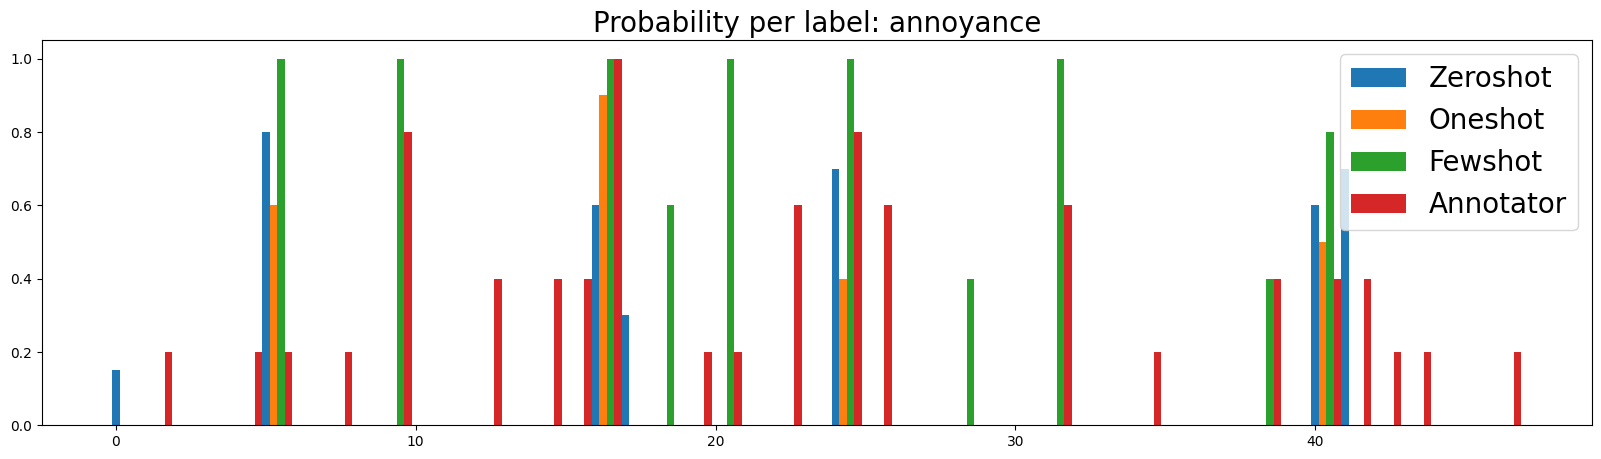

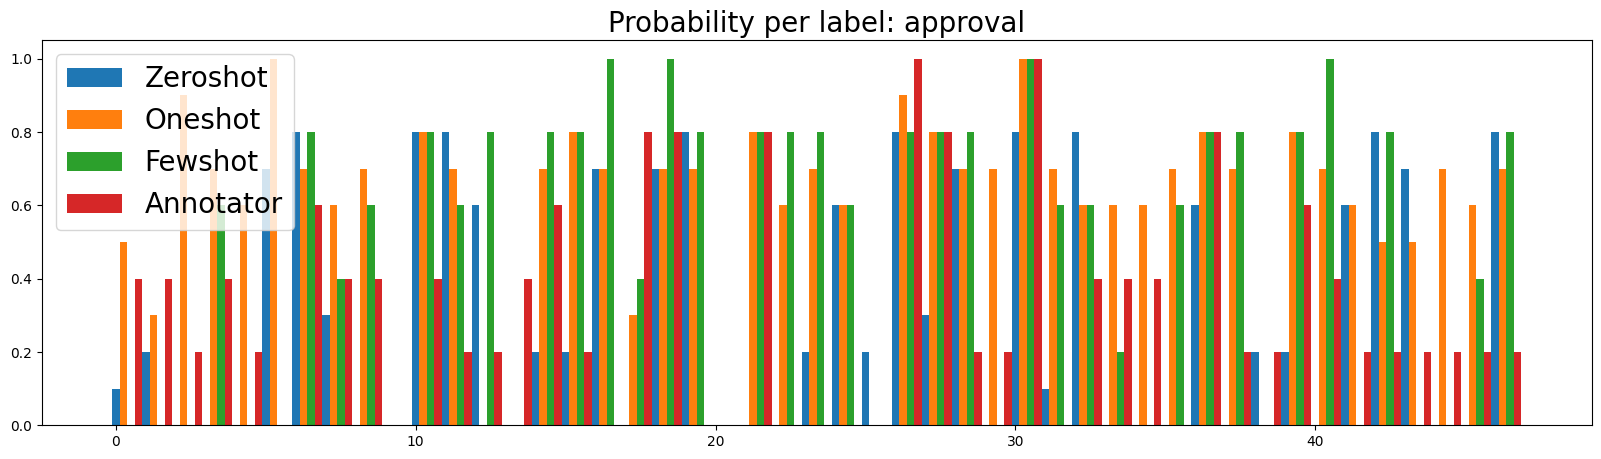

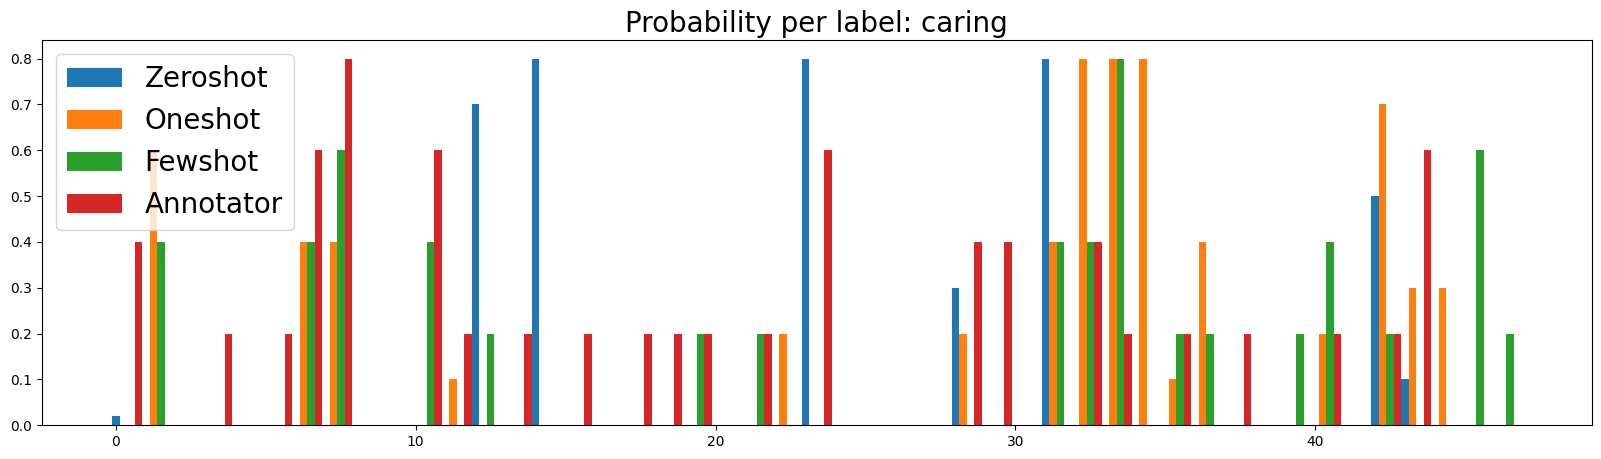

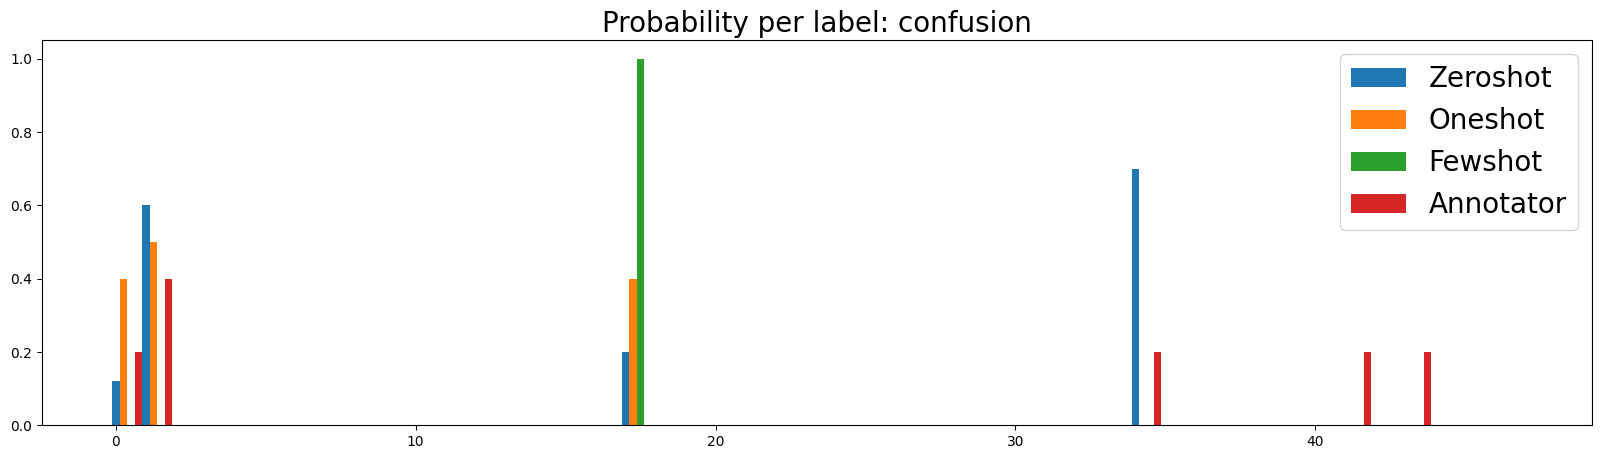

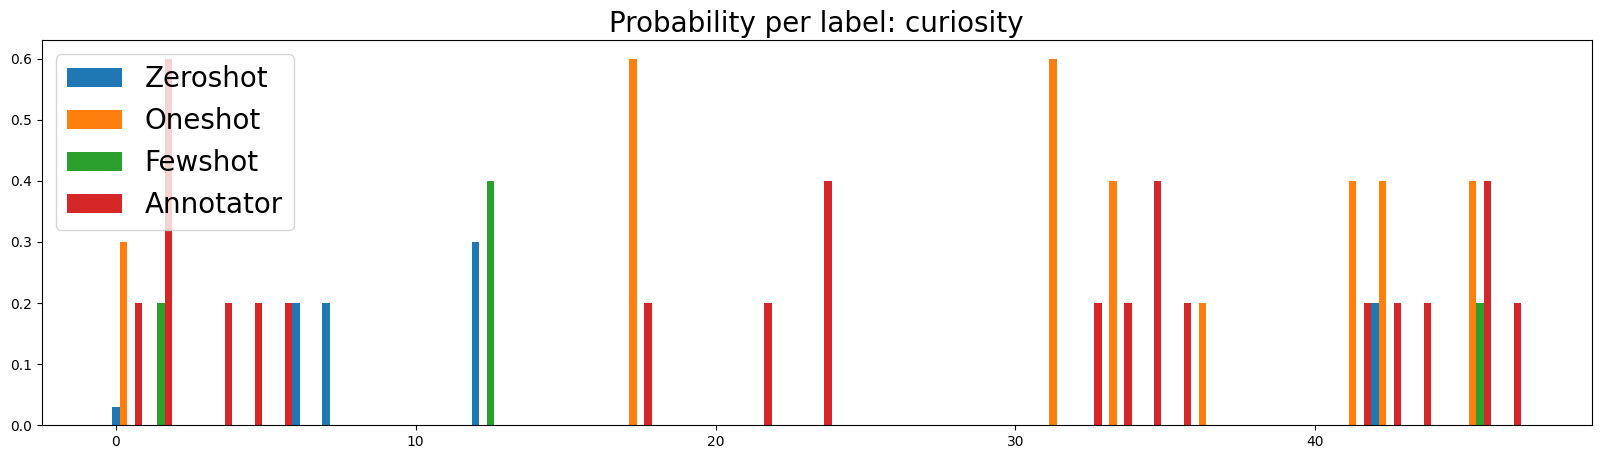

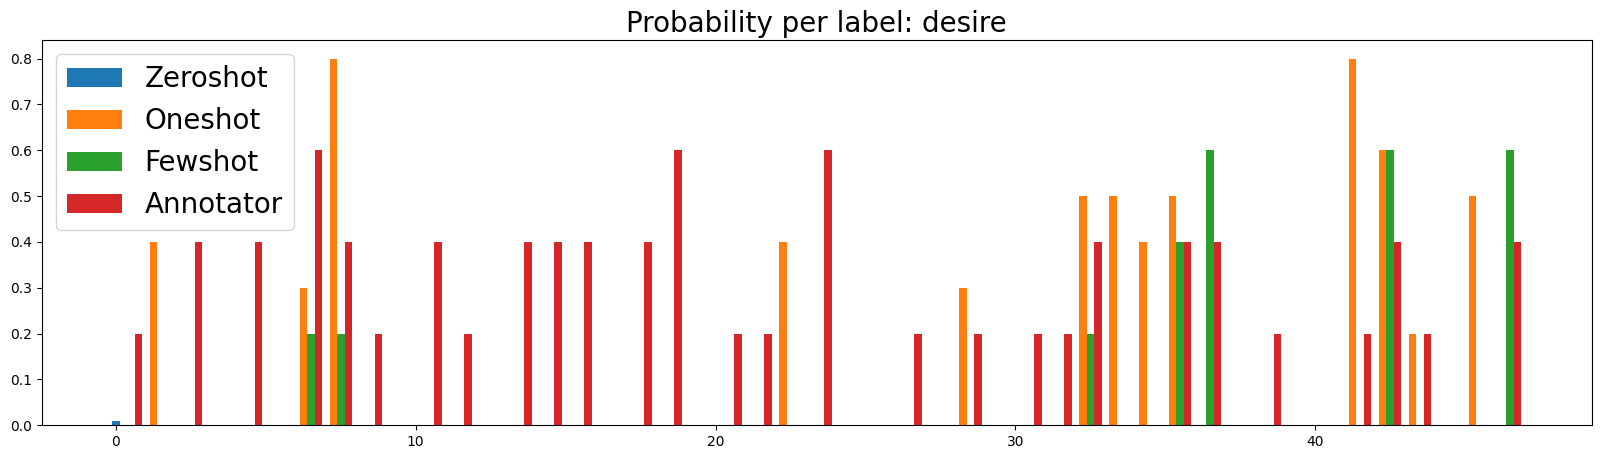

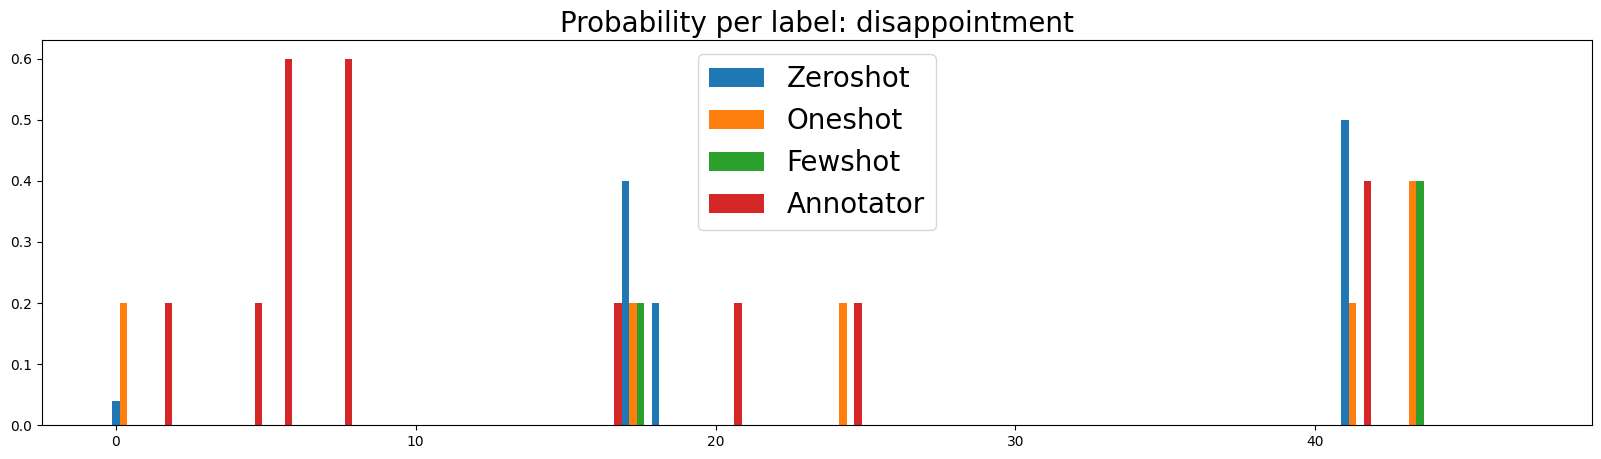

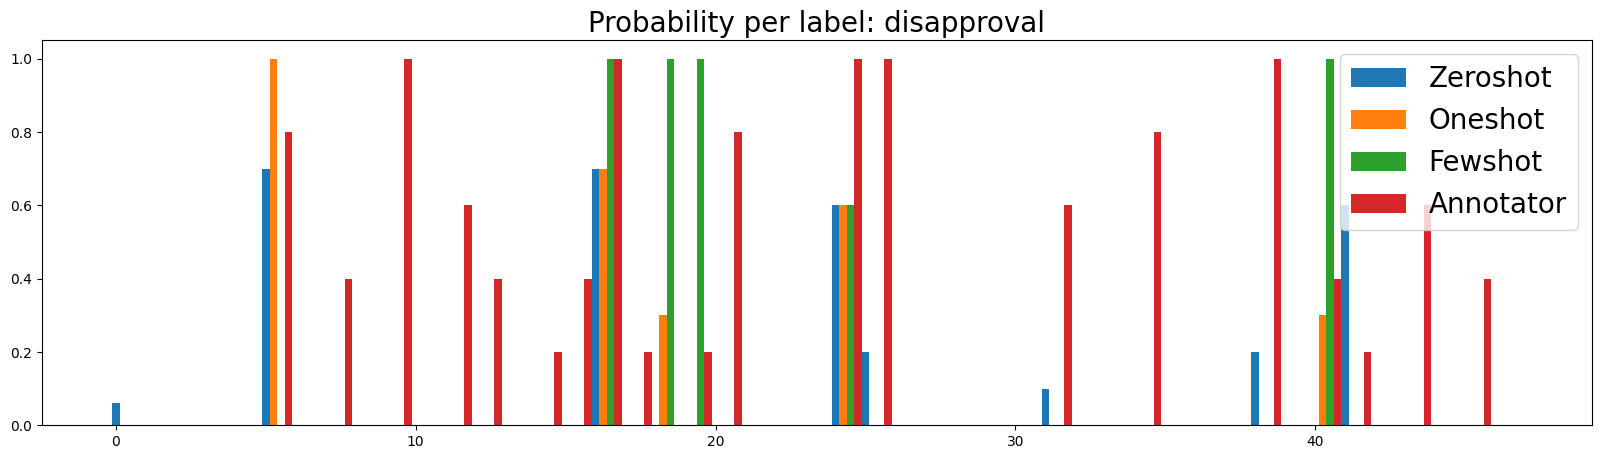

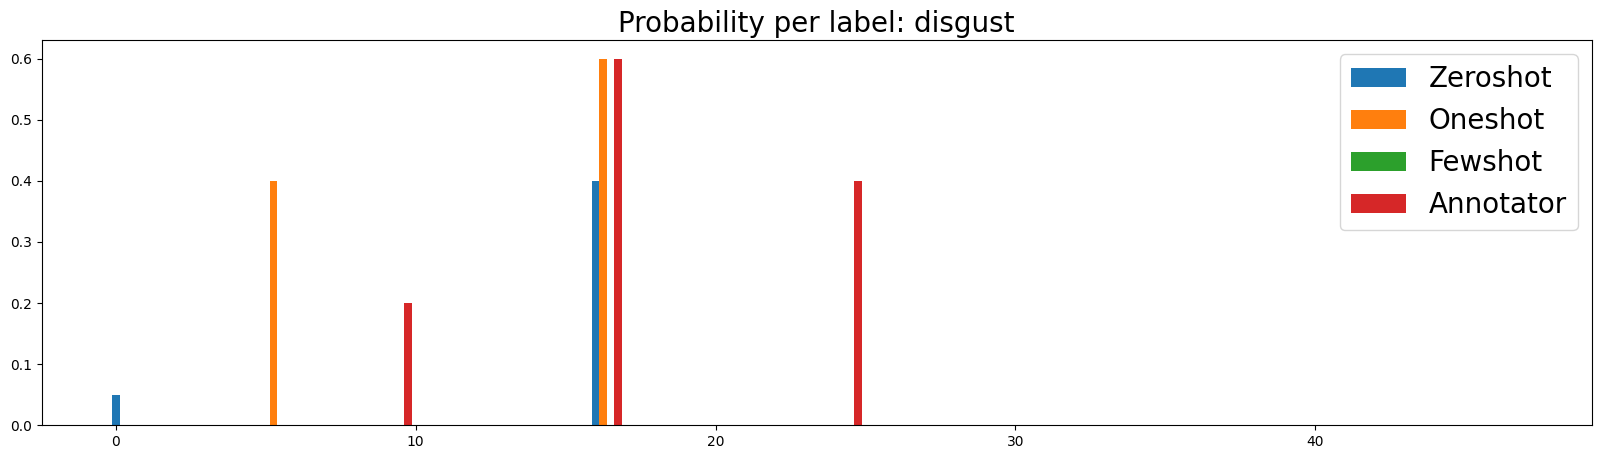

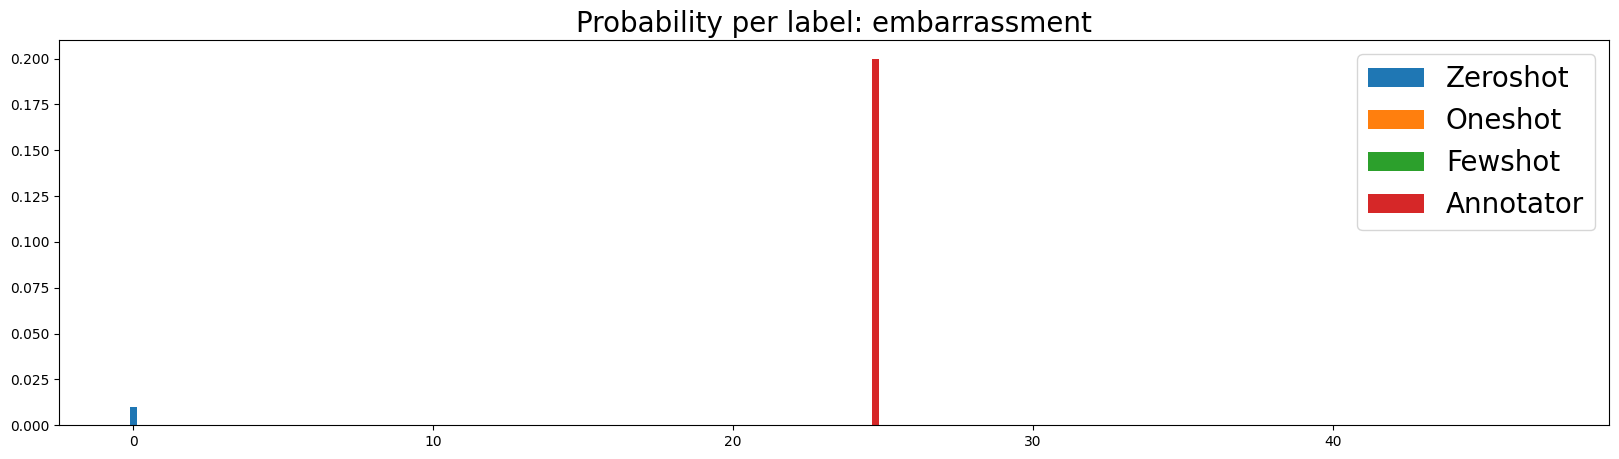

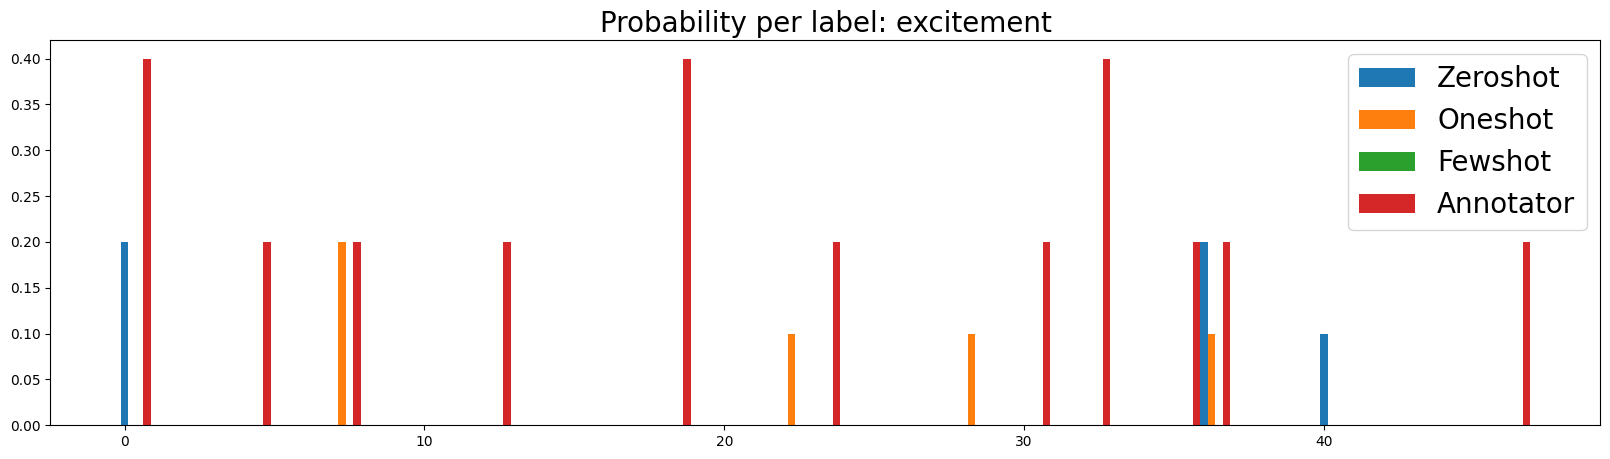

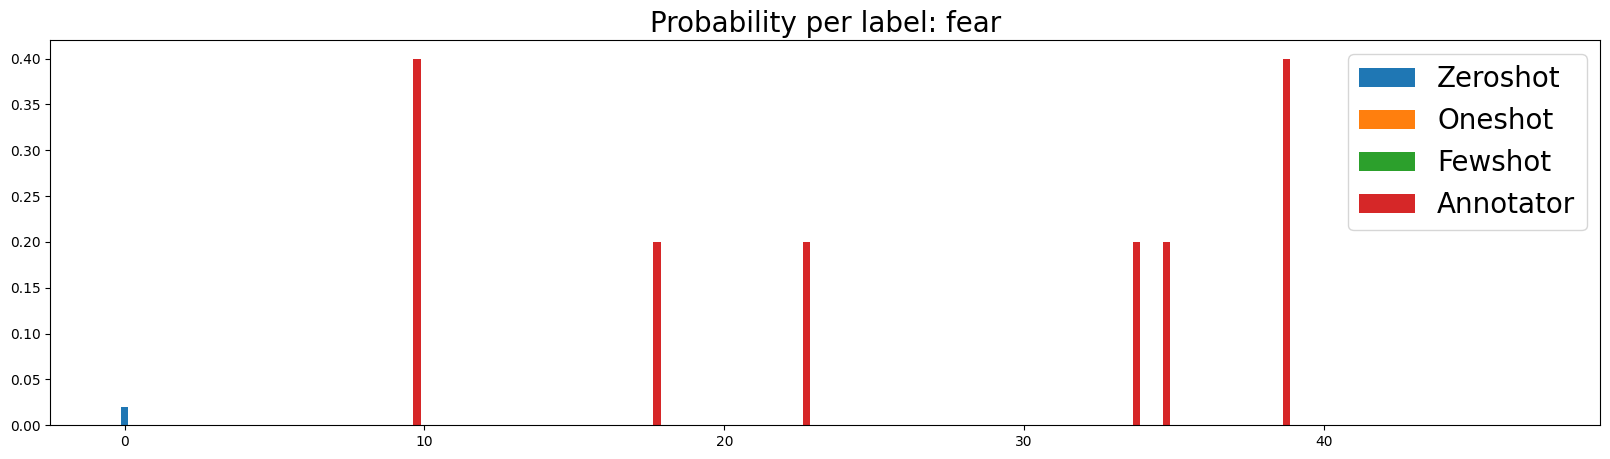

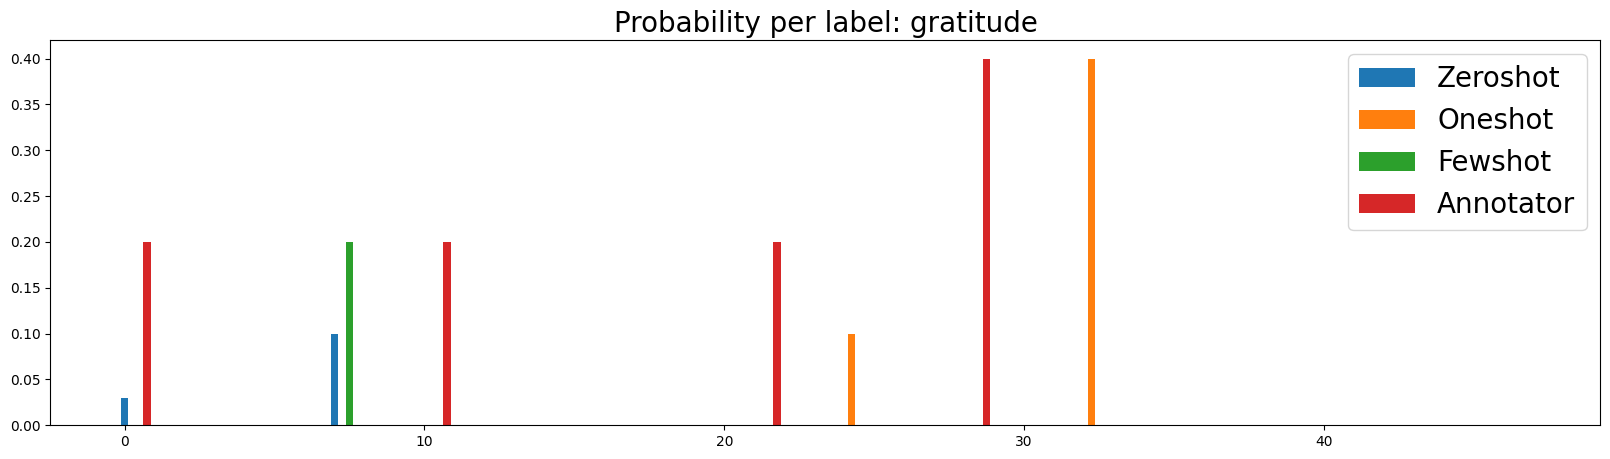

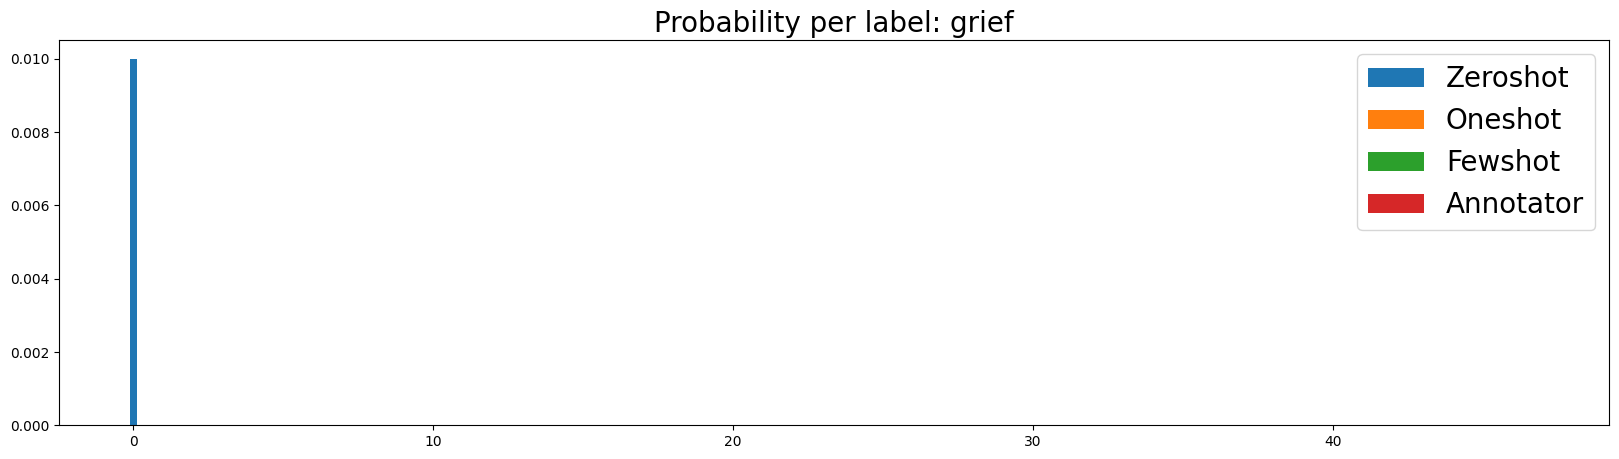

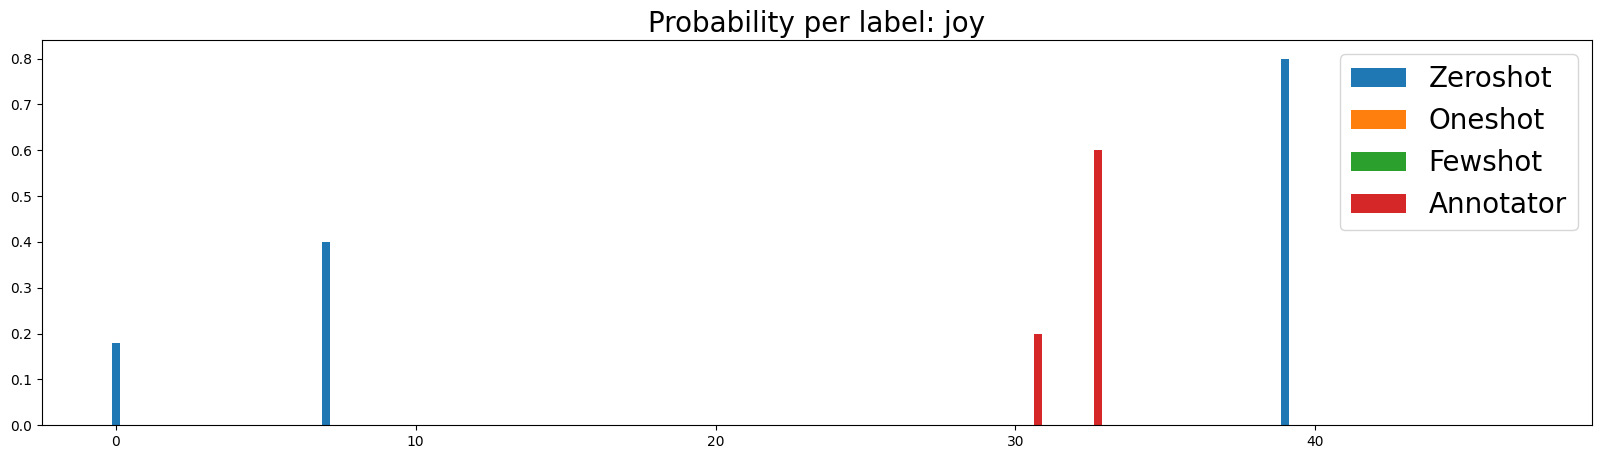

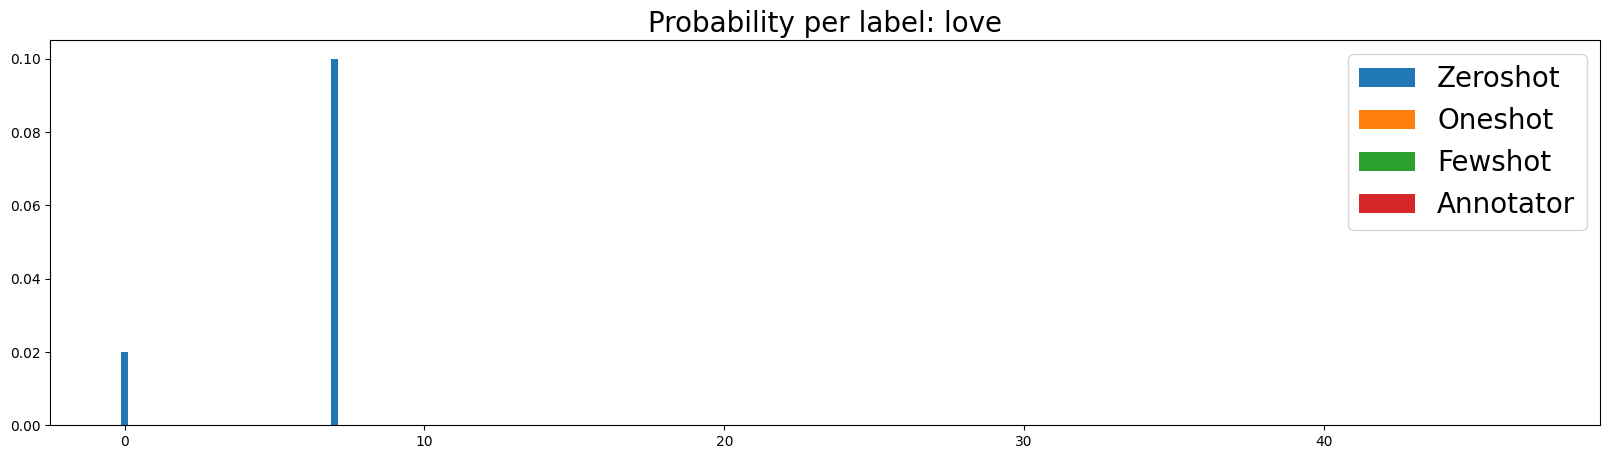

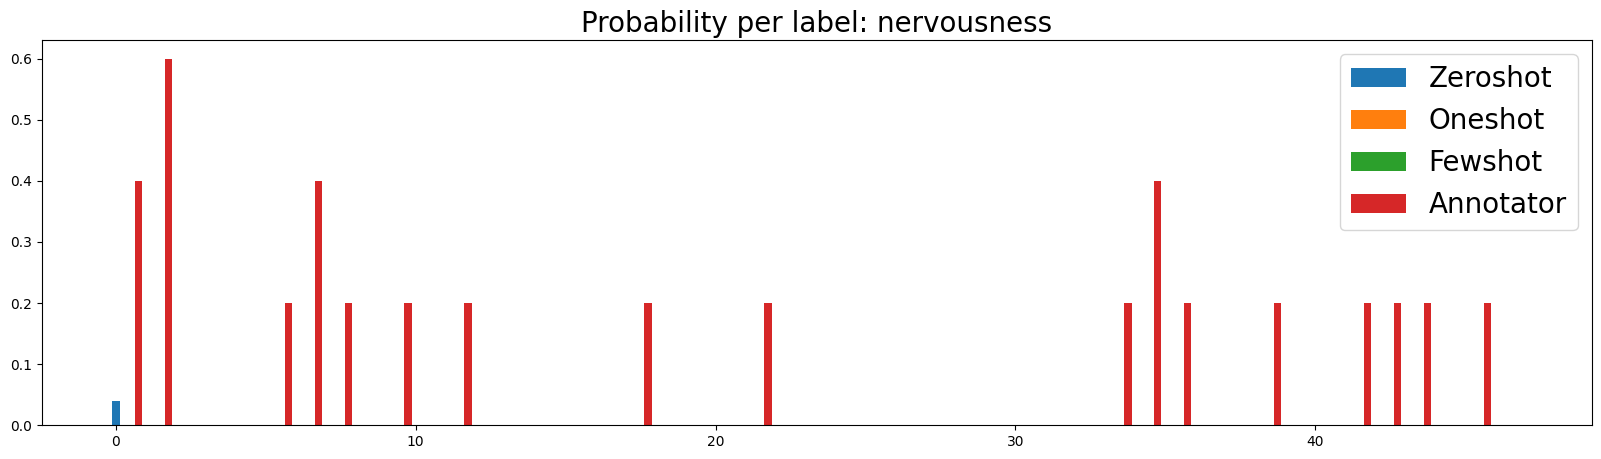

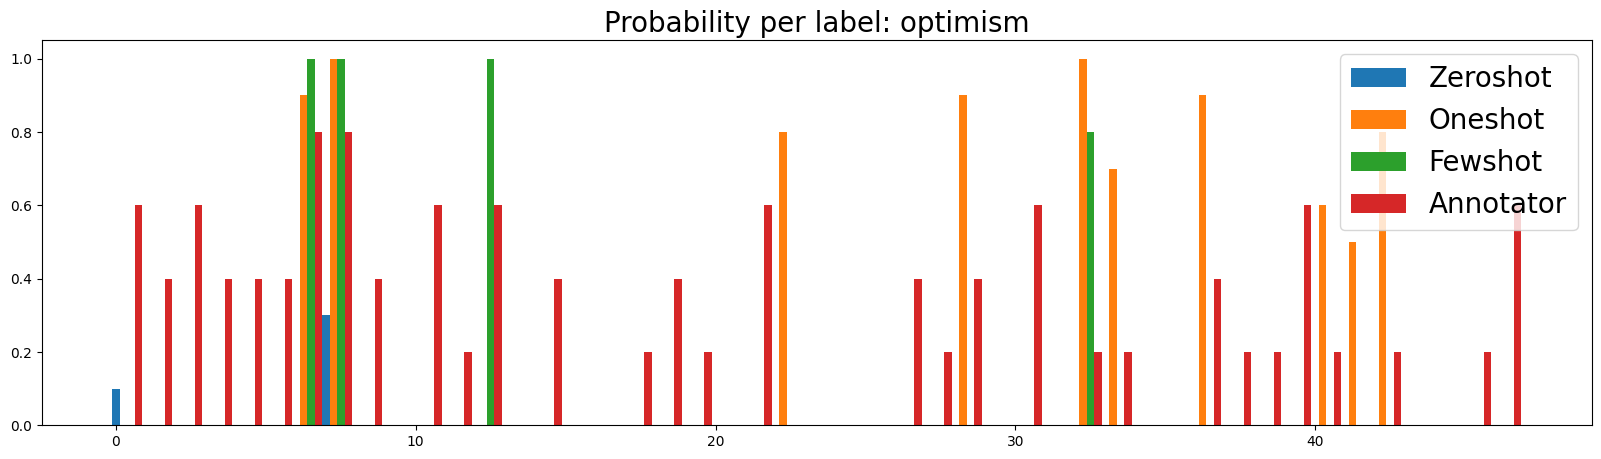

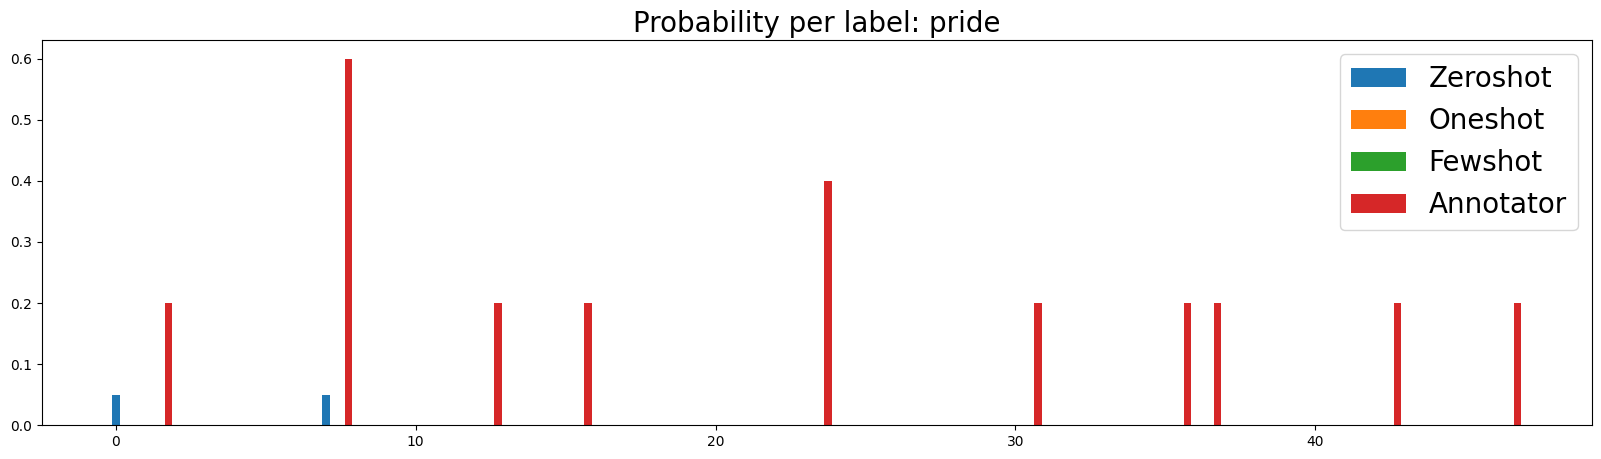

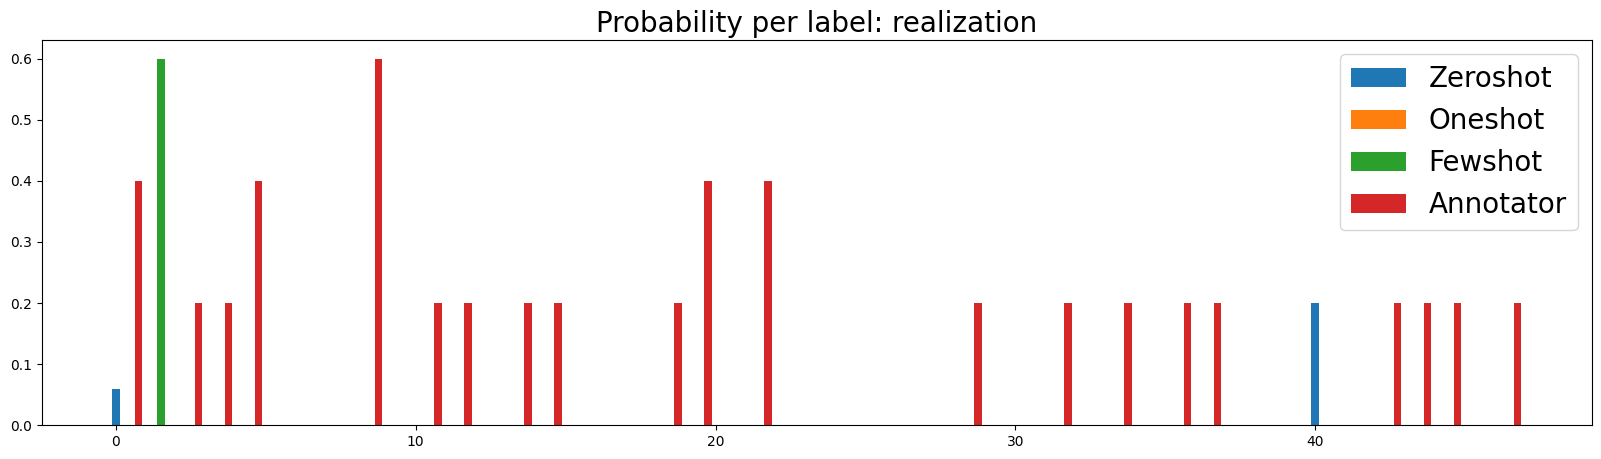

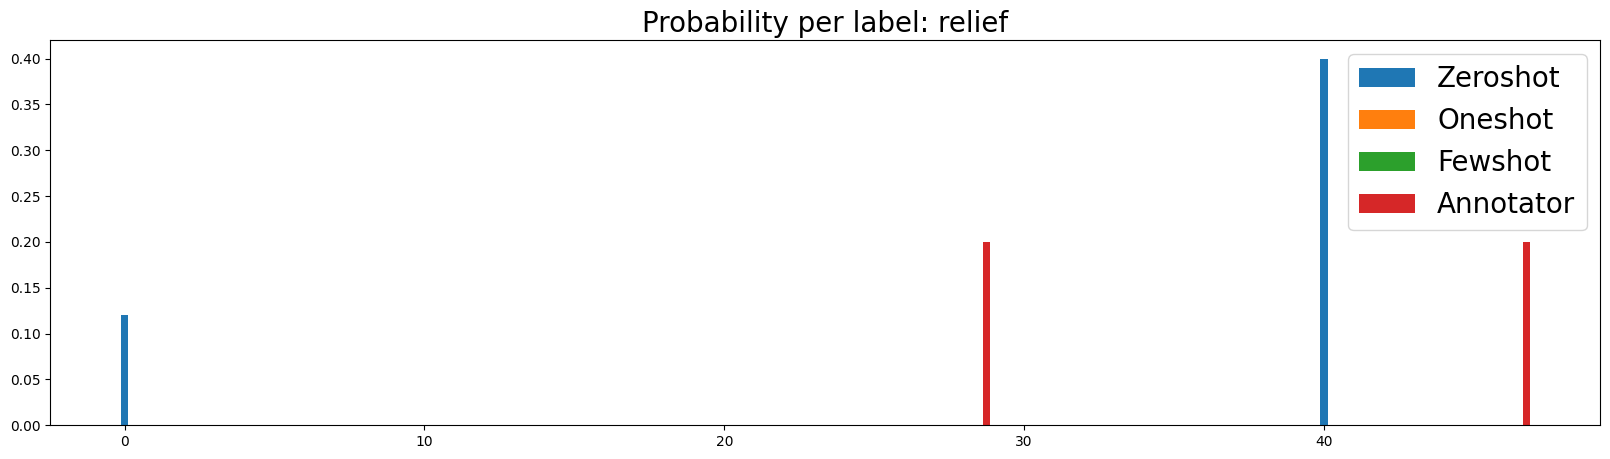

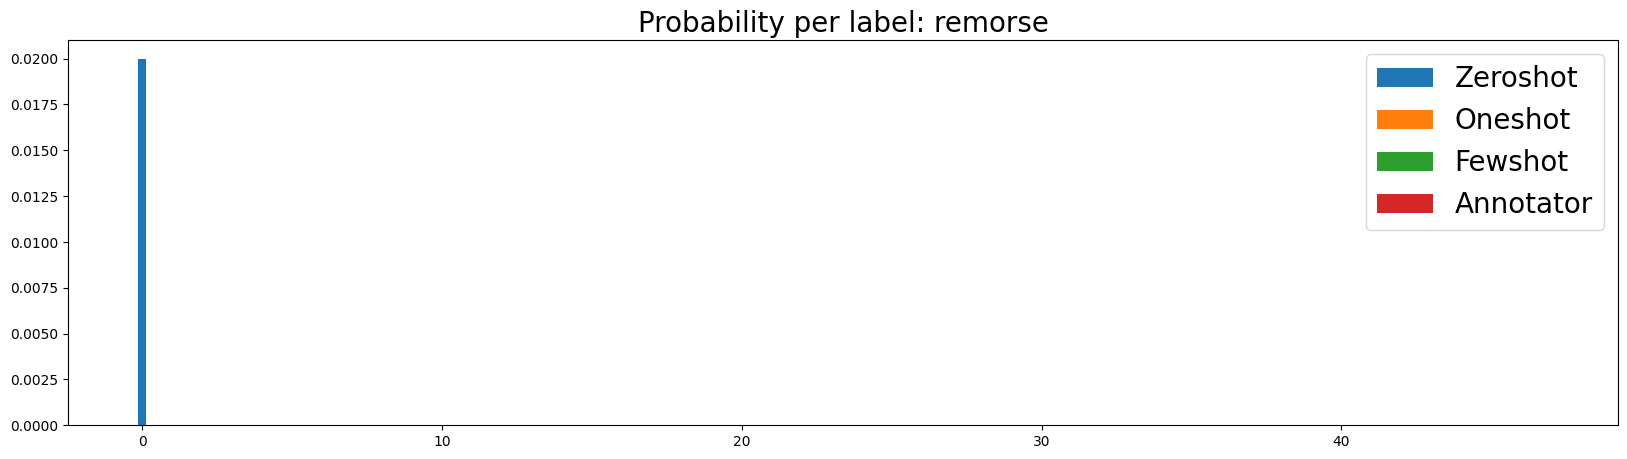

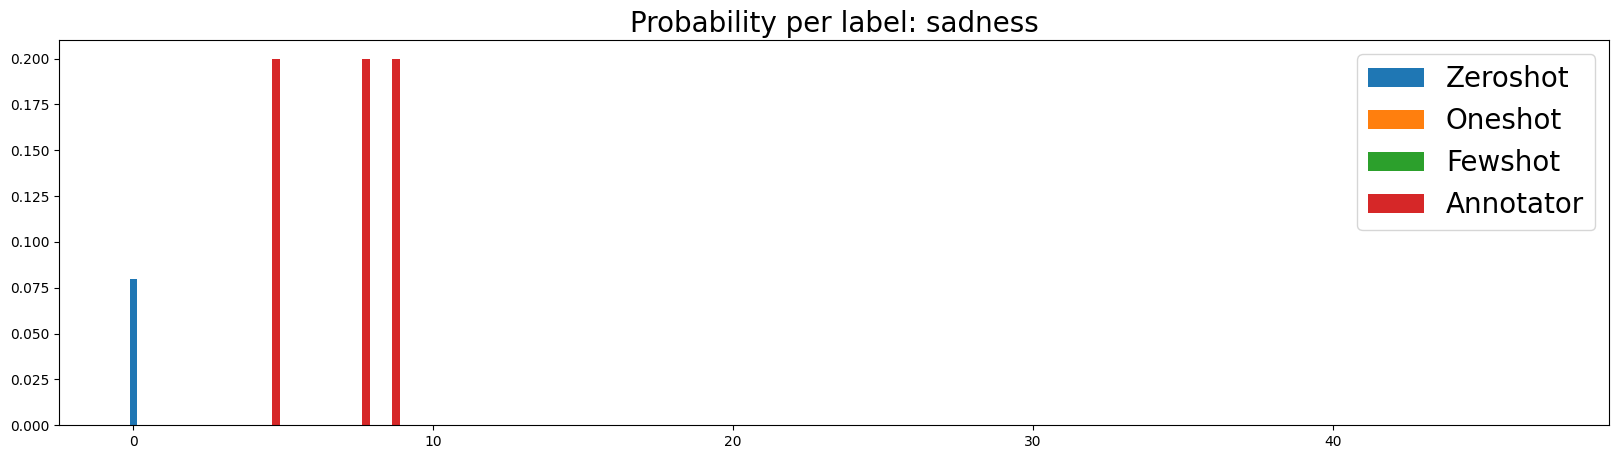

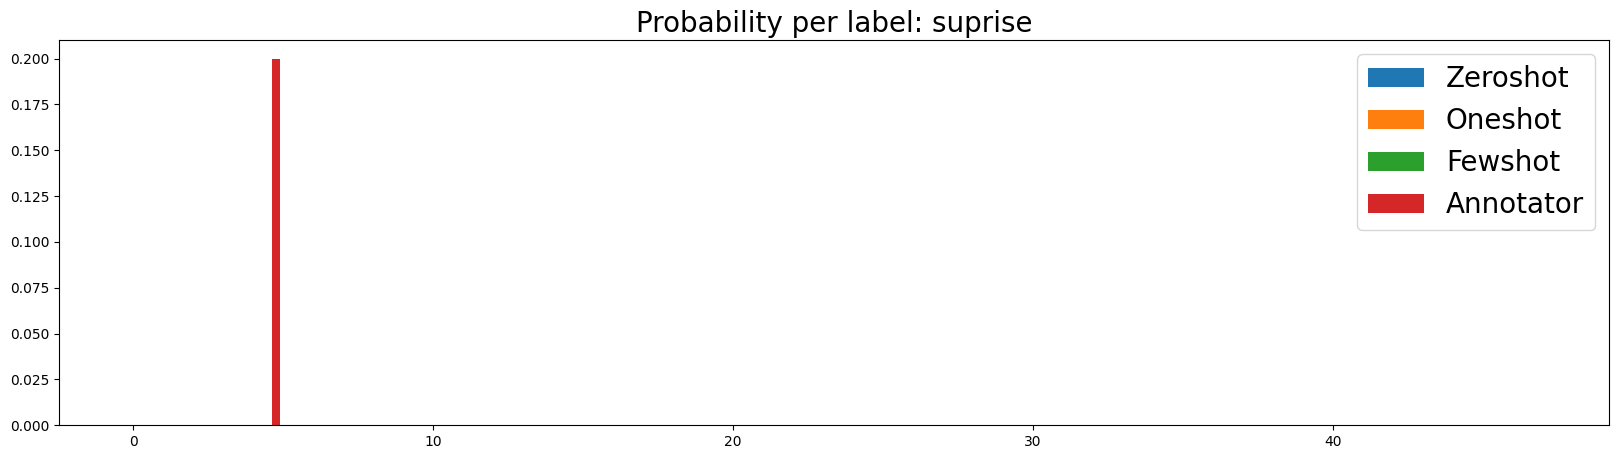

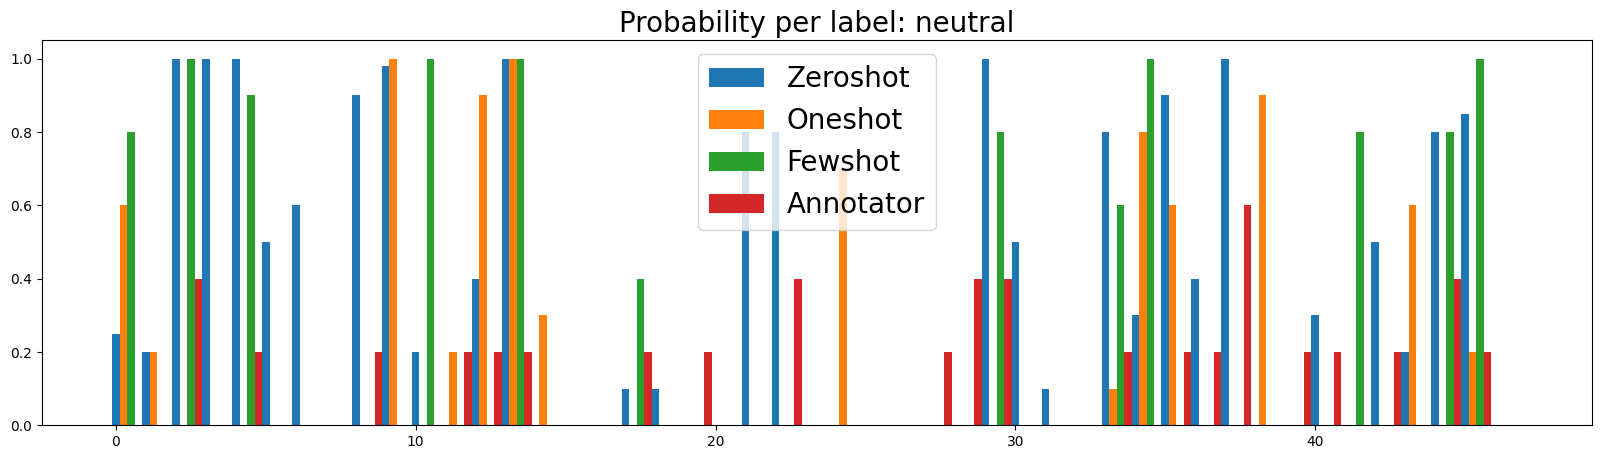

In [59]:
fewArray = numpy.array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0.8],
       [0. , 0. , 0. , 0. , 0. , 0.4, 0. , 0.2, 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.6, 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 1. ],
       [0. , 0. , 0. , 0. , 0.6, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0.9],
       [0. , 0. , 0.8, 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.8, 0.4, 0. , 0. , 0.2, 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.4, 0.6, 0. , 0. , 0.2, 0. , 0. , 0. , 0. ,
        0. , 0. , 0.2, 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.6, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0.8, 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.8, 0.4, 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 1. ],
       [0. , 0. , 0. , 0. , 0.6, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.8, 0.2, 0. , 0.4, 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 1. ],
       [0. , 0. , 0. , 0. , 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0.8, 1. , 1. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.4, 0. , 1. , 0. , 0. , 0.2, 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0.4],
       [0. , 0. , 1. , 0.6, 1. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.8, 0.2, 0. , 0. , 0. , 0. , 1. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0.8, 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.8, 0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0.8, 1. , 0.6, 0. , 0. , 0. , 0. , 0. , 0.6, 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0.6, 0.4, 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0.8],
       [0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0.2, 1. , 0.6, 0.4, 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.6, 0.4, 0. , 0. , 0.2, 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.8, 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.2, 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0.6],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 1. ],
       [0. , 0. , 0. , 0. , 0.6, 0.2, 0. , 0. , 0.4, 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.8, 0.2, 0. , 0. , 0.6, 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0.6, 0.4, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.8, 0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0.2, 0.8, 1. , 0.4, 0. , 0. , 0. , 0. , 1. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0.8],
       [0. , 0. , 0. , 0. , 0.8, 0.2, 0. , 0. , 0.6, 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.4, 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0.8],
       [0. , 0. , 0. , 0. , 0.4, 0.6, 0. , 0.2, 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 1. ],
       [0. , 0. , 0. , 0. , 0.8, 0.2, 0. , 0. , 0.6, 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ]])

oneArray = numpy.array([[0. , 0. , 0. , 0. , 0.5, 0. , 0.4, 0.3, 0. , 0.2, 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0.6],
       [0. , 0. , 0. , 0. , 0.3, 0.6, 0.5, 0. , 0.4, 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0.2],
       [0. , 0. , 0. , 0. , 0.9, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.7, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.6, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.7, 0.3, 0. , 0. , 0.5, 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0.8, 0.6, 1. , 0. , 0. , 0. , 0. , 0. , 1. , 0.4, 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.7, 0.4, 0. , 0. , 0.3, 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.9, 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.6, 0.4, 0. , 0. , 0.8, 0. , 0. , 0. , 0. ,
        0.2, 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.7, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 1. ],
       [0. , 0. , 0. , 0. , 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.7, 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0.2],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0.9],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 1. ],
       [0. , 0. , 0. , 0. , 0.7, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0.3],
       [0. , 0. , 0. , 0. , 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0.8, 0.9, 0.7, 0. , 0. , 0. , 0. , 0. , 0.7, 0.6, 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.3, 0. , 0.4, 0.6, 0. , 0.2, 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.7, 0. , 0. , 0. , 0. , 0. , 0.3, 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.7, 0.4, 0. , 0. , 0.3, 0. , 0. , 0. , 0. ,
        0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0.9, 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.7, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0.9, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.6, 0.2, 0. , 0. , 0.4, 0. , 0. , 0. , 0. ,
        0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0.8, 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.7, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0.4, 0.6, 0. , 0. , 0. , 0. , 0.2, 0.6, 0. , 0. ,
        0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0.7],
       [0. , 0. , 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.9, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.7, 0.2, 0. , 0. , 0.3, 0. , 0. , 0. , 0. ,
        0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0.9, 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.7, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.7, 0.4, 0. , 0.6, 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.6, 0.8, 0. , 0. , 0.5, 0. , 0. , 0. , 0. ,
        0. , 0. , 0.4, 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.6, 0.8, 0. , 0.4, 0.5, 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.7, 0. , 0. , 0. , 0. , 0. ,
        0. , 0.1],
       [0.2, 0. , 0. , 0. , 0.6, 0.8, 0. , 0. , 0.4, 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0.8],
       [0. , 0. , 0. , 0. , 0.7, 0.1, 0. , 0. , 0.5, 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0.6],
       [0.6, 0. , 0. , 0. , 0.8, 0.4, 0. , 0.2, 0. , 0. , 0. , 0. , 0. ,
        0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0.9, 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.7, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0.9],
       [0. , 0. , 0. , 0. , 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0.5, 0.7, 0.2, 0. , 0. , 0. , 0. , 0.3, 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.6, 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.6, 0. , 0. , 0.4, 0.8, 0.2, 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.5, 0.7, 0. , 0.4, 0.6, 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.8, 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.5, 0.3, 0. , 0. , 0.2, 0.4, 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0.6],
       [0. , 0. , 0. , 0. , 0.7, 0.3, 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ],
       [0. , 0. , 0. , 0. , 0.6, 0. , 0. , 0.4, 0.5, 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0.2],
       [0. , 0. , 0. , 0. , 0.7, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. ]])

zeroArray = numpy.array([[0.2 , 0.1 , 0.05, 0.15, 0.1 , 0.02, 0.12, 0.03, 0.01, 0.04, 0.06,
        0.05, 0.01, 0.2 , 0.02, 0.03, 0.01, 0.18, 0.02, 0.04, 0.1 , 0.05,
        0.06, 0.12, 0.02, 0.08, 0.  , 0.25],
       [0.  , 0.  , 0.  , 0.  , 0.2 , 0.  , 0.6 , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.2 ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.8 , 0.2 , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.8 ],
       [0.  , 0.  , 0.  , 0.8 , 0.7 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.7 ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.5 ],
       [0.4 , 0.  , 0.  , 0.  , 0.8 , 0.  , 0.  , 0.2 , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.6 ],
       [0.5 , 0.  , 0.  , 0.  , 0.3 , 0.  , 0.  , 0.2 , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.4 , 0.1 , 0.  , 0.3 , 0.05,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.9 ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.98],
       [0.  , 0.  , 0.  , 0.  , 0.8 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.2 ],
       [0.  , 0.  , 0.  , 0.  , 0.8 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.6 , 0.7 , 0.  , 0.3 , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.4 ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.2 , 0.8 , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.8 , 0.  , 0.  , 0.  , 0.2 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.8 , 0.6 , 0.7 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.7 ,
        0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.3 , 0.  , 0.  , 0.2 , 0.  , 0.  , 0.4 , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.1 ],
       [0.  , 0.  , 0.  , 0.  , 0.7 , 0.  , 0.  , 0.  , 0.  , 0.2 , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.1 ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.95],
       [0.  , 0.  , 0.  , 0.  , 0.8 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.8 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.8 ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.8 ],
       [0.  , 0.  , 0.  , 0.  , 0.2 , 0.8 , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.8 , 0.7 , 0.6 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.6 ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.8 , 0.  , 0.2 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.2 ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.5 , 0.  , 0.  , 0.  , 0.8 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.7 , 0.  , 0.  , 0.  , 0.3 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.7 , 0.3 , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.7 , 0.  , 0.  , 0.  , 0.8 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.5 ],
       [0.  , 0.  , 0.  , 0.  , 0.1 , 0.8 , 0.  , 0.  , 0.  , 0.  , 0.1 ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.1 ],
       [0.2 , 0.  , 0.  , 0.  , 0.8 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.8 ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.7 , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.3 ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.9 ],
       [0.8 , 0.  , 0.  , 0.  , 0.6 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.2 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.4 ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.8 , 0.  , 0.2 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.2 ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.2 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.8 , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.1 , 0.  , 0.3 , 0.6 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.1 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.2 , 0.4 , 0.  , 0.  , 0.  , 0.3 ],
       [0.  , 0.  , 0.8 , 0.7 , 0.6 , 0.  , 0.  , 0.  , 0.  , 0.5 , 0.6 ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.8 , 0.5 , 0.  , 0.2 , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.5 ],
       [0.  , 0.  , 0.  , 0.  , 0.7 , 0.1 , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.2 ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.8 ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.85],
       [0.  , 0.  , 0.  , 0.  , 0.8 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])
# for the onearray row 4 has already been deleted, thus row 6 and 21 were moved to be at 5 and 20
oneArraySmall = numpy.delete(oneArray, [5, 20], axis=0)
zeroArraySmall = numpy.delete(zeroArray, [4, 6, 21], axis=0)
# print(zeroArraySmall)
for i in range(0, 28):
    x = []
    for n in range(0, 47):
        x.append("Row " + str(n))
    
    N = len(x)
    ind = numpy.arange(N)
    width = 0.25
#     X_axis = numpy.arange(len(x)) 
    yZero = zeroArraySmall[:,i]
    yOne = oneArraySmall[:,i]
    yFew = fewArray[:,i]
    zAnnotator = numAnnotated[:,i]
    fig = plt.figure(figsize = (20, 5))
    plt.bar(ind, yZero, width, label = "Zeroshot")
    plt.bar(ind + width, yOne, width, label = "Oneshot")
    plt.bar(ind + width*2, yFew, width, label = "Fewshot")
    plt.bar(ind + width*3, zAnnotator, width, label = "Annotator")
    axisLabel = labelsList[i]
    # plt.xlabel(axisLabel, fontsize=25)
    plt.legend(fontsize=20) 
    plt.title("Probability per label: " + labelsList[i], fontsize=20)
    plt.show()

#     # for the onearray row 4 has already been deleted, thus row 6 and 21 were moved to be at 5 and 20
# oneArraySmall = numpy.delete(oneArray, [5, 20], axis=0)
# zeroArraySmall = numpy.delete(zeroArray, [4, 6, 21], axis=0)
# print(zeroArraySmall)
# for i in range(0, 28):
#     x = []
#     for n in range(0, 47):
#         x.append("Row " + str(n))
    
#     X_axis = numpy.arange(len(x)) 
#     yZero = zeroArraySmall[:,i]
#     yOne = oneArraySmall[:,i]
#     yFew = fewArray[:,i]
#     zAnnotator = numAnnotated[:,i]
#     fig = plt.figure(figsize = (20, 5))
#     plt.bar(X_axis -0.4, yZero, width=0.4, label = "Zeroshot")
#     plt.bar(X_axis -0.2, yOne, width=0.4, label = "Oneshot")
#     plt.bar(X_axis -0.2, yFew, width=0.4, label = "Fewshot")
#     plt.bar(X_axis +0.4, zAnnotator, width=0.4, label = "Annotator")
#     axisLabel = labelsList[i]
#     # plt.xlabel(axisLabel, fontsize=25)
#     plt.legend(fontsize=20) 
#     plt.title("Probability per label: " + labelsList[i], fontsize=20)
#     plt.show()